In [1]:
%tensorflow_version 1.x
import tensorflow as tf
%tensorflow_version 1.x
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [2]:
from preprocess import get_random_wav_batch, load_wavs, wavs_to_specs, sample_data_batch, sperate_magnitude_phase
from gamma_5_hop import SVSRNN
import tqdm

import os
import librosa
import numpy as np


def train(random_seed=0):
    np.random.seed(random_seed)

    # Download MIR1K dataset
    # download_dir = 'download'
    # data_dir = 'data'
    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'

    train_path = '/content/train-175.txt'
    # valid_path = os.path.join(mir1k_dir, 'valid.txt')
    # mir1k_dir = download_mir1k(download_dir = download_dir, data_dir = data_dir)
    # wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/UndividedWavfile')
    # wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/Wavfile')

    with open(train_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames_train = [file.strip() for file in content]

    # with open(valid_path, 'r') as text_file:
    #     content = text_file.readlines()
    # wav_filenames_valid = [file.strip() for file in content]

    # Preprocess parameters
    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    # Model parameters
    learning_rate = 0.0001
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    batch_size = 64
    sample_frames = 10  # ?????????????
    iterations = 20000  # 50000
    tensorboard_directory = './graphs/svsrnn'
    log_directory = './log'
    train_log_filename = 'train_log.csv'  # 用来画iteration-LOSS曲线
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_5_hop'
    model_filename = 'svsrnn.ckpt'

    if not os.path.exists(log_directory):
        os.makedirs(log_directory)
    open(os.path.join(log_directory, train_log_filename), 'w').close()
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)
    # Load train wavs
    wavs_mono_train, wavs_src1_train, wavs_src2_train = load_wavs(filenames=wav_filenames_train, sr=mir1k_sr)

    # Turn waves to spectrums !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    stfts_mono_train, stfts_src1_train, stfts_src2_train = wavs_to_specs(
        # stfts_mono_train: len:88 shape:(513,3537)  (513,5765) ...
        wavs_mono=wavs_mono_train, wavs_src1=wavs_src1_train, wavs_src2=wavs_src2_train, n_fft=n_fft,
        hop_length=hop_length)

    # wavs_mono_valid, wavs_src1_valid, wavs_src2_valid = load_wavs(filenames = wav_filenames_valid, sr = mir1k_sr)
    # stfts_mono_valid, stfts_src1_valid, stfts_src2_valid = wavs_to_specs(
    #     wavs_mono = wavs_mono_valid, wavs_src1 = wavs_src1_valid, wavs_src2 = wavs_src2_valid, n_fft = n_fft, hop_length = hop_length)

    # Initialize model
    model = SVSRNN(num_features=n_fft // 2 + 1, num_rnn_layer=num_rnn_layer, num_hidden_units=num_hidden_units,
                   tensorboard_directory=tensorboard_directory, clear_tensorboard=clear_tensorboard)

    # Start training
    for i in tqdm.tqdm(range(iterations)):

        data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
            stfts_mono=stfts_mono_train, stfts_src1=stfts_src1_train, stfts_src2=stfts_src2_train,
            batch_size=batch_size, sample_frames=sample_frames)
        x_mixed, _ = sperate_magnitude_phase(data=data_mono_batch)  # <class 'tuple'>: (64, 10, 513)
        y1, _ = sperate_magnitude_phase(data=data_src1_batch)
        y2, _ = sperate_magnitude_phase(data=data_src2_batch)

        train_loss = model.train(x=x_mixed, y1=y1, y2=y2, learning_rate=learning_rate)

        if i % 500 == 0:
            print('Step: %d Train Loss: %f' % (i, train_loss))

        # if i % 200 == 0:
        #     print('==============================================')
        #     # data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
        #     #     stfts_mono = stfts_mono_valid, stfts_src1 = stfts_src1_valid, stfts_src2 = stfts_src2_valid, batch_size = batch_size, sample_frames = sample_frames)
        #     x_mixed, _ = sperate_magnitude_phase(data = data_mono_batch)   #(64,10,513)
        #     y1, _ = sperate_magnitude_phase(data = data_src1_batch)
        #     y2, _ = sperate_magnitude_phase(data = data_src2_batch)
        #
        #     y1_pred, y2_pred, validation_loss = model.validate(x = x_mixed, y1 = y1, y2 = y2)
        #     print('Step: %d Validation Loss: %f' %(i, validation_loss))
        #     print('==============================================')
        #
        #     with open(os.path.join(log_directory, train_log_filename), 'a') as log_file:
        #         log_file.write('{},{},{}\n'.format(i, train_loss, validation_loss))

        if i % 1000 == 0:
            model.save(directory=model_directory, filename=model_filename)


if __name__ == '__main__':
    train()


Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead 

  0%|          | 0/20000 [00:00<?, ?it/s]

Step: 0 Train Loss: 9.481903


  3%|▎         | 501/20000 [03:19<1:59:36,  2.72it/s]

Step: 500 Train Loss: 1.055084


  5%|▌         | 1000/20000 [06:23<1:55:52,  2.73it/s]

Step: 1000 Train Loss: 0.608884


  8%|▊         | 1501/20000 [09:32<1:53:10,  2.72it/s]

Step: 1500 Train Loss: 0.506030


 10%|█         | 2000/20000 [12:35<1:49:32,  2.74it/s]

Step: 2000 Train Loss: 0.426613


 13%|█▎        | 2501/20000 [15:43<1:46:22,  2.74it/s]

Step: 2500 Train Loss: 0.357716


 15%|█▌        | 3000/20000 [18:46<1:43:57,  2.73it/s]

Step: 3000 Train Loss: 0.523908


 18%|█▊        | 3501/20000 [21:54<1:40:24,  2.74it/s]

Step: 3500 Train Loss: 0.453703


 20%|██        | 4000/20000 [24:57<1:37:06,  2.75it/s]

Step: 4000 Train Loss: 0.329613


 23%|██▎       | 4501/20000 [28:06<1:34:29,  2.73it/s]

Step: 4500 Train Loss: 0.280669


 25%|██▌       | 5000/20000 [31:08<1:31:02,  2.75it/s]

Step: 5000 Train Loss: 0.276834


 28%|██▊       | 5501/20000 [34:17<1:28:09,  2.74it/s]

Step: 5500 Train Loss: 0.294553


 30%|███       | 6000/20000 [37:19<1:25:43,  2.72it/s]

Step: 6000 Train Loss: 0.344746


 33%|███▎      | 6501/20000 [40:27<1:22:14,  2.74it/s]

Step: 6500 Train Loss: 0.232087


 35%|███▌      | 7000/20000 [43:30<1:19:07,  2.74it/s]

Step: 7000 Train Loss: 0.266252


 38%|███▊      | 7501/20000 [46:38<1:15:37,  2.75it/s]

Step: 7500 Train Loss: 0.442467


 40%|████      | 8000/20000 [49:39<1:12:45,  2.75it/s]

Step: 8000 Train Loss: 0.337460


 43%|████▎     | 8501/20000 [52:47<1:09:35,  2.75it/s]

Step: 8500 Train Loss: 0.276188


 45%|████▌     | 9000/20000 [55:49<1:06:46,  2.75it/s]

Step: 9000 Train Loss: 0.268612


 48%|████▊     | 9501/20000 [58:57<1:03:51,  2.74it/s]

Step: 9500 Train Loss: 0.277755


 50%|█████     | 10000/20000 [1:01:59<1:00:32,  2.75it/s]

Step: 10000 Train Loss: 0.238848


 53%|█████▎    | 10501/20000 [1:05:07<57:27,  2.76it/s]

Step: 10500 Train Loss: 0.318048


 55%|█████▌    | 11000/20000 [1:08:09<54:38,  2.75it/s]

Step: 11000 Train Loss: 0.332386


 58%|█████▊    | 11501/20000 [1:11:16<51:21,  2.76it/s]

Step: 11500 Train Loss: 0.202857


 60%|██████    | 12000/20000 [1:14:18<48:20,  2.76it/s]

Step: 12000 Train Loss: 0.246515


 63%|██████▎   | 12501/20000 [1:17:24<45:28,  2.75it/s]

Step: 12500 Train Loss: 0.217874


 65%|██████▌   | 13000/20000 [1:20:25<42:18,  2.76it/s]

Step: 13000 Train Loss: 0.264633


 68%|██████▊   | 13501/20000 [1:23:31<39:12,  2.76it/s]

Step: 13500 Train Loss: 0.246120


 70%|███████   | 14000/20000 [1:26:32<36:08,  2.77it/s]

Step: 14000 Train Loss: 0.274747


 73%|███████▎  | 14501/20000 [1:29:39<33:13,  2.76it/s]

Step: 14500 Train Loss: 0.219145


 75%|███████▌  | 15000/20000 [1:32:40<30:14,  2.76it/s]

Step: 15000 Train Loss: 0.247486


 78%|███████▊  | 15501/20000 [1:35:47<27:11,  2.76it/s]

Step: 15500 Train Loss: 0.250602


 80%|████████  | 16000/20000 [1:38:47<24:12,  2.75it/s]

Step: 16000 Train Loss: 0.205168


 83%|████████▎ | 16501/20000 [1:41:55<21:09,  2.76it/s]

Step: 16500 Train Loss: 0.256477


 85%|████████▌ | 17000/20000 [1:44:56<18:08,  2.76it/s]

Step: 17000 Train Loss: 0.246097


 88%|████████▊ | 17501/20000 [1:48:03<15:07,  2.75it/s]

Step: 17500 Train Loss: 0.212639


 90%|█████████ | 18000/20000 [1:51:03<12:02,  2.77it/s]

Step: 18000 Train Loss: 0.233087


 93%|█████████▎| 18501/20000 [1:54:11<09:01,  2.77it/s]

Step: 18500 Train Loss: 0.306911


 95%|█████████▌| 19000/20000 [1:57:11<06:00,  2.77it/s]

Step: 19000 Train Loss: 0.181108


 98%|█████████▊| 19501/20000 [2:00:18<03:00,  2.76it/s]

Step: 19500 Train Loss: 0.219480


100%|██████████| 20000/20000 [2:03:18<00:00,  2.70it/s]


In [2]:
import librosa
import os
import numpy as np
import tensorflow as tf
from mir_eval.separation import bss_eval_sources

from preprocess import load_wavs, prepare_data_full, wavs_to_specs, sperate_magnitude_phase, combine_magnitdue_phase
from gamma_5_hop import SVSRNN

def generate_demo():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    # model_directory = '/content/drive/My Drive/model-attention-aaa'
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_5_hop'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        wav_filename_dir = os.path.dirname(wav_filename)
        wav_filename_base = os.path.basename(wav_filename)
        wav_mono_filename = wav_filename_base.split('.')[0] + '_mono.wav'
        wav_src1_hat_filename = wav_filename_base.split('.')[0] + '_src1.wav'
        wav_src2_hat_filename = wav_filename_base.split('.')[0] + '_src2.wav'
        wav_mono_filepath = os.path.join(output_directory, wav_mono_filename)
        wav_src1_hat_filepath = os.path.join(output_directory, wav_src1_hat_filename)
        wav_src2_hat_filepath = os.path.join(output_directory, wav_src2_hat_filename)

        print('Processing %s ...' % wav_filename_base)

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)   #stft_mono_magnitude:(1,4681,513)  #stft_mono_phase:(4681,513)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)  #y1_pred:(1,10,513)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        librosa.output.write_wav(wav_mono_filepath, wav_mono, mir1k_sr)
        librosa.output.write_wav(wav_src1_hat_filepath, y1_hat, mir1k_sr)
        librosa.output.write_wav(wav_src2_hat_filepath, y2_hat, mir1k_sr)


def bss_eval_global(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):

    assert len(wavs_mono) == len(wavs_src1) == len(wavs_src2) == len(wavs_src1_pred) == len(wavs_src2_pred)

    num_samples = len(wavs_mono)

    gnsdr = np.zeros(2)
    gsir = np.zeros(2)
    gsar = np.zeros(2)
    frames_total = 0

    for wav_mono, wav_src1, wav_src2, wav_src1_pred, wav_src2_pred in zip(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):
        len_cropped = wav_src1_pred.shape[-1]
        wav_mono_cropped = wav_mono[:len_cropped]
        wav_src1_cropped = wav_src1[:len_cropped]
        wav_src2_cropped = wav_src2[:len_cropped]

        sdr, sir, sar, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_src1_pred, wav_src2_pred]), compute_permutation = False)
        sdr_mono, _, _, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_mono_cropped, wav_mono_cropped]), compute_permutation = False)

        nsdr = sdr - sdr_mono
        gnsdr += len_cropped * nsdr
        gsir += len_cropped * sir
        gsar += len_cropped * sar
        frames_total += len_cropped

    gnsdr = gnsdr / frames_total
    gsir = gsir / frames_total
    gsar = gsar / frames_total

    return gnsdr, gsir, gsar


def evaluate():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_5_hop'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    wavs_src1_pred = list()
    wavs_src2_pred = list()

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        wavs_src1_pred.append(y1_hat)
        wavs_src2_pred.append(y2_hat)

    gnsdr, gsir, gsar = bss_eval_global(wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, wavs_src1_pred = wavs_src1_pred, wavs_src2_pred = wavs_src2_pred)

    print('GNSDR:', gnsdr)
    print('GSIR:', gsir)
    print('GSAR:', gsar)



if __name__ == '__main__':

    # generate_demo()
    tf.reset_default_graph()
    evaluate()

Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead 

In [2]:
from preprocess import get_random_wav_batch, load_wavs, wavs_to_specs, sample_data_batch, sperate_magnitude_phase
from gamma_53_hop3 import SVSRNN
import tqdm

import os
import librosa
import numpy as np


def train(random_seed=0):
    np.random.seed(random_seed)

    # Download MIR1K dataset
    # download_dir = 'download'
    # data_dir = 'data'
    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'

    train_path = '/content/train-175.txt'
    # valid_path = os.path.join(mir1k_dir, 'valid.txt')
    # mir1k_dir = download_mir1k(download_dir = download_dir, data_dir = data_dir)
    # wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/UndividedWavfile')
    # wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/Wavfile')

    with open(train_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames_train = [file.strip() for file in content]

    # with open(valid_path, 'r') as text_file:
    #     content = text_file.readlines()
    # wav_filenames_valid = [file.strip() for file in content]

    # Preprocess parameters
    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    # Model parameters
    learning_rate = 0.0001
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    batch_size = 64
    sample_frames = 10  # ?????????????
    iterations = 20000  # 50000
    tensorboard_directory = './graphs/svsrnn'
    log_directory = './log'
    train_log_filename = 'train_log.csv'  # 用来画iteration-LOSS曲线
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_53_hop3'
    model_filename = 'svsrnn.ckpt'

    if not os.path.exists(log_directory):
        os.makedirs(log_directory)
    open(os.path.join(log_directory, train_log_filename), 'w').close()
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)
    # Load train wavs
    wavs_mono_train, wavs_src1_train, wavs_src2_train = load_wavs(filenames=wav_filenames_train, sr=mir1k_sr)

    # Turn waves to spectrums !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    stfts_mono_train, stfts_src1_train, stfts_src2_train = wavs_to_specs(
        # stfts_mono_train: len:88 shape:(513,3537)  (513,5765) ...
        wavs_mono=wavs_mono_train, wavs_src1=wavs_src1_train, wavs_src2=wavs_src2_train, n_fft=n_fft,
        hop_length=hop_length)

    # wavs_mono_valid, wavs_src1_valid, wavs_src2_valid = load_wavs(filenames = wav_filenames_valid, sr = mir1k_sr)
    # stfts_mono_valid, stfts_src1_valid, stfts_src2_valid = wavs_to_specs(
    #     wavs_mono = wavs_mono_valid, wavs_src1 = wavs_src1_valid, wavs_src2 = wavs_src2_valid, n_fft = n_fft, hop_length = hop_length)

    # Initialize model
    model = SVSRNN(num_features=n_fft // 2 + 1, num_rnn_layer=num_rnn_layer, num_hidden_units=num_hidden_units,
                   tensorboard_directory=tensorboard_directory, clear_tensorboard=clear_tensorboard)

    # Start training
    for i in tqdm.tqdm(range(iterations)):

        data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
            stfts_mono=stfts_mono_train, stfts_src1=stfts_src1_train, stfts_src2=stfts_src2_train,
            batch_size=batch_size, sample_frames=sample_frames)
        x_mixed, _ = sperate_magnitude_phase(data=data_mono_batch)  # <class 'tuple'>: (64, 10, 513)
        y1, _ = sperate_magnitude_phase(data=data_src1_batch)
        y2, _ = sperate_magnitude_phase(data=data_src2_batch)

        train_loss = model.train(x=x_mixed, y1=y1, y2=y2, learning_rate=learning_rate)

        if i % 500 == 0:
            print('Step: %d Train Loss: %f' % (i, train_loss))

        # if i % 200 == 0:
        #     print('==============================================')
        #     # data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
        #     #     stfts_mono = stfts_mono_valid, stfts_src1 = stfts_src1_valid, stfts_src2 = stfts_src2_valid, batch_size = batch_size, sample_frames = sample_frames)
        #     x_mixed, _ = sperate_magnitude_phase(data = data_mono_batch)   #(64,10,513)
        #     y1, _ = sperate_magnitude_phase(data = data_src1_batch)
        #     y2, _ = sperate_magnitude_phase(data = data_src2_batch)
        #
        #     y1_pred, y2_pred, validation_loss = model.validate(x = x_mixed, y1 = y1, y2 = y2)
        #     print('Step: %d Validation Loss: %f' %(i, validation_loss))
        #     print('==============================================')
        #
        #     with open(os.path.join(log_directory, train_log_filename), 'a') as log_file:
        #         log_file.write('{},{},{}\n'.format(i, train_loss, validation_loss))

        if i % 1000 == 0:
            model.save(directory=model_directory, filename=model_filename)


if __name__ == '__main__':
    train()


Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

  0%|          | 0/20000 [00:00<?, ?it/s]

Step: 0 Train Loss: 8.859591


  3%|▎         | 501/20000 [03:17<2:00:04,  2.71it/s]

Step: 500 Train Loss: 0.913975


  5%|▌         | 1000/20000 [06:23<1:57:29,  2.70it/s]

Step: 1000 Train Loss: 0.603244


  8%|▊         | 1501/20000 [09:34<1:53:46,  2.71it/s]

Step: 1500 Train Loss: 0.490997


 10%|█         | 2000/20000 [12:38<1:50:55,  2.70it/s]

Step: 2000 Train Loss: 0.390466


 13%|█▎        | 2501/20000 [15:48<1:47:19,  2.72it/s]

Step: 2500 Train Loss: 0.329817


 15%|█▌        | 3000/20000 [18:52<1:44:41,  2.71it/s]

Step: 3000 Train Loss: 0.474730


 18%|█▊        | 3501/20000 [22:03<1:42:03,  2.69it/s]

Step: 3500 Train Loss: 0.417438


 20%|██        | 4000/20000 [25:07<1:38:37,  2.70it/s]

Step: 4000 Train Loss: 0.363549


 23%|██▎       | 4501/20000 [28:19<1:35:34,  2.70it/s]

Step: 4500 Train Loss: 0.289095


 25%|██▌       | 5000/20000 [31:24<1:32:39,  2.70it/s]

Step: 5000 Train Loss: 0.279715


 28%|██▊       | 5501/20000 [34:35<1:29:47,  2.69it/s]

Step: 5500 Train Loss: 0.282810


 30%|███       | 6000/20000 [37:40<1:26:33,  2.70it/s]

Step: 6000 Train Loss: 0.335373


 33%|███▎      | 6501/20000 [40:52<1:22:52,  2.71it/s]

Step: 6500 Train Loss: 0.246764


 35%|███▌      | 7000/20000 [43:57<1:19:54,  2.71it/s]

Step: 7000 Train Loss: 0.266411


 38%|███▊      | 7501/20000 [47:08<1:16:42,  2.72it/s]

Step: 7500 Train Loss: 0.446484


 40%|████      | 8000/20000 [50:12<1:14:00,  2.70it/s]

Step: 8000 Train Loss: 0.338123


 43%|████▎     | 8501/20000 [53:22<1:10:38,  2.71it/s]

Step: 8500 Train Loss: 0.284294


 45%|████▌     | 9000/20000 [56:26<1:07:23,  2.72it/s]

Step: 9000 Train Loss: 0.262661


 48%|████▊     | 9501/20000 [59:36<1:04:27,  2.71it/s]

Step: 9500 Train Loss: 0.281258


 50%|█████     | 10000/20000 [1:02:40<1:01:42,  2.70it/s]

Step: 10000 Train Loss: 0.242179


 53%|█████▎    | 10501/20000 [1:05:52<58:24,  2.71it/s]

Step: 10500 Train Loss: 0.322717


 55%|█████▌    | 11000/20000 [1:08:56<55:15,  2.71it/s]

Step: 11000 Train Loss: 0.334522


 58%|█████▊    | 11501/20000 [1:12:06<52:30,  2.70it/s]

Step: 11500 Train Loss: 0.200171


 60%|██████    | 12000/20000 [1:15:11<49:35,  2.69it/s]

Step: 12000 Train Loss: 0.249580


 63%|██████▎   | 12501/20000 [1:18:22<45:58,  2.72it/s]

Step: 12500 Train Loss: 0.216590


 65%|██████▌   | 13000/20000 [1:21:26<43:18,  2.69it/s]

Step: 13000 Train Loss: 0.265225


 68%|██████▊   | 13501/20000 [1:24:38<40:12,  2.69it/s]

Step: 13500 Train Loss: 0.251752


 70%|███████   | 14000/20000 [1:27:42<36:53,  2.71it/s]

Step: 14000 Train Loss: 0.276848


 73%|███████▎  | 14501/20000 [1:30:53<33:53,  2.70it/s]

Step: 14500 Train Loss: 0.220366


 75%|███████▌  | 15000/20000 [1:33:57<30:48,  2.71it/s]

Step: 15000 Train Loss: 0.248430


 78%|███████▊  | 15501/20000 [1:37:08<27:50,  2.69it/s]

Step: 15500 Train Loss: 0.253077


 80%|████████  | 16000/20000 [1:40:13<24:34,  2.71it/s]

Step: 16000 Train Loss: 0.205261


 83%|████████▎ | 16501/20000 [1:43:23<21:30,  2.71it/s]

Step: 16500 Train Loss: 0.260036


 85%|████████▌ | 17000/20000 [1:46:27<18:21,  2.72it/s]

Step: 17000 Train Loss: 0.246947


 88%|████████▊ | 17501/20000 [1:49:37<15:20,  2.72it/s]

Step: 17500 Train Loss: 0.215925


 90%|█████████ | 18000/20000 [1:52:41<12:15,  2.72it/s]

Step: 18000 Train Loss: 0.234360


 93%|█████████▎| 18501/20000 [1:55:51<09:11,  2.72it/s]

Step: 18500 Train Loss: 0.308464


 95%|█████████▌| 19000/20000 [1:58:55<06:10,  2.70it/s]

Step: 19000 Train Loss: 0.181234


 98%|█████████▊| 19501/20000 [2:02:05<03:04,  2.71it/s]

Step: 19500 Train Loss: 0.219466


100%|██████████| 20000/20000 [2:05:09<00:00,  2.66it/s]


In [2]:
import librosa
import os
import numpy as np
import tensorflow as tf
from mir_eval.separation import bss_eval_sources

from preprocess import load_wavs, prepare_data_full, wavs_to_specs, sperate_magnitude_phase, combine_magnitdue_phase
from gamma_53_hop3 import SVSRNN

def generate_demo():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    # model_directory = '/content/drive/My Drive/model-attention-aaa'
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_53_hop3'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        wav_filename_dir = os.path.dirname(wav_filename)
        wav_filename_base = os.path.basename(wav_filename)
        wav_mono_filename = wav_filename_base.split('.')[0] + '_mono.wav'
        wav_src1_hat_filename = wav_filename_base.split('.')[0] + '_src1.wav'
        wav_src2_hat_filename = wav_filename_base.split('.')[0] + '_src2.wav'
        wav_mono_filepath = os.path.join(output_directory, wav_mono_filename)
        wav_src1_hat_filepath = os.path.join(output_directory, wav_src1_hat_filename)
        wav_src2_hat_filepath = os.path.join(output_directory, wav_src2_hat_filename)

        print('Processing %s ...' % wav_filename_base)

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)   #stft_mono_magnitude:(1,4681,513)  #stft_mono_phase:(4681,513)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)  #y1_pred:(1,10,513)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        librosa.output.write_wav(wav_mono_filepath, wav_mono, mir1k_sr)
        librosa.output.write_wav(wav_src1_hat_filepath, y1_hat, mir1k_sr)
        librosa.output.write_wav(wav_src2_hat_filepath, y2_hat, mir1k_sr)


def bss_eval_global(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):

    assert len(wavs_mono) == len(wavs_src1) == len(wavs_src2) == len(wavs_src1_pred) == len(wavs_src2_pred)

    num_samples = len(wavs_mono)

    gnsdr = np.zeros(2)
    gsir = np.zeros(2)
    gsar = np.zeros(2)
    frames_total = 0

    for wav_mono, wav_src1, wav_src2, wav_src1_pred, wav_src2_pred in zip(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):
        len_cropped = wav_src1_pred.shape[-1]
        wav_mono_cropped = wav_mono[:len_cropped]
        wav_src1_cropped = wav_src1[:len_cropped]
        wav_src2_cropped = wav_src2[:len_cropped]

        sdr, sir, sar, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_src1_pred, wav_src2_pred]), compute_permutation = False)
        sdr_mono, _, _, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_mono_cropped, wav_mono_cropped]), compute_permutation = False)

        nsdr = sdr - sdr_mono
        gnsdr += len_cropped * nsdr
        gsir += len_cropped * sir
        gsar += len_cropped * sar
        frames_total += len_cropped

    gnsdr = gnsdr / frames_total
    gsir = gsir / frames_total
    gsar = gsar / frames_total

    return gnsdr, gsir, gsar


def evaluate():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_53_hop3'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    wavs_src1_pred = list()
    wavs_src2_pred = list()

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        wavs_src1_pred.append(y1_hat)
        wavs_src2_pred.append(y2_hat)

    gnsdr, gsir, gsar = bss_eval_global(wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, wavs_src1_pred = wavs_src1_pred, wavs_src2_pred = wavs_src2_pred)

    print('GNSDR:', gnsdr)
    print('GSIR:', gsir)
    print('GSAR:', gsar)



if __name__ == '__main__':

    # generate_demo()
    tf.reset_default_graph()
    evaluate()

Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

In [2]:
from preprocess import get_random_wav_batch, load_wavs, wavs_to_specs, sample_data_batch, sperate_magnitude_phase
from gamma_53_hop4 import SVSRNN
import tqdm

import os
import librosa
import numpy as np


def train(random_seed=0):
    np.random.seed(random_seed)

    # Download MIR1K dataset
    # download_dir = 'download'
    # data_dir = 'data'
    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'

    train_path = '/content/train-175.txt'
    # valid_path = os.path.join(mir1k_dir, 'valid.txt')
    # mir1k_dir = download_mir1k(download_dir = download_dir, data_dir = data_dir)
    # wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/UndividedWavfile')
    # wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/Wavfile')

    with open(train_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames_train = [file.strip() for file in content]

    # with open(valid_path, 'r') as text_file:
    #     content = text_file.readlines()
    # wav_filenames_valid = [file.strip() for file in content]

    # Preprocess parameters
    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    # Model parameters
    learning_rate = 0.0001
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    batch_size = 64
    sample_frames = 10  # ?????????????
    iterations = 20000  # 50000
    tensorboard_directory = './graphs/svsrnn'
    log_directory = './log'
    train_log_filename = 'train_log.csv'  # 用来画iteration-LOSS曲线
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_53_hop4'
    model_filename = 'svsrnn.ckpt'

    if not os.path.exists(log_directory):
        os.makedirs(log_directory)
    open(os.path.join(log_directory, train_log_filename), 'w').close()
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)
    # Load train wavs
    wavs_mono_train, wavs_src1_train, wavs_src2_train = load_wavs(filenames=wav_filenames_train, sr=mir1k_sr)

    # Turn waves to spectrums !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    stfts_mono_train, stfts_src1_train, stfts_src2_train = wavs_to_specs(
        # stfts_mono_train: len:88 shape:(513,3537)  (513,5765) ...
        wavs_mono=wavs_mono_train, wavs_src1=wavs_src1_train, wavs_src2=wavs_src2_train, n_fft=n_fft,
        hop_length=hop_length)

    # wavs_mono_valid, wavs_src1_valid, wavs_src2_valid = load_wavs(filenames = wav_filenames_valid, sr = mir1k_sr)
    # stfts_mono_valid, stfts_src1_valid, stfts_src2_valid = wavs_to_specs(
    #     wavs_mono = wavs_mono_valid, wavs_src1 = wavs_src1_valid, wavs_src2 = wavs_src2_valid, n_fft = n_fft, hop_length = hop_length)

    # Initialize model
    model = SVSRNN(num_features=n_fft // 2 + 1, num_rnn_layer=num_rnn_layer, num_hidden_units=num_hidden_units,
                   tensorboard_directory=tensorboard_directory, clear_tensorboard=clear_tensorboard)

    # Start training
    for i in tqdm.tqdm(range(iterations)):

        data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
            stfts_mono=stfts_mono_train, stfts_src1=stfts_src1_train, stfts_src2=stfts_src2_train,
            batch_size=batch_size, sample_frames=sample_frames)
        x_mixed, _ = sperate_magnitude_phase(data=data_mono_batch)  # <class 'tuple'>: (64, 10, 513)
        y1, _ = sperate_magnitude_phase(data=data_src1_batch)
        y2, _ = sperate_magnitude_phase(data=data_src2_batch)

        train_loss = model.train(x=x_mixed, y1=y1, y2=y2, learning_rate=learning_rate)

        if i % 500 == 0:
            print('Step: %d Train Loss: %f' % (i, train_loss))

        # if i % 200 == 0:
        #     print('==============================================')
        #     # data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
        #     #     stfts_mono = stfts_mono_valid, stfts_src1 = stfts_src1_valid, stfts_src2 = stfts_src2_valid, batch_size = batch_size, sample_frames = sample_frames)
        #     x_mixed, _ = sperate_magnitude_phase(data = data_mono_batch)   #(64,10,513)
        #     y1, _ = sperate_magnitude_phase(data = data_src1_batch)
        #     y2, _ = sperate_magnitude_phase(data = data_src2_batch)
        #
        #     y1_pred, y2_pred, validation_loss = model.validate(x = x_mixed, y1 = y1, y2 = y2)
        #     print('Step: %d Validation Loss: %f' %(i, validation_loss))
        #     print('==============================================')
        #
        #     with open(os.path.join(log_directory, train_log_filename), 'a') as log_file:
        #         log_file.write('{},{},{}\n'.format(i, train_loss, validation_loss))

        if i % 1000 == 0:
            model.save(directory=model_directory, filename=model_filename)


if __name__ == '__main__':
    train()


Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

  0%|          | 0/20000 [00:00<?, ?it/s]

Step: 0 Train Loss: 9.273130


  3%|▎         | 501/20000 [03:16<2:00:20,  2.70it/s]

Step: 500 Train Loss: 1.269606


  5%|▌         | 1000/20000 [06:21<1:58:10,  2.68it/s]

Step: 1000 Train Loss: 0.825401


  8%|▊         | 1501/20000 [09:33<1:54:02,  2.70it/s]

Step: 1500 Train Loss: 0.507825


 10%|█         | 2000/20000 [12:38<1:51:04,  2.70it/s]

Step: 2000 Train Loss: 0.413271


 13%|█▎        | 2501/20000 [15:48<1:47:37,  2.71it/s]

Step: 2500 Train Loss: 0.362578


 15%|█▌        | 3000/20000 [18:53<1:44:26,  2.71it/s]

Step: 3000 Train Loss: 0.513803


 18%|█▊        | 3501/20000 [22:05<1:41:13,  2.72it/s]

Step: 3500 Train Loss: 0.476343


 20%|██        | 4000/20000 [25:10<1:39:15,  2.69it/s]

Step: 4000 Train Loss: 0.417646


 23%|██▎       | 4501/20000 [28:22<1:35:35,  2.70it/s]

Step: 4500 Train Loss: 0.300765


 25%|██▌       | 5000/20000 [31:26<1:32:03,  2.72it/s]

Step: 5000 Train Loss: 0.291957


 28%|██▊       | 5501/20000 [34:36<1:28:59,  2.72it/s]

Step: 5500 Train Loss: 0.294866


 30%|███       | 6000/20000 [37:40<1:27:08,  2.68it/s]

Step: 6000 Train Loss: 0.338013


 33%|███▎      | 6501/20000 [40:50<1:22:37,  2.72it/s]

Step: 6500 Train Loss: 0.234844


 35%|███▌      | 7000/20000 [43:54<1:20:01,  2.71it/s]

Step: 7000 Train Loss: 0.272264


 38%|███▊      | 7501/20000 [47:04<1:16:32,  2.72it/s]

Step: 7500 Train Loss: 0.446601


 40%|████      | 8000/20000 [50:08<1:13:26,  2.72it/s]

Step: 8000 Train Loss: 0.333222


 43%|████▎     | 8501/20000 [53:17<1:10:25,  2.72it/s]

Step: 8500 Train Loss: 0.282757


 45%|████▌     | 9000/20000 [56:21<1:07:22,  2.72it/s]

Step: 9000 Train Loss: 0.262819


 48%|████▊     | 9501/20000 [59:31<1:04:46,  2.70it/s]

Step: 9500 Train Loss: 0.281447


 50%|█████     | 10000/20000 [1:02:35<1:01:33,  2.71it/s]

Step: 10000 Train Loss: 0.240850


 53%|█████▎    | 10501/20000 [1:05:45<58:10,  2.72it/s]

Step: 10500 Train Loss: 0.325249


 55%|█████▌    | 11000/20000 [1:08:48<55:26,  2.71it/s]

Step: 11000 Train Loss: 0.329649


 58%|█████▊    | 11501/20000 [1:11:58<52:00,  2.72it/s]

Step: 11500 Train Loss: 0.200426


 60%|██████    | 12000/20000 [1:15:02<49:03,  2.72it/s]

Step: 12000 Train Loss: 0.248162


 63%|██████▎   | 12501/20000 [1:18:12<45:57,  2.72it/s]

Step: 12500 Train Loss: 0.214969


 65%|██████▌   | 13000/20000 [1:21:15<43:07,  2.71it/s]

Step: 13000 Train Loss: 0.262971


 68%|██████▊   | 13501/20000 [1:24:25<39:45,  2.72it/s]

Step: 13500 Train Loss: 0.251788


 70%|███████   | 14000/20000 [1:27:29<36:39,  2.73it/s]

Step: 14000 Train Loss: 0.273515


 73%|███████▎  | 14501/20000 [1:30:39<33:43,  2.72it/s]

Step: 14500 Train Loss: 0.225560


 75%|███████▌  | 15000/20000 [1:33:42<30:42,  2.71it/s]

Step: 15000 Train Loss: 0.246577


 78%|███████▊  | 15501/20000 [1:36:52<27:31,  2.72it/s]

Step: 15500 Train Loss: 0.251518


 80%|████████  | 16000/20000 [1:39:56<24:36,  2.71it/s]

Step: 16000 Train Loss: 0.204755


 83%|████████▎ | 16501/20000 [1:43:06<21:30,  2.71it/s]

Step: 16500 Train Loss: 0.256976


 85%|████████▌ | 17000/20000 [1:46:09<18:27,  2.71it/s]

Step: 17000 Train Loss: 0.245776


 88%|████████▊ | 17501/20000 [1:49:19<15:17,  2.72it/s]

Step: 17500 Train Loss: 0.213658


 90%|█████████ | 18000/20000 [1:52:23<12:19,  2.71it/s]

Step: 18000 Train Loss: 0.232453


 93%|█████████▎| 18501/20000 [1:55:33<09:18,  2.68it/s]

Step: 18500 Train Loss: 0.306360


 95%|█████████▌| 19000/20000 [1:58:37<06:10,  2.70it/s]

Step: 19000 Train Loss: 0.181982


 98%|█████████▊| 19501/20000 [2:01:46<03:03,  2.72it/s]

Step: 19500 Train Loss: 0.218378


100%|██████████| 20000/20000 [2:04:50<00:00,  2.67it/s]


In [2]:
import librosa
import os
import numpy as np
import tensorflow as tf
from mir_eval.separation import bss_eval_sources

from preprocess import load_wavs, prepare_data_full, wavs_to_specs, sperate_magnitude_phase, combine_magnitdue_phase
from gamma_53_hop4 import SVSRNN

def generate_demo():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    # model_directory = '/content/drive/My Drive/model-attention-aaa'
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_53_hop4'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        wav_filename_dir = os.path.dirname(wav_filename)
        wav_filename_base = os.path.basename(wav_filename)
        wav_mono_filename = wav_filename_base.split('.')[0] + '_mono.wav'
        wav_src1_hat_filename = wav_filename_base.split('.')[0] + '_src1.wav'
        wav_src2_hat_filename = wav_filename_base.split('.')[0] + '_src2.wav'
        wav_mono_filepath = os.path.join(output_directory, wav_mono_filename)
        wav_src1_hat_filepath = os.path.join(output_directory, wav_src1_hat_filename)
        wav_src2_hat_filepath = os.path.join(output_directory, wav_src2_hat_filename)

        print('Processing %s ...' % wav_filename_base)

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)   #stft_mono_magnitude:(1,4681,513)  #stft_mono_phase:(4681,513)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)  #y1_pred:(1,10,513)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        librosa.output.write_wav(wav_mono_filepath, wav_mono, mir1k_sr)
        librosa.output.write_wav(wav_src1_hat_filepath, y1_hat, mir1k_sr)
        librosa.output.write_wav(wav_src2_hat_filepath, y2_hat, mir1k_sr)


def bss_eval_global(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):

    assert len(wavs_mono) == len(wavs_src1) == len(wavs_src2) == len(wavs_src1_pred) == len(wavs_src2_pred)

    num_samples = len(wavs_mono)

    gnsdr = np.zeros(2)
    gsir = np.zeros(2)
    gsar = np.zeros(2)
    frames_total = 0

    for wav_mono, wav_src1, wav_src2, wav_src1_pred, wav_src2_pred in zip(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):
        len_cropped = wav_src1_pred.shape[-1]
        wav_mono_cropped = wav_mono[:len_cropped]
        wav_src1_cropped = wav_src1[:len_cropped]
        wav_src2_cropped = wav_src2[:len_cropped]

        sdr, sir, sar, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_src1_pred, wav_src2_pred]), compute_permutation = False)
        sdr_mono, _, _, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_mono_cropped, wav_mono_cropped]), compute_permutation = False)

        nsdr = sdr - sdr_mono
        gnsdr += len_cropped * nsdr
        gsir += len_cropped * sir
        gsar += len_cropped * sar
        frames_total += len_cropped

    gnsdr = gnsdr / frames_total
    gsir = gsir / frames_total
    gsar = gsar / frames_total

    return gnsdr, gsir, gsar


def evaluate():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_53_hop4'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    wavs_src1_pred = list()
    wavs_src2_pred = list()

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        wavs_src1_pred.append(y1_hat)
        wavs_src2_pred.append(y2_hat)

    gnsdr, gsir, gsar = bss_eval_global(wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, wavs_src1_pred = wavs_src1_pred, wavs_src2_pred = wavs_src2_pred)

    print('GNSDR:', gnsdr)
    print('GSIR:', gsir)
    print('GSAR:', gsar)



if __name__ == '__main__':

    # generate_demo()
    tf.reset_default_graph()
    evaluate()

Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

In [2]:
from preprocess import get_random_wav_batch, load_wavs, wavs_to_specs, sample_data_batch, sperate_magnitude_phase
from gamma_53_hop6 import SVSRNN
import tqdm

import os
import librosa
import numpy as np


def train(random_seed=0):
    np.random.seed(random_seed)

    # Download MIR1K dataset
    # download_dir = 'download'
    # data_dir = 'data'
    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'

    train_path = '/content/train-175.txt'
    # valid_path = os.path.join(mir1k_dir, 'valid.txt')
    # mir1k_dir = download_mir1k(download_dir = download_dir, data_dir = data_dir)
    # wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/UndividedWavfile')
    # wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/Wavfile')

    with open(train_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames_train = [file.strip() for file in content]

    # with open(valid_path, 'r') as text_file:
    #     content = text_file.readlines()
    # wav_filenames_valid = [file.strip() for file in content]

    # Preprocess parameters
    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    # Model parameters
    learning_rate = 0.0001
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    batch_size = 64
    sample_frames = 10  # ?????????????
    iterations = 20000  # 50000
    tensorboard_directory = './graphs/svsrnn'
    log_directory = './log'
    train_log_filename = 'train_log.csv'  # 用来画iteration-LOSS曲线
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_53_hop6'
    model_filename = 'svsrnn.ckpt'

    if not os.path.exists(log_directory):
        os.makedirs(log_directory)
    open(os.path.join(log_directory, train_log_filename), 'w').close()
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)
    # Load train wavs
    wavs_mono_train, wavs_src1_train, wavs_src2_train = load_wavs(filenames=wav_filenames_train, sr=mir1k_sr)

    # Turn waves to spectrums !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    stfts_mono_train, stfts_src1_train, stfts_src2_train = wavs_to_specs(
        # stfts_mono_train: len:88 shape:(513,3537)  (513,5765) ...
        wavs_mono=wavs_mono_train, wavs_src1=wavs_src1_train, wavs_src2=wavs_src2_train, n_fft=n_fft,
        hop_length=hop_length)

    # wavs_mono_valid, wavs_src1_valid, wavs_src2_valid = load_wavs(filenames = wav_filenames_valid, sr = mir1k_sr)
    # stfts_mono_valid, stfts_src1_valid, stfts_src2_valid = wavs_to_specs(
    #     wavs_mono = wavs_mono_valid, wavs_src1 = wavs_src1_valid, wavs_src2 = wavs_src2_valid, n_fft = n_fft, hop_length = hop_length)

    # Initialize model
    model = SVSRNN(num_features=n_fft // 2 + 1, num_rnn_layer=num_rnn_layer, num_hidden_units=num_hidden_units,
                   tensorboard_directory=tensorboard_directory, clear_tensorboard=clear_tensorboard)

    # Start training
    for i in tqdm.tqdm(range(iterations)):

        data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
            stfts_mono=stfts_mono_train, stfts_src1=stfts_src1_train, stfts_src2=stfts_src2_train,
            batch_size=batch_size, sample_frames=sample_frames)
        x_mixed, _ = sperate_magnitude_phase(data=data_mono_batch)  # <class 'tuple'>: (64, 10, 513)
        y1, _ = sperate_magnitude_phase(data=data_src1_batch)
        y2, _ = sperate_magnitude_phase(data=data_src2_batch)

        train_loss = model.train(x=x_mixed, y1=y1, y2=y2, learning_rate=learning_rate)

        if i % 100 == 0:
            print('Step: %d Train Loss: %f' % (i, train_loss))

        # if i % 200 == 0:
        #     print('==============================================')
        #     # data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
        #     #     stfts_mono = stfts_mono_valid, stfts_src1 = stfts_src1_valid, stfts_src2 = stfts_src2_valid, batch_size = batch_size, sample_frames = sample_frames)
        #     x_mixed, _ = sperate_magnitude_phase(data = data_mono_batch)   #(64,10,513)
        #     y1, _ = sperate_magnitude_phase(data = data_src1_batch)
        #     y2, _ = sperate_magnitude_phase(data = data_src2_batch)
        #
        #     y1_pred, y2_pred, validation_loss = model.validate(x = x_mixed, y1 = y1, y2 = y2)
        #     print('Step: %d Validation Loss: %f' %(i, validation_loss))
        #     print('==============================================')
        #
        #     with open(os.path.join(log_directory, train_log_filename), 'a') as log_file:
        #         log_file.write('{},{},{}\n'.format(i, train_loss, validation_loss))

        if i % 1000 == 0:
            model.save(directory=model_directory, filename=model_filename)


if __name__ == '__main__':
    train()


Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

  0%|          | 0/20000 [00:00<?, ?it/s]

Step: 0 Train Loss: 9.566723


  1%|          | 101/20000 [00:52<2:02:50,  2.70it/s]

Step: 100 Train Loss: 2.114612


  1%|          | 201/20000 [01:29<2:02:00,  2.70it/s]

Step: 200 Train Loss: 1.499941


  2%|▏         | 301/20000 [02:06<2:00:41,  2.72it/s]

Step: 300 Train Loss: 1.106201


  2%|▏         | 401/20000 [02:43<1:59:52,  2.72it/s]

Step: 400 Train Loss: 1.317265


  3%|▎         | 501/20000 [03:20<1:59:52,  2.71it/s]

Step: 500 Train Loss: 0.975131


  3%|▎         | 601/20000 [03:57<1:59:23,  2.71it/s]

Step: 600 Train Loss: 0.811624


  4%|▎         | 701/20000 [04:33<1:58:58,  2.70it/s]

Step: 700 Train Loss: 0.737185


  4%|▍         | 801/20000 [05:11<1:58:25,  2.70it/s]

Step: 800 Train Loss: 0.846892


  5%|▍         | 901/20000 [05:48<1:57:17,  2.71it/s]

Step: 900 Train Loss: 0.605968


  5%|▌         | 1000/20000 [06:24<1:57:29,  2.70it/s]

Step: 1000 Train Loss: 0.688782


  6%|▌         | 1101/20000 [07:07<1:56:03,  2.71it/s]

Step: 1100 Train Loss: 0.644750


  6%|▌         | 1201/20000 [07:44<1:55:57,  2.70it/s]

Step: 1200 Train Loss: 0.667278


  7%|▋         | 1301/20000 [08:21<1:54:36,  2.72it/s]

Step: 1300 Train Loss: 0.804139


  7%|▋         | 1401/20000 [08:58<1:54:12,  2.71it/s]

Step: 1400 Train Loss: 0.445594


  8%|▊         | 1501/20000 [09:35<1:53:37,  2.71it/s]

Step: 1500 Train Loss: 0.487136


  8%|▊         | 1601/20000 [10:11<1:52:54,  2.72it/s]

Step: 1600 Train Loss: 0.611497


  9%|▊         | 1701/20000 [10:48<1:52:09,  2.72it/s]

Step: 1700 Train Loss: 0.463096


  9%|▉         | 1801/20000 [11:25<1:51:56,  2.71it/s]

Step: 1800 Train Loss: 0.365808


 10%|▉         | 1901/20000 [12:02<1:51:22,  2.71it/s]

Step: 1900 Train Loss: 0.454565


 10%|█         | 2000/20000 [12:38<1:50:22,  2.72it/s]

Step: 2000 Train Loss: 0.407940


 11%|█         | 2101/20000 [13:21<1:49:41,  2.72it/s]

Step: 2100 Train Loss: 0.403650


 11%|█         | 2201/20000 [13:58<1:49:52,  2.70it/s]

Step: 2200 Train Loss: 0.390787


 12%|█▏        | 2301/20000 [14:35<1:49:30,  2.69it/s]

Step: 2300 Train Loss: 0.379603


 12%|█▏        | 2401/20000 [15:12<1:48:02,  2.71it/s]

Step: 2400 Train Loss: 0.466419


 13%|█▎        | 2501/20000 [15:48<1:47:32,  2.71it/s]

Step: 2500 Train Loss: 0.341683


 13%|█▎        | 2601/20000 [16:25<1:46:33,  2.72it/s]

Step: 2600 Train Loss: 0.391481


 14%|█▎        | 2701/20000 [17:02<1:45:47,  2.73it/s]

Step: 2700 Train Loss: 0.301941


 14%|█▍        | 2801/20000 [17:39<1:46:18,  2.70it/s]

Step: 2800 Train Loss: 0.376440


 15%|█▍        | 2901/20000 [18:16<1:45:10,  2.71it/s]

Step: 2900 Train Loss: 0.294464


 15%|█▌        | 3000/20000 [18:52<1:44:36,  2.71it/s]

Step: 3000 Train Loss: 0.503240


 16%|█▌        | 3101/20000 [19:35<1:44:03,  2.71it/s]

Step: 3100 Train Loss: 0.362462


 16%|█▌        | 3201/20000 [20:12<1:43:07,  2.72it/s]

Step: 3200 Train Loss: 0.364657


 17%|█▋        | 3301/20000 [20:49<1:42:24,  2.72it/s]

Step: 3300 Train Loss: 0.391037


 17%|█▋        | 3401/20000 [21:25<1:41:36,  2.72it/s]

Step: 3400 Train Loss: 0.293451


 18%|█▊        | 3501/20000 [22:02<1:41:26,  2.71it/s]

Step: 3500 Train Loss: 0.501447


 18%|█▊        | 3601/20000 [22:39<1:41:06,  2.70it/s]

Step: 3600 Train Loss: 0.301423


 19%|█▊        | 3701/20000 [23:16<1:40:11,  2.71it/s]

Step: 3700 Train Loss: 0.357488


 19%|█▉        | 3801/20000 [23:53<1:39:12,  2.72it/s]

Step: 3800 Train Loss: 0.461449


 20%|█▉        | 3901/20000 [24:30<1:39:07,  2.71it/s]

Step: 3900 Train Loss: 0.383862


 20%|██        | 4000/20000 [25:06<1:38:20,  2.71it/s]

Step: 4000 Train Loss: 0.360278


 21%|██        | 4101/20000 [25:49<1:37:51,  2.71it/s]

Step: 4100 Train Loss: 0.321317


 21%|██        | 4201/20000 [26:25<1:36:50,  2.72it/s]

Step: 4200 Train Loss: 0.343516


 22%|██▏       | 4301/20000 [27:02<1:36:12,  2.72it/s]

Step: 4300 Train Loss: 0.327486


 22%|██▏       | 4401/20000 [27:39<1:35:34,  2.72it/s]

Step: 4400 Train Loss: 0.377629


 23%|██▎       | 4501/20000 [28:16<1:34:56,  2.72it/s]

Step: 4500 Train Loss: 0.283436


 23%|██▎       | 4601/20000 [28:53<1:34:40,  2.71it/s]

Step: 4600 Train Loss: 0.328764


 24%|██▎       | 4701/20000 [29:30<1:33:41,  2.72it/s]

Step: 4700 Train Loss: 0.350678


 24%|██▍       | 4801/20000 [30:06<1:34:06,  2.69it/s]

Step: 4800 Train Loss: 0.308332


 25%|██▍       | 4901/20000 [30:43<1:32:56,  2.71it/s]

Step: 4900 Train Loss: 0.274632


 25%|██▌       | 5000/20000 [31:20<1:32:21,  2.71it/s]

Step: 5000 Train Loss: 0.275924


 26%|██▌       | 5101/20000 [32:02<1:31:28,  2.71it/s]

Step: 5100 Train Loss: 0.338407


 26%|██▌       | 5201/20000 [32:39<1:31:27,  2.70it/s]

Step: 5200 Train Loss: 0.304666


 27%|██▋       | 5301/20000 [33:16<1:30:01,  2.72it/s]

Step: 5300 Train Loss: 0.233837


 27%|██▋       | 5401/20000 [33:53<1:29:48,  2.71it/s]

Step: 5400 Train Loss: 0.255096


 28%|██▊       | 5501/20000 [34:30<1:28:36,  2.73it/s]

Step: 5500 Train Loss: 0.289323


 28%|██▊       | 5601/20000 [35:06<1:27:58,  2.73it/s]

Step: 5600 Train Loss: 0.220649


 29%|██▊       | 5701/20000 [35:43<1:27:49,  2.71it/s]

Step: 5700 Train Loss: 0.297114


 29%|██▉       | 5801/20000 [36:20<1:26:57,  2.72it/s]

Step: 5800 Train Loss: 0.260952


 30%|██▉       | 5901/20000 [36:57<1:26:43,  2.71it/s]

Step: 5900 Train Loss: 0.274030


 30%|███       | 6000/20000 [37:34<1:26:22,  2.70it/s]

Step: 6000 Train Loss: 0.353995


 31%|███       | 6101/20000 [38:16<1:25:17,  2.72it/s]

Step: 6100 Train Loss: 0.266356


 31%|███       | 6201/20000 [38:53<1:24:35,  2.72it/s]

Step: 6200 Train Loss: 0.214489


 32%|███▏      | 6301/20000 [39:30<1:23:43,  2.73it/s]

Step: 6300 Train Loss: 0.277943


 32%|███▏      | 6401/20000 [40:06<1:23:46,  2.71it/s]

Step: 6400 Train Loss: 0.227363


 33%|███▎      | 6501/20000 [40:43<1:23:25,  2.70it/s]

Step: 6500 Train Loss: 0.234360


 33%|███▎      | 6601/20000 [41:20<1:22:35,  2.70it/s]

Step: 6600 Train Loss: 0.282621


 34%|███▎      | 6701/20000 [41:57<1:21:47,  2.71it/s]

Step: 6700 Train Loss: 0.256823


 34%|███▍      | 6801/20000 [42:34<1:21:42,  2.69it/s]

Step: 6800 Train Loss: 0.216752


 35%|███▍      | 6901/20000 [43:11<1:20:16,  2.72it/s]

Step: 6900 Train Loss: 0.306074


 35%|███▌      | 7000/20000 [43:47<1:19:40,  2.72it/s]

Step: 7000 Train Loss: 0.266266


 36%|███▌      | 7101/20000 [44:30<1:19:18,  2.71it/s]

Step: 7100 Train Loss: 0.275031


 36%|███▌      | 7201/20000 [45:06<1:18:31,  2.72it/s]

Step: 7200 Train Loss: 0.275313


 37%|███▋      | 7301/20000 [45:43<1:18:00,  2.71it/s]

Step: 7300 Train Loss: 0.262388


 37%|███▋      | 7401/20000 [46:20<1:17:29,  2.71it/s]

Step: 7400 Train Loss: 0.270651


 38%|███▊      | 7501/20000 [46:57<1:16:38,  2.72it/s]

Step: 7500 Train Loss: 0.447223


 38%|███▊      | 7601/20000 [47:34<1:16:10,  2.71it/s]

Step: 7600 Train Loss: 0.257702


 39%|███▊      | 7701/20000 [48:11<1:15:22,  2.72it/s]

Step: 7700 Train Loss: 0.344097


 39%|███▉      | 7801/20000 [48:48<1:14:55,  2.71it/s]

Step: 7800 Train Loss: 0.242608


 40%|███▉      | 7901/20000 [49:24<1:14:08,  2.72it/s]

Step: 7900 Train Loss: 0.218971


 40%|████      | 8000/20000 [50:01<1:13:24,  2.72it/s]

Step: 8000 Train Loss: 0.334456


 41%|████      | 8101/20000 [50:43<1:13:26,  2.70it/s]

Step: 8100 Train Loss: 0.231216


 41%|████      | 8201/20000 [51:20<1:12:31,  2.71it/s]

Step: 8200 Train Loss: 0.311797


 42%|████▏     | 8301/20000 [51:57<1:12:00,  2.71it/s]

Step: 8300 Train Loss: 0.229304


 42%|████▏     | 8401/20000 [52:34<1:11:18,  2.71it/s]

Step: 8400 Train Loss: 0.231940


 43%|████▎     | 8501/20000 [53:11<1:10:54,  2.70it/s]

Step: 8500 Train Loss: 0.282816


 43%|████▎     | 8601/20000 [53:48<1:09:48,  2.72it/s]

Step: 8600 Train Loss: 0.298511


 44%|████▎     | 8701/20000 [54:24<1:09:30,  2.71it/s]

Step: 8700 Train Loss: 0.256142


 44%|████▍     | 8801/20000 [55:01<1:08:35,  2.72it/s]

Step: 8800 Train Loss: 0.222016


 45%|████▍     | 8901/20000 [55:38<1:08:18,  2.71it/s]

Step: 8900 Train Loss: 0.315385


 45%|████▌     | 9000/20000 [56:15<1:07:46,  2.71it/s]

Step: 9000 Train Loss: 0.261872


 46%|████▌     | 9101/20000 [56:57<1:06:44,  2.72it/s]

Step: 9100 Train Loss: 0.225040


 46%|████▌     | 9201/20000 [57:34<1:06:13,  2.72it/s]

Step: 9200 Train Loss: 0.193531


 47%|████▋     | 9301/20000 [58:10<1:05:37,  2.72it/s]

Step: 9300 Train Loss: 0.162568


 47%|████▋     | 9401/20000 [58:47<1:05:15,  2.71it/s]

Step: 9400 Train Loss: 0.234036


 48%|████▊     | 9501/20000 [59:24<1:04:20,  2.72it/s]

Step: 9500 Train Loss: 0.278219


 48%|████▊     | 9601/20000 [1:00:01<1:04:08,  2.70it/s]

Step: 9600 Train Loss: 0.260885


 49%|████▊     | 9701/20000 [1:00:38<1:03:04,  2.72it/s]

Step: 9700 Train Loss: 0.151601


 49%|████▉     | 9801/20000 [1:01:15<1:03:03,  2.70it/s]

Step: 9800 Train Loss: 0.288818


 50%|████▉     | 9901/20000 [1:01:52<1:01:53,  2.72it/s]

Step: 9900 Train Loss: 0.253515


 50%|█████     | 10000/20000 [1:02:28<1:01:10,  2.72it/s]

Step: 10000 Train Loss: 0.244172


 51%|█████     | 10101/20000 [1:03:10<1:01:12,  2.70it/s]

Step: 10100 Train Loss: 0.246968


 51%|█████     | 10201/20000 [1:03:47<1:00:05,  2.72it/s]

Step: 10200 Train Loss: 0.303512


 52%|█████▏    | 10301/20000 [1:04:24<59:34,  2.71it/s]

Step: 10300 Train Loss: 0.203351


 52%|█████▏    | 10401/20000 [1:05:01<58:55,  2.72it/s]

Step: 10400 Train Loss: 0.180245


 53%|█████▎    | 10501/20000 [1:05:38<58:35,  2.70it/s]

Step: 10500 Train Loss: 0.325624


 53%|█████▎    | 10601/20000 [1:06:15<58:22,  2.68it/s]

Step: 10600 Train Loss: 0.208941


 54%|█████▎    | 10701/20000 [1:06:51<57:14,  2.71it/s]

Step: 10700 Train Loss: 0.241965


 54%|█████▍    | 10801/20000 [1:07:28<56:17,  2.72it/s]

Step: 10800 Train Loss: 0.306390


 55%|█████▍    | 10901/20000 [1:08:05<56:01,  2.71it/s]

Step: 10900 Train Loss: 0.255342


 55%|█████▌    | 11000/20000 [1:08:42<55:11,  2.72it/s]

Step: 11000 Train Loss: 0.333552


 56%|█████▌    | 11101/20000 [1:09:24<54:35,  2.72it/s]

Step: 11100 Train Loss: 0.376691


 56%|█████▌    | 11201/20000 [1:10:01<53:54,  2.72it/s]

Step: 11200 Train Loss: 0.223279


 57%|█████▋    | 11301/20000 [1:10:37<53:20,  2.72it/s]

Step: 11300 Train Loss: 0.273115


 57%|█████▋    | 11401/20000 [1:11:14<52:45,  2.72it/s]

Step: 11400 Train Loss: 0.247207


 58%|█████▊    | 11501/20000 [1:11:51<51:59,  2.72it/s]

Step: 11500 Train Loss: 0.199769


 58%|█████▊    | 11601/20000 [1:12:28<51:29,  2.72it/s]

Step: 11600 Train Loss: 0.237173


 59%|█████▊    | 11701/20000 [1:13:05<51:14,  2.70it/s]

Step: 11700 Train Loss: 0.263421


 59%|█████▉    | 11801/20000 [1:13:42<50:38,  2.70it/s]

Step: 11800 Train Loss: 0.202070


 60%|█████▉    | 11901/20000 [1:14:19<49:34,  2.72it/s]

Step: 11900 Train Loss: 0.344880


 60%|██████    | 12000/20000 [1:14:55<49:09,  2.71it/s]

Step: 12000 Train Loss: 0.248154


 61%|██████    | 12101/20000 [1:15:38<48:27,  2.72it/s]

Step: 12100 Train Loss: 0.282227


 61%|██████    | 12201/20000 [1:16:14<48:01,  2.71it/s]

Step: 12200 Train Loss: 0.175964


 62%|██████▏   | 12301/20000 [1:16:51<47:28,  2.70it/s]

Step: 12300 Train Loss: 0.215795


 62%|██████▏   | 12401/20000 [1:17:28<46:37,  2.72it/s]

Step: 12400 Train Loss: 0.188859


 63%|██████▎   | 12501/20000 [1:18:05<45:58,  2.72it/s]

Step: 12500 Train Loss: 0.218062


 63%|██████▎   | 12601/20000 [1:18:42<45:15,  2.72it/s]

Step: 12600 Train Loss: 0.258763


 64%|██████▎   | 12701/20000 [1:19:19<44:41,  2.72it/s]

Step: 12700 Train Loss: 0.213555


 64%|██████▍   | 12801/20000 [1:19:55<44:08,  2.72it/s]

Step: 12800 Train Loss: 0.208814


 65%|██████▍   | 12901/20000 [1:20:32<43:28,  2.72it/s]

Step: 12900 Train Loss: 0.242350


 65%|██████▌   | 13000/20000 [1:21:09<43:00,  2.71it/s]

Step: 13000 Train Loss: 0.263845


 66%|██████▌   | 13101/20000 [1:21:51<42:38,  2.70it/s]

Step: 13100 Train Loss: 0.237881


 66%|██████▌   | 13201/20000 [1:22:28<41:41,  2.72it/s]

Step: 13200 Train Loss: 0.183288


 67%|██████▋   | 13301/20000 [1:23:05<41:07,  2.71it/s]

Step: 13300 Train Loss: 0.228693


 67%|██████▋   | 13401/20000 [1:23:42<40:29,  2.72it/s]

Step: 13400 Train Loss: 0.218456


 68%|██████▊   | 13501/20000 [1:24:19<39:53,  2.72it/s]

Step: 13500 Train Loss: 0.251356


 68%|██████▊   | 13601/20000 [1:24:55<39:14,  2.72it/s]

Step: 13600 Train Loss: 0.242578


 69%|██████▊   | 13701/20000 [1:25:32<38:42,  2.71it/s]

Step: 13700 Train Loss: 0.251064


 69%|██████▉   | 13801/20000 [1:26:09<38:00,  2.72it/s]

Step: 13800 Train Loss: 0.261001


 70%|██████▉   | 13901/20000 [1:26:46<37:21,  2.72it/s]

Step: 13900 Train Loss: 0.296642


 70%|███████   | 14000/20000 [1:27:22<36:59,  2.70it/s]

Step: 14000 Train Loss: 0.274292


 71%|███████   | 14101/20000 [1:28:05<36:10,  2.72it/s]

Step: 14100 Train Loss: 0.288347


 71%|███████   | 14201/20000 [1:28:41<35:35,  2.72it/s]

Step: 14200 Train Loss: 0.160396


 72%|███████▏  | 14301/20000 [1:29:18<35:04,  2.71it/s]

Step: 14300 Train Loss: 0.184728


 72%|███████▏  | 14401/20000 [1:29:55<34:18,  2.72it/s]

Step: 14400 Train Loss: 0.170102


 73%|███████▎  | 14501/20000 [1:30:32<33:45,  2.72it/s]

Step: 14500 Train Loss: 0.223558


 73%|███████▎  | 14601/20000 [1:31:09<33:10,  2.71it/s]

Step: 14600 Train Loss: 0.230423


 74%|███████▎  | 14701/20000 [1:31:46<32:33,  2.71it/s]

Step: 14700 Train Loss: 0.194572


 74%|███████▍  | 14801/20000 [1:32:23<31:50,  2.72it/s]

Step: 14800 Train Loss: 0.310092


 75%|███████▍  | 14901/20000 [1:32:59<31:24,  2.71it/s]

Step: 14900 Train Loss: 0.199532


 75%|███████▌  | 15000/20000 [1:33:36<30:42,  2.71it/s]

Step: 15000 Train Loss: 0.246085


 76%|███████▌  | 15101/20000 [1:34:18<30:00,  2.72it/s]

Step: 15100 Train Loss: 0.179224


 76%|███████▌  | 15201/20000 [1:34:55<29:32,  2.71it/s]

Step: 15200 Train Loss: 0.210455


 77%|███████▋  | 15301/20000 [1:35:32<28:53,  2.71it/s]

Step: 15300 Train Loss: 0.205568


 77%|███████▋  | 15401/20000 [1:36:09<28:15,  2.71it/s]

Step: 15400 Train Loss: 0.191480


 78%|███████▊  | 15501/20000 [1:36:46<27:32,  2.72it/s]

Step: 15500 Train Loss: 0.252124


 78%|███████▊  | 15601/20000 [1:37:23<27:00,  2.72it/s]

Step: 15600 Train Loss: 0.256314


 79%|███████▊  | 15701/20000 [1:38:00<26:30,  2.70it/s]

Step: 15700 Train Loss: 0.214622


 79%|███████▉  | 15801/20000 [1:38:36<25:47,  2.71it/s]

Step: 15800 Train Loss: 0.314935


 80%|███████▉  | 15901/20000 [1:39:13<25:23,  2.69it/s]

Step: 15900 Train Loss: 0.282910


 80%|████████  | 16000/20000 [1:39:50<24:39,  2.70it/s]

Step: 16000 Train Loss: 0.206212


 81%|████████  | 16101/20000 [1:40:32<24:08,  2.69it/s]

Step: 16100 Train Loss: 0.195777


 81%|████████  | 16201/20000 [1:41:09<23:15,  2.72it/s]

Step: 16200 Train Loss: 0.175932


 82%|████████▏ | 16301/20000 [1:41:46<22:42,  2.71it/s]

Step: 16300 Train Loss: 0.258769


 82%|████████▏ | 16401/20000 [1:42:23<22:09,  2.71it/s]

Step: 16400 Train Loss: 0.209072


 83%|████████▎ | 16501/20000 [1:43:00<21:30,  2.71it/s]

Step: 16500 Train Loss: 0.258031


 83%|████████▎ | 16601/20000 [1:43:36<20:47,  2.72it/s]

Step: 16600 Train Loss: 0.226306


 84%|████████▎ | 16701/20000 [1:44:13<20:14,  2.72it/s]

Step: 16700 Train Loss: 0.261988


 84%|████████▍ | 16801/20000 [1:44:50<19:47,  2.69it/s]

Step: 16800 Train Loss: 0.220445


 85%|████████▍ | 16901/20000 [1:45:27<18:59,  2.72it/s]

Step: 16900 Train Loss: 0.353757


 85%|████████▌ | 17000/20000 [1:46:03<18:29,  2.71it/s]

Step: 17000 Train Loss: 0.246650


 86%|████████▌ | 17101/20000 [1:46:46<17:45,  2.72it/s]

Step: 17100 Train Loss: 0.200279


 86%|████████▌ | 17201/20000 [1:47:23<17:13,  2.71it/s]

Step: 17200 Train Loss: 0.257013


 87%|████████▋ | 17301/20000 [1:48:00<16:34,  2.71it/s]

Step: 17300 Train Loss: 0.210157


 87%|████████▋ | 17401/20000 [1:48:36<15:57,  2.72it/s]

Step: 17400 Train Loss: 0.228026


 88%|████████▊ | 17501/20000 [1:49:13<15:19,  2.72it/s]

Step: 17500 Train Loss: 0.215813


 88%|████████▊ | 17601/20000 [1:49:50<14:46,  2.71it/s]

Step: 17600 Train Loss: 0.158667


 89%|████████▊ | 17701/20000 [1:50:27<14:09,  2.71it/s]

Step: 17700 Train Loss: 0.226367


 89%|████████▉ | 17801/20000 [1:51:04<13:30,  2.71it/s]

Step: 17800 Train Loss: 0.221273


 90%|████████▉ | 17901/20000 [1:51:41<12:51,  2.72it/s]

Step: 17900 Train Loss: 0.227691


 90%|█████████ | 18000/20000 [1:52:17<12:15,  2.72it/s]

Step: 18000 Train Loss: 0.234548


 91%|█████████ | 18101/20000 [1:53:00<11:43,  2.70it/s]

Step: 18100 Train Loss: 0.300402


 91%|█████████ | 18201/20000 [1:53:36<11:03,  2.71it/s]

Step: 18200 Train Loss: 0.212869


 92%|█████████▏| 18301/20000 [1:54:13<10:24,  2.72it/s]

Step: 18300 Train Loss: 0.163448


 92%|█████████▏| 18401/20000 [1:54:50<09:49,  2.71it/s]

Step: 18400 Train Loss: 0.186706


 93%|█████████▎| 18501/20000 [1:55:27<09:13,  2.71it/s]

Step: 18500 Train Loss: 0.308404


 93%|█████████▎| 18601/20000 [1:56:04<08:35,  2.71it/s]

Step: 18600 Train Loss: 0.236701


 94%|█████████▎| 18701/20000 [1:56:41<08:00,  2.71it/s]

Step: 18700 Train Loss: 0.226012


 94%|█████████▍| 18801/20000 [1:57:18<07:20,  2.72it/s]

Step: 18800 Train Loss: 0.217884


 95%|█████████▍| 18901/20000 [1:57:55<06:43,  2.72it/s]

Step: 18900 Train Loss: 0.181109


 95%|█████████▌| 19000/20000 [1:58:31<06:08,  2.71it/s]

Step: 19000 Train Loss: 0.181841


 96%|█████████▌| 19101/20000 [1:59:13<05:33,  2.70it/s]

Step: 19100 Train Loss: 0.274071


 96%|█████████▌| 19201/20000 [1:59:50<04:53,  2.72it/s]

Step: 19200 Train Loss: 0.237256


 97%|█████████▋| 19301/20000 [2:00:27<04:16,  2.73it/s]

Step: 19300 Train Loss: 0.200199


 97%|█████████▋| 19401/20000 [2:01:04<03:39,  2.72it/s]

Step: 19400 Train Loss: 0.186457


 98%|█████████▊| 19501/20000 [2:01:41<03:03,  2.71it/s]

Step: 19500 Train Loss: 0.219764


 98%|█████████▊| 19601/20000 [2:02:18<02:27,  2.71it/s]

Step: 19600 Train Loss: 0.230151


 99%|█████████▊| 19701/20000 [2:02:55<01:50,  2.71it/s]

Step: 19700 Train Loss: 0.257529


 99%|█████████▉| 19801/20000 [2:03:31<01:13,  2.71it/s]

Step: 19800 Train Loss: 0.178660


100%|█████████▉| 19901/20000 [2:04:08<00:36,  2.72it/s]

Step: 19900 Train Loss: 0.275452


100%|██████████| 20000/20000 [2:04:45<00:00,  2.67it/s]


In [2]:
import librosa
import os
import numpy as np
import tensorflow as tf
from mir_eval.separation import bss_eval_sources

from preprocess import load_wavs, prepare_data_full, wavs_to_specs, sperate_magnitude_phase, combine_magnitdue_phase
from gamma_53_hop6 import SVSRNN

def generate_demo():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    # model_directory = '/content/drive/My Drive/model-attention-aaa'
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_53_hop6'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        wav_filename_dir = os.path.dirname(wav_filename)
        wav_filename_base = os.path.basename(wav_filename)
        wav_mono_filename = wav_filename_base.split('.')[0] + '_mono.wav'
        wav_src1_hat_filename = wav_filename_base.split('.')[0] + '_src1.wav'
        wav_src2_hat_filename = wav_filename_base.split('.')[0] + '_src2.wav'
        wav_mono_filepath = os.path.join(output_directory, wav_mono_filename)
        wav_src1_hat_filepath = os.path.join(output_directory, wav_src1_hat_filename)
        wav_src2_hat_filepath = os.path.join(output_directory, wav_src2_hat_filename)

        print('Processing %s ...' % wav_filename_base)

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)   #stft_mono_magnitude:(1,4681,513)  #stft_mono_phase:(4681,513)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)  #y1_pred:(1,10,513)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        librosa.output.write_wav(wav_mono_filepath, wav_mono, mir1k_sr)
        librosa.output.write_wav(wav_src1_hat_filepath, y1_hat, mir1k_sr)
        librosa.output.write_wav(wav_src2_hat_filepath, y2_hat, mir1k_sr)


def bss_eval_global(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):

    assert len(wavs_mono) == len(wavs_src1) == len(wavs_src2) == len(wavs_src1_pred) == len(wavs_src2_pred)

    num_samples = len(wavs_mono)

    gnsdr = np.zeros(2)
    gsir = np.zeros(2)
    gsar = np.zeros(2)
    frames_total = 0

    for wav_mono, wav_src1, wav_src2, wav_src1_pred, wav_src2_pred in zip(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):
        len_cropped = wav_src1_pred.shape[-1]
        wav_mono_cropped = wav_mono[:len_cropped]
        wav_src1_cropped = wav_src1[:len_cropped]
        wav_src2_cropped = wav_src2[:len_cropped]

        sdr, sir, sar, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_src1_pred, wav_src2_pred]), compute_permutation = False)
        sdr_mono, _, _, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_mono_cropped, wav_mono_cropped]), compute_permutation = False)

        nsdr = sdr - sdr_mono
        gnsdr += len_cropped * nsdr
        gsir += len_cropped * sir
        gsar += len_cropped * sar
        frames_total += len_cropped

    gnsdr = gnsdr / frames_total
    gsir = gsir / frames_total
    gsar = gsar / frames_total

    return gnsdr, gsir, gsar


def evaluate():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_53_hop6'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    wavs_src1_pred = list()
    wavs_src2_pred = list()

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        wavs_src1_pred.append(y1_hat)
        wavs_src2_pred.append(y2_hat)

    gnsdr, gsir, gsar = bss_eval_global(wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, wavs_src1_pred = wavs_src1_pred, wavs_src2_pred = wavs_src2_pred)

    print('GNSDR:', gnsdr)
    print('GSIR:', gsir)
    print('GSAR:', gsar)



if __name__ == '__main__':

    # generate_demo()
    tf.reset_default_graph()
    evaluate()

Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

In [2]:
from preprocess import get_random_wav_batch, load_wavs, wavs_to_specs, sample_data_batch, sperate_magnitude_phase
from gamma_53_hopcopy import SVSRNN
import tqdm

import os
import librosa
import numpy as np


def train(random_seed=0):
    np.random.seed(random_seed)

    # Download MIR1K dataset
    # download_dir = 'download'
    # data_dir = 'data'
    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'

    train_path = '/content/train-175.txt'
    # valid_path = os.path.join(mir1k_dir, 'valid.txt')
    # mir1k_dir = download_mir1k(download_dir = download_dir, data_dir = data_dir)
    # wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/UndividedWavfile')
    # wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/Wavfile')

    with open(train_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames_train = [file.strip() for file in content]

    # with open(valid_path, 'r') as text_file:
    #     content = text_file.readlines()
    # wav_filenames_valid = [file.strip() for file in content]

    # Preprocess parameters
    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    # Model parameters
    learning_rate = 0.0001
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    batch_size = 64
    sample_frames = 10  # ?????????????
    iterations = 20000  # 50000
    tensorboard_directory = './graphs/svsrnn'
    log_directory = './log'
    train_log_filename = 'train_log.csv'  # 用来画iteration-LOSS曲线
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_53_hopcopy'
    model_filename = 'svsrnn.ckpt'

    if not os.path.exists(log_directory):
        os.makedirs(log_directory)
    open(os.path.join(log_directory, train_log_filename), 'w').close()
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)
    # Load train wavs
    wavs_mono_train, wavs_src1_train, wavs_src2_train = load_wavs(filenames=wav_filenames_train, sr=mir1k_sr)

    # Turn waves to spectrums !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    stfts_mono_train, stfts_src1_train, stfts_src2_train = wavs_to_specs(
        # stfts_mono_train: len:88 shape:(513,3537)  (513,5765) ...
        wavs_mono=wavs_mono_train, wavs_src1=wavs_src1_train, wavs_src2=wavs_src2_train, n_fft=n_fft,
        hop_length=hop_length)

    # wavs_mono_valid, wavs_src1_valid, wavs_src2_valid = load_wavs(filenames = wav_filenames_valid, sr = mir1k_sr)
    # stfts_mono_valid, stfts_src1_valid, stfts_src2_valid = wavs_to_specs(
    #     wavs_mono = wavs_mono_valid, wavs_src1 = wavs_src1_valid, wavs_src2 = wavs_src2_valid, n_fft = n_fft, hop_length = hop_length)

    # Initialize model
    model = SVSRNN(num_features=n_fft // 2 + 1, num_rnn_layer=num_rnn_layer, num_hidden_units=num_hidden_units,
                   tensorboard_directory=tensorboard_directory, clear_tensorboard=clear_tensorboard)

    # Start training
    for i in tqdm.tqdm(range(iterations)):

        data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
            stfts_mono=stfts_mono_train, stfts_src1=stfts_src1_train, stfts_src2=stfts_src2_train,
            batch_size=batch_size, sample_frames=sample_frames)
        x_mixed, _ = sperate_magnitude_phase(data=data_mono_batch)  # <class 'tuple'>: (64, 10, 513)
        y1, _ = sperate_magnitude_phase(data=data_src1_batch)
        y2, _ = sperate_magnitude_phase(data=data_src2_batch)

        train_loss = model.train(x=x_mixed, y1=y1, y2=y2, learning_rate=learning_rate)

        if i % 100 == 0:
            print('Step: %d Train Loss: %f' % (i, train_loss))

        # if i % 200 == 0:
        #     print('==============================================')
        #     # data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
        #     #     stfts_mono = stfts_mono_valid, stfts_src1 = stfts_src1_valid, stfts_src2 = stfts_src2_valid, batch_size = batch_size, sample_frames = sample_frames)
        #     x_mixed, _ = sperate_magnitude_phase(data = data_mono_batch)   #(64,10,513)
        #     y1, _ = sperate_magnitude_phase(data = data_src1_batch)
        #     y2, _ = sperate_magnitude_phase(data = data_src2_batch)
        #
        #     y1_pred, y2_pred, validation_loss = model.validate(x = x_mixed, y1 = y1, y2 = y2)
        #     print('Step: %d Validation Loss: %f' %(i, validation_loss))
        #     print('==============================================')
        #
        #     with open(os.path.join(log_directory, train_log_filename), 'a') as log_file:
        #         log_file.write('{},{},{}\n'.format(i, train_loss, validation_loss))

        if i % 1000 == 0:
            model.save(directory=model_directory, filename=model_filename)


if __name__ == '__main__':
    train()


Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

  0%|          | 0/20000 [00:00<?, ?it/s]

Step: 0 Train Loss: 9.364791


  1%|          | 101/20000 [00:49<2:02:54,  2.70it/s]

Step: 100 Train Loss: 2.857841


  1%|          | 201/20000 [01:26<2:02:35,  2.69it/s]

Step: 200 Train Loss: 1.968135


  2%|▏         | 301/20000 [02:03<2:01:31,  2.70it/s]

Step: 300 Train Loss: 1.514548


  2%|▏         | 401/20000 [02:40<2:00:46,  2.70it/s]

Step: 400 Train Loss: 1.763401


  3%|▎         | 501/20000 [03:17<2:01:21,  2.68it/s]

Step: 500 Train Loss: 1.090410


  3%|▎         | 601/20000 [03:54<1:59:34,  2.70it/s]

Step: 600 Train Loss: 0.899207


  4%|▎         | 701/20000 [04:31<1:58:53,  2.71it/s]

Step: 700 Train Loss: 0.715450


  4%|▍         | 801/20000 [05:08<1:58:32,  2.70it/s]

Step: 800 Train Loss: 0.885461


  5%|▍         | 901/20000 [05:45<1:57:51,  2.70it/s]

Step: 900 Train Loss: 0.510399


  5%|▌         | 1000/20000 [06:22<1:57:10,  2.70it/s]

Step: 1000 Train Loss: 0.592173


  6%|▌         | 1101/20000 [07:05<1:56:33,  2.70it/s]

Step: 1100 Train Loss: 0.578352


  6%|▌         | 1201/20000 [07:42<1:55:52,  2.70it/s]

Step: 1200 Train Loss: 0.614425


  7%|▋         | 1301/20000 [08:19<1:55:14,  2.70it/s]

Step: 1300 Train Loss: 0.758187


  7%|▋         | 1401/20000 [08:56<1:55:27,  2.68it/s]

Step: 1400 Train Loss: 0.449278


  8%|▊         | 1501/20000 [09:33<1:54:13,  2.70it/s]

Step: 1500 Train Loss: 0.492738


  8%|▊         | 1601/20000 [10:10<1:54:21,  2.68it/s]

Step: 1600 Train Loss: 0.621700


  9%|▊         | 1701/20000 [10:47<1:53:40,  2.68it/s]

Step: 1700 Train Loss: 0.513275


  9%|▉         | 1801/20000 [11:24<1:52:38,  2.69it/s]

Step: 1800 Train Loss: 0.368164


 10%|▉         | 1901/20000 [12:01<1:52:30,  2.68it/s]

Step: 1900 Train Loss: 0.409099


 10%|█         | 2000/20000 [12:38<1:50:56,  2.70it/s]

Step: 2000 Train Loss: 0.402829


 11%|█         | 2101/20000 [13:21<1:50:30,  2.70it/s]

Step: 2100 Train Loss: 0.313741


 11%|█         | 2201/20000 [13:58<1:50:45,  2.68it/s]

Step: 2200 Train Loss: 0.400165


 12%|█▏        | 2301/20000 [14:35<1:49:29,  2.69it/s]

Step: 2300 Train Loss: 0.367014


 12%|█▏        | 2401/20000 [15:12<1:48:45,  2.70it/s]

Step: 2400 Train Loss: 0.423482


 13%|█▎        | 2501/20000 [15:49<1:48:24,  2.69it/s]

Step: 2500 Train Loss: 0.325147


 13%|█▎        | 2601/20000 [16:26<1:47:05,  2.71it/s]

Step: 2600 Train Loss: 0.416206


 14%|█▎        | 2701/20000 [17:03<1:46:48,  2.70it/s]

Step: 2700 Train Loss: 0.292436


 14%|█▍        | 2801/20000 [17:40<1:46:25,  2.69it/s]

Step: 2800 Train Loss: 0.330329


 15%|█▍        | 2901/20000 [18:17<1:46:11,  2.68it/s]

Step: 2900 Train Loss: 0.310715


 15%|█▌        | 3000/20000 [18:54<1:44:56,  2.70it/s]

Step: 3000 Train Loss: 0.466606


 16%|█▌        | 3101/20000 [19:37<1:44:20,  2.70it/s]

Step: 3100 Train Loss: 0.346713


 16%|█▌        | 3201/20000 [20:14<1:43:31,  2.70it/s]

Step: 3200 Train Loss: 0.337320


 17%|█▋        | 3301/20000 [20:51<1:43:58,  2.68it/s]

Step: 3300 Train Loss: 0.372617


 17%|█▋        | 3401/20000 [21:28<1:42:22,  2.70it/s]

Step: 3400 Train Loss: 0.286240


 18%|█▊        | 3501/20000 [22:05<1:41:44,  2.70it/s]

Step: 3500 Train Loss: 0.440894


 18%|█▊        | 3601/20000 [22:42<1:41:30,  2.69it/s]

Step: 3600 Train Loss: 0.282590


 19%|█▊        | 3701/20000 [23:19<1:41:19,  2.68it/s]

Step: 3700 Train Loss: 0.352168


 19%|█▉        | 3801/20000 [23:56<1:39:52,  2.70it/s]

Step: 3800 Train Loss: 0.418714


 20%|█▉        | 3901/20000 [24:33<1:40:23,  2.67it/s]

Step: 3900 Train Loss: 0.376576


 20%|██        | 4000/20000 [25:10<1:38:43,  2.70it/s]

Step: 4000 Train Loss: 0.339290


 21%|██        | 4101/20000 [25:53<1:38:40,  2.69it/s]

Step: 4100 Train Loss: 0.314543


 21%|██        | 4201/20000 [26:30<1:37:18,  2.71it/s]

Step: 4200 Train Loss: 0.319174


 22%|██▏       | 4301/20000 [27:07<1:36:37,  2.71it/s]

Step: 4300 Train Loss: 0.311613


 22%|██▏       | 4401/20000 [27:44<1:36:06,  2.71it/s]

Step: 4400 Train Loss: 0.349277


 23%|██▎       | 4501/20000 [28:21<1:35:34,  2.70it/s]

Step: 4500 Train Loss: 0.290136


 23%|██▎       | 4601/20000 [28:58<1:35:36,  2.68it/s]

Step: 4600 Train Loss: 0.339235


 24%|██▎       | 4701/20000 [29:35<1:34:14,  2.71it/s]

Step: 4700 Train Loss: 0.366595


 24%|██▍       | 4801/20000 [30:12<1:34:00,  2.69it/s]

Step: 4800 Train Loss: 0.301090


 25%|██▍       | 4901/20000 [30:49<1:33:05,  2.70it/s]

Step: 4900 Train Loss: 0.267534


 25%|██▌       | 5000/20000 [31:26<1:32:59,  2.69it/s]

Step: 5000 Train Loss: 0.280958


 26%|██▌       | 5101/20000 [32:08<1:32:09,  2.69it/s]

Step: 5100 Train Loss: 0.348703


 26%|██▌       | 5201/20000 [32:46<1:31:54,  2.68it/s]

Step: 5200 Train Loss: 0.307938


 27%|██▋       | 5301/20000 [33:23<1:31:08,  2.69it/s]

Step: 5300 Train Loss: 0.236114


 27%|██▋       | 5401/20000 [34:00<1:30:28,  2.69it/s]

Step: 5400 Train Loss: 0.251664


 28%|██▊       | 5501/20000 [34:37<1:29:29,  2.70it/s]

Step: 5500 Train Loss: 0.298467


 28%|██▊       | 5601/20000 [35:14<1:29:05,  2.69it/s]

Step: 5600 Train Loss: 0.224716


 29%|██▊       | 5701/20000 [35:51<1:28:24,  2.70it/s]

Step: 5700 Train Loss: 0.301808


 29%|██▉       | 5801/20000 [36:28<1:28:10,  2.68it/s]

Step: 5800 Train Loss: 0.258783


 30%|██▉       | 5901/20000 [37:05<1:27:21,  2.69it/s]

Step: 5900 Train Loss: 0.276690


 30%|███       | 6000/20000 [37:42<1:26:20,  2.70it/s]

Step: 6000 Train Loss: 0.328157


 31%|███       | 6101/20000 [38:25<1:25:42,  2.70it/s]

Step: 6100 Train Loss: 0.270629


 31%|███       | 6201/20000 [39:02<1:25:17,  2.70it/s]

Step: 6200 Train Loss: 0.218881


 32%|███▏      | 6301/20000 [39:39<1:25:05,  2.68it/s]

Step: 6300 Train Loss: 0.291849


 32%|███▏      | 6401/20000 [40:16<1:24:25,  2.68it/s]

Step: 6400 Train Loss: 0.227935


 33%|███▎      | 6501/20000 [40:53<1:23:18,  2.70it/s]

Step: 6500 Train Loss: 0.236462


 33%|███▎      | 6601/20000 [41:30<1:22:43,  2.70it/s]

Step: 6600 Train Loss: 0.279981


 34%|███▎      | 6701/20000 [42:07<1:21:58,  2.70it/s]

Step: 6700 Train Loss: 0.259973


 34%|███▍      | 6801/20000 [42:44<1:21:23,  2.70it/s]

Step: 6800 Train Loss: 0.221872


 35%|███▍      | 6901/20000 [43:21<1:20:51,  2.70it/s]

Step: 6900 Train Loss: 0.307083


 35%|███▌      | 7000/20000 [43:58<1:20:47,  2.68it/s]

Step: 7000 Train Loss: 0.279310


 36%|███▌      | 7101/20000 [44:41<1:19:44,  2.70it/s]

Step: 7100 Train Loss: 0.275305


 36%|███▌      | 7201/20000 [45:18<1:19:09,  2.69it/s]

Step: 7200 Train Loss: 0.279097


 37%|███▋      | 7301/20000 [45:55<1:18:11,  2.71it/s]

Step: 7300 Train Loss: 0.268870


 37%|███▋      | 7401/20000 [46:32<1:18:03,  2.69it/s]

Step: 7400 Train Loss: 0.272037


 38%|███▊      | 7501/20000 [47:09<1:17:36,  2.68it/s]

Step: 7500 Train Loss: 0.444162


 38%|███▊      | 7601/20000 [47:46<1:17:13,  2.68it/s]

Step: 7600 Train Loss: 0.257732


 39%|███▊      | 7701/20000 [48:23<1:15:48,  2.70it/s]

Step: 7700 Train Loss: 0.352497


 39%|███▉      | 7801/20000 [49:00<1:15:27,  2.69it/s]

Step: 7800 Train Loss: 0.242711


 40%|███▉      | 7901/20000 [49:38<1:14:28,  2.71it/s]

Step: 7900 Train Loss: 0.217823


 40%|████      | 8000/20000 [50:14<1:14:27,  2.69it/s]

Step: 8000 Train Loss: 0.338624


 41%|████      | 8101/20000 [50:57<1:13:29,  2.70it/s]

Step: 8100 Train Loss: 0.233889


 41%|████      | 8201/20000 [51:34<1:13:23,  2.68it/s]

Step: 8200 Train Loss: 0.312561


 42%|████▏     | 8301/20000 [52:11<1:12:17,  2.70it/s]

Step: 8300 Train Loss: 0.234892


 42%|████▏     | 8401/20000 [52:48<1:11:49,  2.69it/s]

Step: 8400 Train Loss: 0.232271


 43%|████▎     | 8501/20000 [53:25<1:11:17,  2.69it/s]

Step: 8500 Train Loss: 0.281177


 43%|████▎     | 8601/20000 [54:02<1:10:33,  2.69it/s]

Step: 8600 Train Loss: 0.305907


 44%|████▎     | 8701/20000 [54:39<1:10:05,  2.69it/s]

Step: 8700 Train Loss: 0.257841


 44%|████▍     | 8801/20000 [55:16<1:09:13,  2.70it/s]

Step: 8800 Train Loss: 0.224574


 45%|████▍     | 8901/20000 [55:53<1:08:29,  2.70it/s]

Step: 8900 Train Loss: 0.317254


 45%|████▌     | 9000/20000 [56:30<1:08:07,  2.69it/s]

Step: 9000 Train Loss: 0.263380


 46%|████▌     | 9101/20000 [57:13<1:07:41,  2.68it/s]

Step: 9100 Train Loss: 0.224742


 46%|████▌     | 9201/20000 [57:50<1:06:42,  2.70it/s]

Step: 9200 Train Loss: 0.200561


 47%|████▋     | 9301/20000 [58:27<1:06:05,  2.70it/s]

Step: 9300 Train Loss: 0.165676


 47%|████▋     | 9401/20000 [59:04<1:05:40,  2.69it/s]

Step: 9400 Train Loss: 0.235262


 48%|████▊     | 9501/20000 [59:41<1:05:02,  2.69it/s]

Step: 9500 Train Loss: 0.282943


 48%|████▊     | 9601/20000 [1:00:18<1:04:24,  2.69it/s]

Step: 9600 Train Loss: 0.265330


 49%|████▊     | 9701/20000 [1:00:55<1:03:54,  2.69it/s]

Step: 9700 Train Loss: 0.155248


 49%|████▉     | 9801/20000 [1:01:32<1:02:57,  2.70it/s]

Step: 9800 Train Loss: 0.290966


 50%|████▉     | 9901/20000 [1:02:09<1:02:23,  2.70it/s]

Step: 9900 Train Loss: 0.256910


 50%|█████     | 10000/20000 [1:02:46<1:01:43,  2.70it/s]

Step: 10000 Train Loss: 0.247372


 51%|█████     | 10101/20000 [1:03:29<1:01:28,  2.68it/s]

Step: 10100 Train Loss: 0.250986


 51%|█████     | 10201/20000 [1:04:06<1:00:42,  2.69it/s]

Step: 10200 Train Loss: 0.302941


 52%|█████▏    | 10301/20000 [1:04:43<1:00:08,  2.69it/s]

Step: 10300 Train Loss: 0.204363


 52%|█████▏    | 10401/20000 [1:05:20<59:19,  2.70it/s]

Step: 10400 Train Loss: 0.179455


 53%|█████▎    | 10501/20000 [1:05:57<58:43,  2.70it/s]

Step: 10500 Train Loss: 0.327300


 53%|█████▎    | 10601/20000 [1:06:34<57:55,  2.70it/s]

Step: 10600 Train Loss: 0.213696


 54%|█████▎    | 10701/20000 [1:07:11<57:41,  2.69it/s]

Step: 10700 Train Loss: 0.243805


 54%|█████▍    | 10801/20000 [1:07:48<57:04,  2.69it/s]

Step: 10800 Train Loss: 0.313498


 55%|█████▍    | 10901/20000 [1:08:26<56:08,  2.70it/s]

Step: 10900 Train Loss: 0.256999


 55%|█████▌    | 11000/20000 [1:09:02<55:24,  2.71it/s]

Step: 11000 Train Loss: 0.332689


 56%|█████▌    | 11101/20000 [1:09:45<55:02,  2.69it/s]

Step: 11100 Train Loss: 0.376609


 56%|█████▌    | 11201/20000 [1:10:22<54:12,  2.71it/s]

Step: 11200 Train Loss: 0.225401


 57%|█████▋    | 11301/20000 [1:10:59<53:34,  2.71it/s]

Step: 11300 Train Loss: 0.267698


 57%|█████▋    | 11401/20000 [1:11:36<53:04,  2.70it/s]

Step: 11400 Train Loss: 0.251375


 58%|█████▊    | 11501/20000 [1:12:13<52:28,  2.70it/s]

Step: 11500 Train Loss: 0.202280


 58%|█████▊    | 11601/20000 [1:12:50<51:56,  2.70it/s]

Step: 11600 Train Loss: 0.235735


 59%|█████▊    | 11701/20000 [1:13:28<51:16,  2.70it/s]

Step: 11700 Train Loss: 0.262792


 59%|█████▉    | 11801/20000 [1:14:05<50:30,  2.71it/s]

Step: 11800 Train Loss: 0.199594


 60%|█████▉    | 11901/20000 [1:14:42<50:11,  2.69it/s]

Step: 11900 Train Loss: 0.346402


 60%|██████    | 12000/20000 [1:15:18<49:27,  2.70it/s]

Step: 12000 Train Loss: 0.249266


 61%|██████    | 12101/20000 [1:16:01<48:47,  2.70it/s]

Step: 12100 Train Loss: 0.285700


 61%|██████    | 12201/20000 [1:16:38<48:30,  2.68it/s]

Step: 12200 Train Loss: 0.176353


 62%|██████▏   | 12301/20000 [1:17:15<47:50,  2.68it/s]

Step: 12300 Train Loss: 0.218067


 62%|██████▏   | 12401/20000 [1:17:52<46:50,  2.70it/s]

Step: 12400 Train Loss: 0.193713


 63%|██████▎   | 12501/20000 [1:18:29<46:18,  2.70it/s]

Step: 12500 Train Loss: 0.219631


 63%|██████▎   | 12601/20000 [1:19:06<45:54,  2.69it/s]

Step: 12600 Train Loss: 0.259906


 64%|██████▎   | 12701/20000 [1:19:43<45:17,  2.69it/s]

Step: 12700 Train Loss: 0.211943


 64%|██████▍   | 12801/20000 [1:20:20<44:40,  2.69it/s]

Step: 12800 Train Loss: 0.211020


 65%|██████▍   | 12901/20000 [1:20:58<43:44,  2.71it/s]

Step: 12900 Train Loss: 0.243411


 65%|██████▌   | 13000/20000 [1:21:34<43:03,  2.71it/s]

Step: 13000 Train Loss: 0.268161


 66%|██████▌   | 13101/20000 [1:22:17<42:29,  2.71it/s]

Step: 13100 Train Loss: 0.240809


 66%|██████▌   | 13201/20000 [1:22:54<42:02,  2.70it/s]

Step: 13200 Train Loss: 0.185087


 67%|██████▋   | 13301/20000 [1:23:31<41:13,  2.71it/s]

Step: 13300 Train Loss: 0.230318


 67%|██████▋   | 13401/20000 [1:24:08<40:36,  2.71it/s]

Step: 13400 Train Loss: 0.218202


 68%|██████▊   | 13501/20000 [1:24:45<40:14,  2.69it/s]

Step: 13500 Train Loss: 0.249336


 68%|██████▊   | 13601/20000 [1:25:22<39:35,  2.69it/s]

Step: 13600 Train Loss: 0.247551


 69%|██████▊   | 13701/20000 [1:26:00<39:09,  2.68it/s]

Step: 13700 Train Loss: 0.250912


 69%|██████▉   | 13801/20000 [1:26:37<38:23,  2.69it/s]

Step: 13800 Train Loss: 0.259844


 70%|██████▉   | 13901/20000 [1:27:14<37:51,  2.69it/s]

Step: 13900 Train Loss: 0.298193


 70%|███████   | 14000/20000 [1:27:51<37:19,  2.68it/s]

Step: 14000 Train Loss: 0.275518


 71%|███████   | 14101/20000 [1:28:34<36:26,  2.70it/s]

Step: 14100 Train Loss: 0.292401


 71%|███████   | 14201/20000 [1:29:11<35:52,  2.69it/s]

Step: 14200 Train Loss: 0.163063


 72%|███████▏  | 14301/20000 [1:29:48<35:08,  2.70it/s]

Step: 14300 Train Loss: 0.183755


 72%|███████▏  | 14401/20000 [1:30:25<34:37,  2.69it/s]

Step: 14400 Train Loss: 0.171166


 73%|███████▎  | 14501/20000 [1:31:02<33:50,  2.71it/s]

Step: 14500 Train Loss: 0.224356


 73%|███████▎  | 14601/20000 [1:31:39<33:23,  2.69it/s]

Step: 14600 Train Loss: 0.232748


 74%|███████▎  | 14701/20000 [1:32:16<32:45,  2.70it/s]

Step: 14700 Train Loss: 0.191651


 74%|███████▍  | 14801/20000 [1:32:53<32:10,  2.69it/s]

Step: 14800 Train Loss: 0.309644


 75%|███████▍  | 14901/20000 [1:33:30<31:34,  2.69it/s]

Step: 14900 Train Loss: 0.195412


 75%|███████▌  | 15000/20000 [1:34:07<30:51,  2.70it/s]

Step: 15000 Train Loss: 0.249429


 76%|███████▌  | 15101/20000 [1:34:50<30:20,  2.69it/s]

Step: 15100 Train Loss: 0.182995


 76%|███████▌  | 15201/20000 [1:35:27<29:41,  2.69it/s]

Step: 15200 Train Loss: 0.212536


 77%|███████▋  | 15301/20000 [1:36:04<29:07,  2.69it/s]

Step: 15300 Train Loss: 0.206661


 77%|███████▋  | 15401/20000 [1:36:41<28:28,  2.69it/s]

Step: 15400 Train Loss: 0.193514


 78%|███████▊  | 15501/20000 [1:37:19<27:41,  2.71it/s]

Step: 15500 Train Loss: 0.255483


 78%|███████▊  | 15601/20000 [1:37:56<27:11,  2.70it/s]

Step: 15600 Train Loss: 0.256745


 79%|███████▊  | 15701/20000 [1:38:33<26:41,  2.68it/s]

Step: 15700 Train Loss: 0.214936


 79%|███████▉  | 15801/20000 [1:39:10<25:54,  2.70it/s]

Step: 15800 Train Loss: 0.317618


 80%|███████▉  | 15901/20000 [1:39:47<25:14,  2.71it/s]

Step: 15900 Train Loss: 0.285487


 80%|████████  | 16000/20000 [1:40:24<24:44,  2.70it/s]

Step: 16000 Train Loss: 0.205510


 81%|████████  | 16101/20000 [1:41:06<24:11,  2.69it/s]

Step: 16100 Train Loss: 0.195053


 81%|████████  | 16201/20000 [1:41:44<23:21,  2.71it/s]

Step: 16200 Train Loss: 0.175859


 82%|████████▏ | 16301/20000 [1:42:21<22:47,  2.70it/s]

Step: 16300 Train Loss: 0.258548


 82%|████████▏ | 16401/20000 [1:42:58<22:13,  2.70it/s]

Step: 16400 Train Loss: 0.210058


 83%|████████▎ | 16501/20000 [1:43:35<21:37,  2.70it/s]

Step: 16500 Train Loss: 0.264076


 83%|████████▎ | 16601/20000 [1:44:12<21:08,  2.68it/s]

Step: 16600 Train Loss: 0.226262


 84%|████████▎ | 16701/20000 [1:44:49<20:31,  2.68it/s]

Step: 16700 Train Loss: 0.263192


 84%|████████▍ | 16801/20000 [1:45:26<19:43,  2.70it/s]

Step: 16800 Train Loss: 0.220971


 85%|████████▍ | 16901/20000 [1:46:03<19:09,  2.70it/s]

Step: 16900 Train Loss: 0.353688


 85%|████████▌ | 17000/20000 [1:46:40<18:30,  2.70it/s]

Step: 17000 Train Loss: 0.247691


 86%|████████▌ | 17101/20000 [1:47:23<17:52,  2.70it/s]

Step: 17100 Train Loss: 0.202111


 86%|████████▌ | 17201/20000 [1:48:00<17:13,  2.71it/s]

Step: 17200 Train Loss: 0.256915


 87%|████████▋ | 17301/20000 [1:48:37<16:46,  2.68it/s]

Step: 17300 Train Loss: 0.210979


 87%|████████▋ | 17401/20000 [1:49:14<16:07,  2.69it/s]

Step: 17400 Train Loss: 0.227721


 88%|████████▊ | 17501/20000 [1:49:51<15:34,  2.68it/s]

Step: 17500 Train Loss: 0.215166


 88%|████████▊ | 17601/20000 [1:50:28<14:48,  2.70it/s]

Step: 17600 Train Loss: 0.159872


 89%|████████▊ | 17701/20000 [1:51:05<14:11,  2.70it/s]

Step: 17700 Train Loss: 0.227529


 89%|████████▉ | 17801/20000 [1:51:42<13:32,  2.71it/s]

Step: 17800 Train Loss: 0.221706


 90%|████████▉ | 17901/20000 [1:52:19<12:55,  2.71it/s]

Step: 17900 Train Loss: 0.226962


 90%|█████████ | 18000/20000 [1:52:56<12:19,  2.71it/s]

Step: 18000 Train Loss: 0.235934


 91%|█████████ | 18101/20000 [1:53:39<11:42,  2.70it/s]

Step: 18100 Train Loss: 0.304425


 91%|█████████ | 18201/20000 [1:54:16<11:07,  2.69it/s]

Step: 18200 Train Loss: 0.215599


 92%|█████████▏| 18301/20000 [1:54:53<10:32,  2.69it/s]

Step: 18300 Train Loss: 0.164226


 92%|█████████▏| 18401/20000 [1:55:30<09:53,  2.69it/s]

Step: 18400 Train Loss: 0.187161


 93%|█████████▎| 18501/20000 [1:56:07<09:15,  2.70it/s]

Step: 18500 Train Loss: 0.310052


 93%|█████████▎| 18601/20000 [1:56:44<08:37,  2.71it/s]

Step: 18600 Train Loss: 0.235758


 94%|█████████▎| 18701/20000 [1:57:21<08:03,  2.69it/s]

Step: 18700 Train Loss: 0.226530


 94%|█████████▍| 18801/20000 [1:57:58<07:26,  2.69it/s]

Step: 18800 Train Loss: 0.217106


 95%|█████████▍| 18901/20000 [1:58:35<06:48,  2.69it/s]

Step: 18900 Train Loss: 0.182462


 95%|█████████▌| 19000/20000 [1:59:12<06:11,  2.70it/s]

Step: 19000 Train Loss: 0.182480


 96%|█████████▌| 19101/20000 [1:59:55<05:33,  2.70it/s]

Step: 19100 Train Loss: 0.277145


 96%|█████████▌| 19201/20000 [2:00:32<04:55,  2.70it/s]

Step: 19200 Train Loss: 0.237823


 97%|█████████▋| 19301/20000 [2:01:09<04:18,  2.70it/s]

Step: 19300 Train Loss: 0.200873


 97%|█████████▋| 19401/20000 [2:01:46<03:43,  2.68it/s]

Step: 19400 Train Loss: 0.188866


 98%|█████████▊| 19501/20000 [2:02:23<03:04,  2.71it/s]

Step: 19500 Train Loss: 0.220898


 98%|█████████▊| 19601/20000 [2:03:00<02:28,  2.69it/s]

Step: 19600 Train Loss: 0.230072


 99%|█████████▊| 19701/20000 [2:03:37<01:51,  2.69it/s]

Step: 19700 Train Loss: 0.259062


 99%|█████████▉| 19801/20000 [2:04:15<01:14,  2.67it/s]

Step: 19800 Train Loss: 0.178987


100%|█████████▉| 19901/20000 [2:04:52<00:36,  2.71it/s]

Step: 19900 Train Loss: 0.274719


100%|██████████| 20000/20000 [2:05:29<00:00,  2.66it/s]


In [2]:
import librosa
import os
import numpy as np
import tensorflow as tf
from mir_eval.separation import bss_eval_sources

from preprocess import load_wavs, prepare_data_full, wavs_to_specs, sperate_magnitude_phase, combine_magnitdue_phase
from gamma_53_hopcopy import SVSRNN

def generate_demo():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    # model_directory = '/content/drive/My Drive/model-attention-aaa'
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_53_hopcopy'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        wav_filename_dir = os.path.dirname(wav_filename)
        wav_filename_base = os.path.basename(wav_filename)
        wav_mono_filename = wav_filename_base.split('.')[0] + '_mono.wav'
        wav_src1_hat_filename = wav_filename_base.split('.')[0] + '_src1.wav'
        wav_src2_hat_filename = wav_filename_base.split('.')[0] + '_src2.wav'
        wav_mono_filepath = os.path.join(output_directory, wav_mono_filename)
        wav_src1_hat_filepath = os.path.join(output_directory, wav_src1_hat_filename)
        wav_src2_hat_filepath = os.path.join(output_directory, wav_src2_hat_filename)

        print('Processing %s ...' % wav_filename_base)

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)   #stft_mono_magnitude:(1,4681,513)  #stft_mono_phase:(4681,513)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)  #y1_pred:(1,10,513)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        librosa.output.write_wav(wav_mono_filepath, wav_mono, mir1k_sr)
        librosa.output.write_wav(wav_src1_hat_filepath, y1_hat, mir1k_sr)
        librosa.output.write_wav(wav_src2_hat_filepath, y2_hat, mir1k_sr)


def bss_eval_global(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):

    assert len(wavs_mono) == len(wavs_src1) == len(wavs_src2) == len(wavs_src1_pred) == len(wavs_src2_pred)

    num_samples = len(wavs_mono)

    gnsdr = np.zeros(2)
    gsir = np.zeros(2)
    gsar = np.zeros(2)
    frames_total = 0

    for wav_mono, wav_src1, wav_src2, wav_src1_pred, wav_src2_pred in zip(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):
        len_cropped = wav_src1_pred.shape[-1]
        wav_mono_cropped = wav_mono[:len_cropped]
        wav_src1_cropped = wav_src1[:len_cropped]
        wav_src2_cropped = wav_src2[:len_cropped]

        sdr, sir, sar, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_src1_pred, wav_src2_pred]), compute_permutation = False)
        sdr_mono, _, _, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_mono_cropped, wav_mono_cropped]), compute_permutation = False)

        nsdr = sdr - sdr_mono
        gnsdr += len_cropped * nsdr
        gsir += len_cropped * sir
        gsar += len_cropped * sar
        frames_total += len_cropped

    gnsdr = gnsdr / frames_total
    gsir = gsir / frames_total
    gsar = gsar / frames_total

    return gnsdr, gsir, gsar


def evaluate():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_53_hopcopy'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    wavs_src1_pred = list()
    wavs_src2_pred = list()

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        wavs_src1_pred.append(y1_hat)
        wavs_src2_pred.append(y2_hat)

    gnsdr, gsir, gsar = bss_eval_global(wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, wavs_src1_pred = wavs_src1_pred, wavs_src2_pred = wavs_src2_pred)

    print('GNSDR:', gnsdr)
    print('GSIR:', gsir)
    print('GSAR:', gsar)



if __name__ == '__main__':

    # generate_demo()
    tf.reset_default_graph()
    evaluate()

Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

In [2]:
from preprocess import get_random_wav_batch, load_wavs, wavs_to_specs, sample_data_batch, sperate_magnitude_phase
from gamma_53_hop2copy import SVSRNN
import tqdm

import os
import librosa
import numpy as np


def train(random_seed=0):
    np.random.seed(random_seed)

    # Download MIR1K dataset
    # download_dir = 'download'
    # data_dir = 'data'
    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'

    train_path = '/content/train-175.txt'
    # valid_path = os.path.join(mir1k_dir, 'valid.txt')
    # mir1k_dir = download_mir1k(download_dir = download_dir, data_dir = data_dir)
    # wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/UndividedWavfile')
    # wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/Wavfile')

    with open(train_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames_train = [file.strip() for file in content]

    # with open(valid_path, 'r') as text_file:
    #     content = text_file.readlines()
    # wav_filenames_valid = [file.strip() for file in content]

    # Preprocess parameters
    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    # Model parameters
    learning_rate = 0.0001
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    batch_size = 64
    sample_frames = 10  # ?????????????
    iterations = 20000  # 50000
    tensorboard_directory = './graphs/svsrnn'
    log_directory = './log'
    train_log_filename = 'train_log.csv'  # 用来画iteration-LOSS曲线
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_53_hop2copy'
    model_filename = 'svsrnn.ckpt'

    if not os.path.exists(log_directory):
        os.makedirs(log_directory)
    open(os.path.join(log_directory, train_log_filename), 'w').close()
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)
    # Load train wavs
    wavs_mono_train, wavs_src1_train, wavs_src2_train = load_wavs(filenames=wav_filenames_train, sr=mir1k_sr)

    # Turn waves to spectrums !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    stfts_mono_train, stfts_src1_train, stfts_src2_train = wavs_to_specs(
        # stfts_mono_train: len:88 shape:(513,3537)  (513,5765) ...
        wavs_mono=wavs_mono_train, wavs_src1=wavs_src1_train, wavs_src2=wavs_src2_train, n_fft=n_fft,
        hop_length=hop_length)

    # wavs_mono_valid, wavs_src1_valid, wavs_src2_valid = load_wavs(filenames = wav_filenames_valid, sr = mir1k_sr)
    # stfts_mono_valid, stfts_src1_valid, stfts_src2_valid = wavs_to_specs(
    #     wavs_mono = wavs_mono_valid, wavs_src1 = wavs_src1_valid, wavs_src2 = wavs_src2_valid, n_fft = n_fft, hop_length = hop_length)

    # Initialize model
    model = SVSRNN(num_features=n_fft // 2 + 1, num_rnn_layer=num_rnn_layer, num_hidden_units=num_hidden_units,
                   tensorboard_directory=tensorboard_directory, clear_tensorboard=clear_tensorboard)

    # Start training
    for i in tqdm.tqdm(range(iterations)):

        data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
            stfts_mono=stfts_mono_train, stfts_src1=stfts_src1_train, stfts_src2=stfts_src2_train,
            batch_size=batch_size, sample_frames=sample_frames)
        x_mixed, _ = sperate_magnitude_phase(data=data_mono_batch)  # <class 'tuple'>: (64, 10, 513)
        y1, _ = sperate_magnitude_phase(data=data_src1_batch)
        y2, _ = sperate_magnitude_phase(data=data_src2_batch)

        train_loss = model.train(x=x_mixed, y1=y1, y2=y2, learning_rate=learning_rate)

        if i % 100 == 0:
            print('Step: %d Train Loss: %f' % (i, train_loss))

        # if i % 200 == 0:
        #     print('==============================================')
        #     # data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
        #     #     stfts_mono = stfts_mono_valid, stfts_src1 = stfts_src1_valid, stfts_src2 = stfts_src2_valid, batch_size = batch_size, sample_frames = sample_frames)
        #     x_mixed, _ = sperate_magnitude_phase(data = data_mono_batch)   #(64,10,513)
        #     y1, _ = sperate_magnitude_phase(data = data_src1_batch)
        #     y2, _ = sperate_magnitude_phase(data = data_src2_batch)
        #
        #     y1_pred, y2_pred, validation_loss = model.validate(x = x_mixed, y1 = y1, y2 = y2)
        #     print('Step: %d Validation Loss: %f' %(i, validation_loss))
        #     print('==============================================')
        #
        #     with open(os.path.join(log_directory, train_log_filename), 'a') as log_file:
        #         log_file.write('{},{},{}\n'.format(i, train_loss, validation_loss))

        if i % 1000 == 0:
            model.save(directory=model_directory, filename=model_filename)


if __name__ == '__main__':
    train()


Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

  0%|          | 0/20000 [00:00<?, ?it/s]

Step: 0 Train Loss: 8.886012


  1%|          | 101/20000 [00:50<2:03:14,  2.69it/s]

Step: 100 Train Loss: 2.298753


  1%|          | 201/20000 [01:27<2:02:32,  2.69it/s]

Step: 200 Train Loss: 1.342756


  2%|▏         | 301/20000 [02:04<2:01:33,  2.70it/s]

Step: 300 Train Loss: 1.032256


  2%|▏         | 401/20000 [02:41<2:00:41,  2.71it/s]

Step: 400 Train Loss: 1.253101


  3%|▎         | 501/20000 [03:18<2:00:08,  2.70it/s]

Step: 500 Train Loss: 1.001157


  3%|▎         | 601/20000 [03:55<1:59:38,  2.70it/s]

Step: 600 Train Loss: 0.813177


  4%|▎         | 701/20000 [04:32<1:59:48,  2.68it/s]

Step: 700 Train Loss: 0.651716


  4%|▍         | 801/20000 [05:09<1:58:44,  2.69it/s]

Step: 800 Train Loss: 0.801957


  5%|▍         | 901/20000 [05:46<1:58:10,  2.69it/s]

Step: 900 Train Loss: 0.522120


  5%|▌         | 1000/20000 [06:23<1:57:15,  2.70it/s]

Step: 1000 Train Loss: 0.640197


  6%|▌         | 1101/20000 [07:05<1:56:29,  2.70it/s]

Step: 1100 Train Loss: 0.574702


  6%|▌         | 1201/20000 [07:42<1:55:37,  2.71it/s]

Step: 1200 Train Loss: 0.653976


  7%|▋         | 1301/20000 [08:19<1:55:36,  2.70it/s]

Step: 1300 Train Loss: 0.815222


  7%|▋         | 1401/20000 [08:56<1:54:37,  2.70it/s]

Step: 1400 Train Loss: 0.423393


  8%|▊         | 1501/20000 [09:33<1:54:00,  2.70it/s]

Step: 1500 Train Loss: 0.484601


  8%|▊         | 1601/20000 [10:10<1:53:32,  2.70it/s]

Step: 1600 Train Loss: 0.595870


  9%|▊         | 1701/20000 [10:47<1:52:36,  2.71it/s]

Step: 1700 Train Loss: 0.451192


  9%|▉         | 1801/20000 [11:24<1:52:27,  2.70it/s]

Step: 1800 Train Loss: 0.383213


 10%|▉         | 1901/20000 [12:01<1:51:27,  2.71it/s]

Step: 1900 Train Loss: 0.444900


 10%|█         | 2000/20000 [12:38<1:50:49,  2.71it/s]

Step: 2000 Train Loss: 0.393444


 11%|█         | 2101/20000 [13:21<1:50:13,  2.71it/s]

Step: 2100 Train Loss: 0.371574


 11%|█         | 2201/20000 [13:58<1:50:04,  2.69it/s]

Step: 2200 Train Loss: 0.390498


 12%|█▏        | 2301/20000 [14:35<1:49:15,  2.70it/s]

Step: 2300 Train Loss: 0.376258


 12%|█▏        | 2401/20000 [15:12<1:47:58,  2.72it/s]

Step: 2400 Train Loss: 0.455432


 13%|█▎        | 2501/20000 [15:49<1:47:27,  2.71it/s]

Step: 2500 Train Loss: 0.352843


 13%|█▎        | 2601/20000 [16:26<1:47:30,  2.70it/s]

Step: 2600 Train Loss: 0.386661


 14%|█▎        | 2701/20000 [17:03<1:46:45,  2.70it/s]

Step: 2700 Train Loss: 0.300137


 14%|█▍        | 2801/20000 [17:40<1:46:06,  2.70it/s]

Step: 2800 Train Loss: 0.362802


 15%|█▍        | 2901/20000 [18:17<1:45:43,  2.70it/s]

Step: 2900 Train Loss: 0.298039


 15%|█▌        | 3000/20000 [18:54<1:44:56,  2.70it/s]

Step: 3000 Train Loss: 0.484096


 16%|█▌        | 3101/20000 [19:37<1:44:15,  2.70it/s]

Step: 3100 Train Loss: 0.363257


 16%|█▌        | 3201/20000 [20:14<1:43:34,  2.70it/s]

Step: 3200 Train Loss: 0.372186


 17%|█▋        | 3301/20000 [20:51<1:43:21,  2.69it/s]

Step: 3300 Train Loss: 0.402265


 17%|█▋        | 3401/20000 [21:28<1:42:20,  2.70it/s]

Step: 3400 Train Loss: 0.279893


 18%|█▊        | 3501/20000 [22:05<1:42:41,  2.68it/s]

Step: 3500 Train Loss: 0.491978


 18%|█▊        | 3601/20000 [22:42<1:40:59,  2.71it/s]

Step: 3600 Train Loss: 0.300231


 19%|█▊        | 3701/20000 [23:19<1:41:24,  2.68it/s]

Step: 3700 Train Loss: 0.350406


 19%|█▉        | 3801/20000 [23:56<1:40:34,  2.68it/s]

Step: 3800 Train Loss: 0.457108


 20%|█▉        | 3901/20000 [24:34<1:39:29,  2.70it/s]

Step: 3900 Train Loss: 0.379825


 20%|██        | 4000/20000 [25:10<1:38:59,  2.69it/s]

Step: 4000 Train Loss: 0.349850


 21%|██        | 4101/20000 [25:53<1:38:10,  2.70it/s]

Step: 4100 Train Loss: 0.320105


 21%|██        | 4201/20000 [26:30<1:37:29,  2.70it/s]

Step: 4200 Train Loss: 0.346811


 22%|██▏       | 4301/20000 [27:08<1:36:54,  2.70it/s]

Step: 4300 Train Loss: 0.335632


 22%|██▏       | 4401/20000 [27:45<1:36:34,  2.69it/s]

Step: 4400 Train Loss: 0.424389


 23%|██▎       | 4501/20000 [28:22<1:35:40,  2.70it/s]

Step: 4500 Train Loss: 0.328252


 23%|██▎       | 4601/20000 [28:59<1:35:24,  2.69it/s]

Step: 4600 Train Loss: 0.412632


 24%|██▎       | 4701/20000 [29:36<1:34:08,  2.71it/s]

Step: 4700 Train Loss: 0.376949


 24%|██▍       | 4801/20000 [30:13<1:34:24,  2.68it/s]

Step: 4800 Train Loss: 0.325474


 25%|██▍       | 4901/20000 [30:50<1:32:54,  2.71it/s]

Step: 4900 Train Loss: 0.346144


 25%|██▌       | 5000/20000 [31:27<1:32:47,  2.69it/s]

Step: 5000 Train Loss: 0.323120


 26%|██▌       | 5101/20000 [32:10<1:32:23,  2.69it/s]

Step: 5100 Train Loss: 0.353661


 26%|██▌       | 5201/20000 [32:47<1:31:19,  2.70it/s]

Step: 5200 Train Loss: 0.312023


 27%|██▋       | 5301/20000 [33:24<1:30:56,  2.69it/s]

Step: 5300 Train Loss: 0.268452


 27%|██▋       | 5401/20000 [34:01<1:30:29,  2.69it/s]

Step: 5400 Train Loss: 0.269982


 28%|██▊       | 5501/20000 [34:38<1:29:30,  2.70it/s]

Step: 5500 Train Loss: 0.319528


 28%|██▊       | 5601/20000 [35:15<1:28:52,  2.70it/s]

Step: 5600 Train Loss: 0.235515


 29%|██▊       | 5701/20000 [35:52<1:28:08,  2.70it/s]

Step: 5700 Train Loss: 0.316880


 29%|██▉       | 5801/20000 [36:29<1:27:50,  2.69it/s]

Step: 5800 Train Loss: 0.330781


 30%|██▉       | 5901/20000 [37:06<1:27:19,  2.69it/s]

Step: 5900 Train Loss: 0.304434


 30%|███       | 6000/20000 [37:43<1:26:29,  2.70it/s]

Step: 6000 Train Loss: 0.354686


 31%|███       | 6101/20000 [38:26<1:25:59,  2.69it/s]

Step: 6100 Train Loss: 0.277351


 31%|███       | 6201/20000 [39:03<1:26:02,  2.67it/s]

Step: 6200 Train Loss: 0.237500


 32%|███▏      | 6301/20000 [39:41<1:24:51,  2.69it/s]

Step: 6300 Train Loss: 0.285730


 32%|███▏      | 6401/20000 [40:18<1:24:11,  2.69it/s]

Step: 6400 Train Loss: 0.229338


 33%|███▎      | 6501/20000 [40:55<1:23:28,  2.70it/s]

Step: 6500 Train Loss: 0.236377


 33%|███▎      | 6601/20000 [41:32<1:22:57,  2.69it/s]

Step: 6600 Train Loss: 0.286037


 34%|███▎      | 6701/20000 [42:09<1:22:29,  2.69it/s]

Step: 6700 Train Loss: 0.255210


 34%|███▍      | 6801/20000 [42:46<1:21:44,  2.69it/s]

Step: 6800 Train Loss: 0.218665


 35%|███▍      | 6901/20000 [43:23<1:20:23,  2.72it/s]

Step: 6900 Train Loss: 0.309821


 35%|███▌      | 7000/20000 [43:59<1:20:13,  2.70it/s]

Step: 7000 Train Loss: 0.268732


 36%|███▌      | 7101/20000 [44:42<1:19:14,  2.71it/s]

Step: 7100 Train Loss: 0.277925


 36%|███▌      | 7201/20000 [45:19<1:18:41,  2.71it/s]

Step: 7200 Train Loss: 0.275454


 37%|███▋      | 7301/20000 [45:56<1:18:29,  2.70it/s]

Step: 7300 Train Loss: 0.264517


 37%|███▋      | 7401/20000 [46:33<1:17:12,  2.72it/s]

Step: 7400 Train Loss: 0.270695


 38%|███▊      | 7501/20000 [47:10<1:16:46,  2.71it/s]

Step: 7500 Train Loss: 0.444584


 38%|███▊      | 7601/20000 [47:47<1:16:16,  2.71it/s]

Step: 7600 Train Loss: 0.257955


 39%|███▊      | 7701/20000 [48:24<1:15:43,  2.71it/s]

Step: 7700 Train Loss: 0.350968


 39%|███▉      | 7801/20000 [49:01<1:14:47,  2.72it/s]

Step: 7800 Train Loss: 0.240596


 40%|███▉      | 7901/20000 [49:38<1:14:11,  2.72it/s]

Step: 7900 Train Loss: 0.218982


 40%|████      | 8000/20000 [50:14<1:14:02,  2.70it/s]

Step: 8000 Train Loss: 0.332960


 41%|████      | 8101/20000 [50:59<1:13:38,  2.69it/s]

Step: 8100 Train Loss: 0.233819


 41%|████      | 8201/20000 [51:36<1:12:36,  2.71it/s]

Step: 8200 Train Loss: 0.314145


 42%|████▏     | 8301/20000 [52:13<1:11:44,  2.72it/s]

Step: 8300 Train Loss: 0.228962


 42%|████▏     | 8401/20000 [52:49<1:11:15,  2.71it/s]

Step: 8400 Train Loss: 0.230126


 43%|████▎     | 8501/20000 [53:26<1:10:41,  2.71it/s]

Step: 8500 Train Loss: 0.278775


 43%|████▎     | 8601/20000 [54:03<1:09:59,  2.71it/s]

Step: 8600 Train Loss: 0.300685


 44%|████▎     | 8701/20000 [54:40<1:09:45,  2.70it/s]

Step: 8700 Train Loss: 0.253952


 44%|████▍     | 8801/20000 [55:17<1:08:58,  2.71it/s]

Step: 8800 Train Loss: 0.227218


 45%|████▍     | 8901/20000 [55:54<1:08:31,  2.70it/s]

Step: 8900 Train Loss: 0.316037


 45%|████▌     | 9000/20000 [56:30<1:07:31,  2.72it/s]

Step: 9000 Train Loss: 0.264581


 46%|████▌     | 9101/20000 [57:13<1:06:53,  2.72it/s]

Step: 9100 Train Loss: 0.224403


 46%|████▌     | 9201/20000 [57:50<1:06:23,  2.71it/s]

Step: 9200 Train Loss: 0.195431


 47%|████▋     | 9301/20000 [58:27<1:05:41,  2.71it/s]

Step: 9300 Train Loss: 0.164988


 47%|████▋     | 9401/20000 [59:04<1:05:15,  2.71it/s]

Step: 9400 Train Loss: 0.238348


 48%|████▊     | 9501/20000 [59:41<1:04:35,  2.71it/s]

Step: 9500 Train Loss: 0.282020


 48%|████▊     | 9601/20000 [1:00:18<1:04:06,  2.70it/s]

Step: 9600 Train Loss: 0.263635


 49%|████▊     | 9701/20000 [1:00:55<1:03:16,  2.71it/s]

Step: 9700 Train Loss: 0.152997


 49%|████▉     | 9801/20000 [1:01:31<1:02:31,  2.72it/s]

Step: 9800 Train Loss: 0.290584


 50%|████▉     | 9901/20000 [1:02:08<1:02:12,  2.71it/s]

Step: 9900 Train Loss: 0.255778


 50%|█████     | 10000/20000 [1:02:45<1:01:24,  2.71it/s]

Step: 10000 Train Loss: 0.246471


 51%|█████     | 10101/20000 [1:03:28<1:00:42,  2.72it/s]

Step: 10100 Train Loss: 0.250078


 51%|█████     | 10201/20000 [1:04:05<1:00:10,  2.71it/s]

Step: 10200 Train Loss: 0.302482


 52%|█████▏    | 10301/20000 [1:04:42<59:23,  2.72it/s]

Step: 10300 Train Loss: 0.204246


 52%|█████▏    | 10401/20000 [1:05:19<59:12,  2.70it/s]

Step: 10400 Train Loss: 0.179236


 53%|█████▎    | 10501/20000 [1:05:55<58:08,  2.72it/s]

Step: 10500 Train Loss: 0.322052


 53%|█████▎    | 10601/20000 [1:06:32<57:53,  2.71it/s]

Step: 10600 Train Loss: 0.211218


 54%|█████▎    | 10701/20000 [1:07:09<57:17,  2.70it/s]

Step: 10700 Train Loss: 0.241626


 54%|█████▍    | 10801/20000 [1:07:46<56:43,  2.70it/s]

Step: 10800 Train Loss: 0.307201


 55%|█████▍    | 10901/20000 [1:08:23<55:53,  2.71it/s]

Step: 10900 Train Loss: 0.257693


 55%|█████▌    | 11000/20000 [1:09:00<55:19,  2.71it/s]

Step: 11000 Train Loss: 0.329903


 56%|█████▌    | 11101/20000 [1:09:43<54:38,  2.71it/s]

Step: 11100 Train Loss: 0.375470


 56%|█████▌    | 11201/20000 [1:10:20<54:21,  2.70it/s]

Step: 11200 Train Loss: 0.225067


 57%|█████▋    | 11301/20000 [1:10:57<53:50,  2.69it/s]

Step: 11300 Train Loss: 0.267539


 57%|█████▋    | 11401/20000 [1:11:34<53:05,  2.70it/s]

Step: 11400 Train Loss: 0.247904


 58%|█████▊    | 11501/20000 [1:12:11<52:12,  2.71it/s]

Step: 11500 Train Loss: 0.202855


 58%|█████▊    | 11601/20000 [1:12:48<51:45,  2.70it/s]

Step: 11600 Train Loss: 0.237661


 59%|█████▊    | 11701/20000 [1:13:25<50:52,  2.72it/s]

Step: 11700 Train Loss: 0.260158


 59%|█████▉    | 11801/20000 [1:14:02<50:16,  2.72it/s]

Step: 11800 Train Loss: 0.199699


 60%|█████▉    | 11901/20000 [1:14:38<49:39,  2.72it/s]

Step: 11900 Train Loss: 0.344691


 60%|██████    | 12000/20000 [1:15:15<49:20,  2.70it/s]

Step: 12000 Train Loss: 0.248729


 61%|██████    | 12101/20000 [1:15:58<48:27,  2.72it/s]

Step: 12100 Train Loss: 0.283143


 61%|██████    | 12201/20000 [1:16:35<48:07,  2.70it/s]

Step: 12200 Train Loss: 0.177028


 62%|██████▏   | 12301/20000 [1:17:12<47:23,  2.71it/s]

Step: 12300 Train Loss: 0.215853


 62%|██████▏   | 12401/20000 [1:17:49<46:41,  2.71it/s]

Step: 12400 Train Loss: 0.189687


 63%|██████▎   | 12501/20000 [1:18:26<46:17,  2.70it/s]

Step: 12500 Train Loss: 0.217179


 63%|██████▎   | 12601/20000 [1:19:03<45:50,  2.69it/s]

Step: 12600 Train Loss: 0.257181


 64%|██████▎   | 12701/20000 [1:19:40<45:03,  2.70it/s]

Step: 12700 Train Loss: 0.213120


 64%|██████▍   | 12801/20000 [1:20:17<44:33,  2.69it/s]

Step: 12800 Train Loss: 0.211038


 65%|██████▍   | 12901/20000 [1:20:54<43:42,  2.71it/s]

Step: 12900 Train Loss: 0.245390


 65%|██████▌   | 13000/20000 [1:21:31<43:21,  2.69it/s]

Step: 13000 Train Loss: 0.267204


 66%|██████▌   | 13101/20000 [1:22:14<42:39,  2.70it/s]

Step: 13100 Train Loss: 0.239732


 66%|██████▌   | 13201/20000 [1:22:51<41:46,  2.71it/s]

Step: 13200 Train Loss: 0.186055


 67%|██████▋   | 13301/20000 [1:23:28<41:15,  2.71it/s]

Step: 13300 Train Loss: 0.230665


 67%|██████▋   | 13401/20000 [1:24:05<40:33,  2.71it/s]

Step: 13400 Train Loss: 0.220333


 68%|██████▊   | 13501/20000 [1:24:42<40:21,  2.68it/s]

Step: 13500 Train Loss: 0.254788


 68%|██████▊   | 13601/20000 [1:25:19<39:23,  2.71it/s]

Step: 13600 Train Loss: 0.250645


 69%|██████▊   | 13701/20000 [1:25:56<38:54,  2.70it/s]

Step: 13700 Train Loss: 0.252466


 69%|██████▉   | 13801/20000 [1:26:33<38:19,  2.70it/s]

Step: 13800 Train Loss: 0.261314


 70%|██████▉   | 13901/20000 [1:27:10<37:53,  2.68it/s]

Step: 13900 Train Loss: 0.295240


 70%|███████   | 14000/20000 [1:27:47<36:58,  2.70it/s]

Step: 14000 Train Loss: 0.275086


 71%|███████   | 14101/20000 [1:28:30<36:20,  2.71it/s]

Step: 14100 Train Loss: 0.287110


 71%|███████   | 14201/20000 [1:29:07<35:41,  2.71it/s]

Step: 14200 Train Loss: 0.161305


 72%|███████▏  | 14301/20000 [1:29:44<35:27,  2.68it/s]

Step: 14300 Train Loss: 0.184647


 72%|███████▏  | 14401/20000 [1:30:21<34:22,  2.72it/s]

Step: 14400 Train Loss: 0.169829


 73%|███████▎  | 14501/20000 [1:30:58<33:58,  2.70it/s]

Step: 14500 Train Loss: 0.223218


 73%|███████▎  | 14601/20000 [1:31:35<33:18,  2.70it/s]

Step: 14600 Train Loss: 0.231396


 74%|███████▎  | 14701/20000 [1:32:12<32:34,  2.71it/s]

Step: 14700 Train Loss: 0.191554


 74%|███████▍  | 14801/20000 [1:32:49<32:01,  2.71it/s]

Step: 14800 Train Loss: 0.310614


 75%|███████▍  | 14901/20000 [1:33:26<31:34,  2.69it/s]

Step: 14900 Train Loss: 0.197360


 75%|███████▌  | 15000/20000 [1:34:03<30:46,  2.71it/s]

Step: 15000 Train Loss: 0.246797


 76%|███████▌  | 15101/20000 [1:34:46<30:16,  2.70it/s]

Step: 15100 Train Loss: 0.183668


 76%|███████▌  | 15201/20000 [1:35:23<29:36,  2.70it/s]

Step: 15200 Train Loss: 0.211501


 77%|███████▋  | 15301/20000 [1:36:00<29:14,  2.68it/s]

Step: 15300 Train Loss: 0.205416


 77%|███████▋  | 15401/20000 [1:36:37<28:40,  2.67it/s]

Step: 15400 Train Loss: 0.191796


 78%|███████▊  | 15501/20000 [1:37:14<27:47,  2.70it/s]

Step: 15500 Train Loss: 0.254673


 78%|███████▊  | 15601/20000 [1:37:51<27:14,  2.69it/s]

Step: 15600 Train Loss: 0.255657


 79%|███████▊  | 15701/20000 [1:38:28<26:34,  2.70it/s]

Step: 15700 Train Loss: 0.216262


 79%|███████▉  | 15801/20000 [1:39:05<25:48,  2.71it/s]

Step: 15800 Train Loss: 0.315237


 80%|███████▉  | 15901/20000 [1:39:43<25:24,  2.69it/s]

Step: 15900 Train Loss: 0.285565


 80%|████████  | 16000/20000 [1:40:19<24:48,  2.69it/s]

Step: 16000 Train Loss: 0.205351


 81%|████████  | 16101/20000 [1:41:02<24:06,  2.70it/s]

Step: 16100 Train Loss: 0.196473


 81%|████████  | 16201/20000 [1:41:39<23:22,  2.71it/s]

Step: 16200 Train Loss: 0.175204


 82%|████████▏ | 16301/20000 [1:42:17<23:03,  2.67it/s]

Step: 16300 Train Loss: 0.259422


 82%|████████▏ | 16401/20000 [1:42:54<22:10,  2.70it/s]

Step: 16400 Train Loss: 0.212270


 83%|████████▎ | 16501/20000 [1:43:31<21:38,  2.70it/s]

Step: 16500 Train Loss: 0.260224


 83%|████████▎ | 16601/20000 [1:44:08<21:11,  2.67it/s]

Step: 16600 Train Loss: 0.226937


 84%|████████▎ | 16701/20000 [1:44:45<20:19,  2.71it/s]

Step: 16700 Train Loss: 0.263593


 84%|████████▍ | 16801/20000 [1:45:22<19:45,  2.70it/s]

Step: 16800 Train Loss: 0.222034


 85%|████████▍ | 16901/20000 [1:45:59<19:12,  2.69it/s]

Step: 16900 Train Loss: 0.354773


 85%|████████▌ | 17000/20000 [1:46:36<18:40,  2.68it/s]

Step: 17000 Train Loss: 0.247251


 86%|████████▌ | 17101/20000 [1:47:19<17:59,  2.69it/s]

Step: 17100 Train Loss: 0.201070


 86%|████████▌ | 17201/20000 [1:47:56<17:20,  2.69it/s]

Step: 17200 Train Loss: 0.258422


 87%|████████▋ | 17301/20000 [1:48:33<16:40,  2.70it/s]

Step: 17300 Train Loss: 0.210518


 87%|████████▋ | 17401/20000 [1:49:10<16:05,  2.69it/s]

Step: 17400 Train Loss: 0.229191


 88%|████████▊ | 17501/20000 [1:49:47<15:25,  2.70it/s]

Step: 17500 Train Loss: 0.213784


 88%|████████▊ | 17601/20000 [1:50:24<14:47,  2.70it/s]

Step: 17600 Train Loss: 0.159410


 89%|████████▊ | 17701/20000 [1:51:01<14:16,  2.68it/s]

Step: 17700 Train Loss: 0.225885


 89%|████████▉ | 17801/20000 [1:51:39<13:39,  2.68it/s]

Step: 17800 Train Loss: 0.220540


 90%|████████▉ | 17901/20000 [1:52:16<12:57,  2.70it/s]

Step: 17900 Train Loss: 0.225911


 90%|█████████ | 18000/20000 [1:52:52<12:24,  2.69it/s]

Step: 18000 Train Loss: 0.240089


 91%|█████████ | 18101/20000 [1:53:36<11:44,  2.70it/s]

Step: 18100 Train Loss: 0.305678


 91%|█████████ | 18201/20000 [1:54:13<11:05,  2.71it/s]

Step: 18200 Train Loss: 0.215919


 92%|█████████▏| 18301/20000 [1:54:50<10:27,  2.71it/s]

Step: 18300 Train Loss: 0.164683


 92%|█████████▏| 18401/20000 [1:55:27<09:49,  2.71it/s]

Step: 18400 Train Loss: 0.187284


 93%|█████████▎| 18501/20000 [1:56:04<09:14,  2.70it/s]

Step: 18500 Train Loss: 0.308665


 93%|█████████▎| 18601/20000 [1:56:41<08:40,  2.69it/s]

Step: 18600 Train Loss: 0.236567


 94%|█████████▎| 18701/20000 [1:57:18<08:01,  2.70it/s]

Step: 18700 Train Loss: 0.227752


 94%|█████████▍| 18801/20000 [1:57:55<07:21,  2.71it/s]

Step: 18800 Train Loss: 0.216606


 95%|█████████▍| 18901/20000 [1:58:32<06:46,  2.70it/s]

Step: 18900 Train Loss: 0.182255


 95%|█████████▌| 19000/20000 [1:59:08<06:09,  2.71it/s]

Step: 19000 Train Loss: 0.183297


 96%|█████████▌| 19101/20000 [1:59:51<05:32,  2.71it/s]

Step: 19100 Train Loss: 0.273804


 96%|█████████▌| 19201/20000 [2:00:28<04:55,  2.70it/s]

Step: 19200 Train Loss: 0.238372


 97%|█████████▋| 19301/20000 [2:01:05<04:19,  2.69it/s]

Step: 19300 Train Loss: 0.198476


 97%|█████████▋| 19401/20000 [2:01:42<03:41,  2.70it/s]

Step: 19400 Train Loss: 0.188437


 98%|█████████▊| 19501/20000 [2:02:20<03:04,  2.70it/s]

Step: 19500 Train Loss: 0.220270


 98%|█████████▊| 19601/20000 [2:02:57<02:27,  2.70it/s]

Step: 19600 Train Loss: 0.231100


 99%|█████████▊| 19701/20000 [2:03:34<01:50,  2.70it/s]

Step: 19700 Train Loss: 0.258993


 99%|█████████▉| 19801/20000 [2:04:11<01:14,  2.68it/s]

Step: 19800 Train Loss: 0.180971


100%|█████████▉| 19901/20000 [2:04:48<00:36,  2.70it/s]

Step: 19900 Train Loss: 0.274295


100%|██████████| 20000/20000 [2:05:25<00:00,  2.66it/s]


In [2]:
import librosa
import os
import numpy as np
import tensorflow as tf
from mir_eval.separation import bss_eval_sources

from preprocess import load_wavs, prepare_data_full, wavs_to_specs, sperate_magnitude_phase, combine_magnitdue_phase
from gamma_53_hop2copy import SVSRNN

def generate_demo():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    # model_directory = '/content/drive/My Drive/model-attention-aaa'
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_53_hop2copy'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        wav_filename_dir = os.path.dirname(wav_filename)
        wav_filename_base = os.path.basename(wav_filename)
        wav_mono_filename = wav_filename_base.split('.')[0] + '_mono.wav'
        wav_src1_hat_filename = wav_filename_base.split('.')[0] + '_src1.wav'
        wav_src2_hat_filename = wav_filename_base.split('.')[0] + '_src2.wav'
        wav_mono_filepath = os.path.join(output_directory, wav_mono_filename)
        wav_src1_hat_filepath = os.path.join(output_directory, wav_src1_hat_filename)
        wav_src2_hat_filepath = os.path.join(output_directory, wav_src2_hat_filename)

        print('Processing %s ...' % wav_filename_base)

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)   #stft_mono_magnitude:(1,4681,513)  #stft_mono_phase:(4681,513)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)  #y1_pred:(1,10,513)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        librosa.output.write_wav(wav_mono_filepath, wav_mono, mir1k_sr)
        librosa.output.write_wav(wav_src1_hat_filepath, y1_hat, mir1k_sr)
        librosa.output.write_wav(wav_src2_hat_filepath, y2_hat, mir1k_sr)


def bss_eval_global(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):

    assert len(wavs_mono) == len(wavs_src1) == len(wavs_src2) == len(wavs_src1_pred) == len(wavs_src2_pred)

    num_samples = len(wavs_mono)

    gnsdr = np.zeros(2)
    gsir = np.zeros(2)
    gsar = np.zeros(2)
    frames_total = 0

    for wav_mono, wav_src1, wav_src2, wav_src1_pred, wav_src2_pred in zip(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):
        len_cropped = wav_src1_pred.shape[-1]
        wav_mono_cropped = wav_mono[:len_cropped]
        wav_src1_cropped = wav_src1[:len_cropped]
        wav_src2_cropped = wav_src2[:len_cropped]

        sdr, sir, sar, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_src1_pred, wav_src2_pred]), compute_permutation = False)
        sdr_mono, _, _, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_mono_cropped, wav_mono_cropped]), compute_permutation = False)

        nsdr = sdr - sdr_mono
        gnsdr += len_cropped * nsdr
        gsir += len_cropped * sir
        gsar += len_cropped * sar
        frames_total += len_cropped

    gnsdr = gnsdr / frames_total
    gsir = gsir / frames_total
    gsar = gsar / frames_total

    return gnsdr, gsir, gsar


def evaluate():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_53_hop2copy'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    wavs_src1_pred = list()
    wavs_src2_pred = list()

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        wavs_src1_pred.append(y1_hat)
        wavs_src2_pred.append(y2_hat)

    gnsdr, gsir, gsar = bss_eval_global(wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, wavs_src1_pred = wavs_src1_pred, wavs_src2_pred = wavs_src2_pred)

    print('GNSDR:', gnsdr)
    print('GSIR:', gsir)
    print('GSAR:', gsar)



if __name__ == '__main__':

    # generate_demo()
    tf.reset_default_graph()
    evaluate()

Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

In [2]:
from preprocess import get_random_wav_batch, load_wavs, wavs_to_specs, sample_data_batch, sperate_magnitude_phase
from gamma_53_hop import SVSRNN
import tqdm

import os
import librosa
import numpy as np


def train(random_seed = 0):

    np.random.seed(random_seed)

    # Download MIR1K dataset
    # download_dir = 'download'
    # data_dir = 'data'
    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'

    train_path = '/content/train-175.txt'
    # valid_path = os.path.join(mir1k_dir, 'valid.txt')
    #mir1k_dir = download_mir1k(download_dir = download_dir, data_dir = data_dir)
    #wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/UndividedWavfile')
    #wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/Wavfile')

    with open(train_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames_train = [file.strip() for file in content] 

    # with open(valid_path, 'r') as text_file:
    #     content = text_file.readlines()
    # wav_filenames_valid = [file.strip() for file in content]

    # Preprocess parameters
    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    # Model parameters
    learning_rate = 0.0001
    num_rnn_layer = 3
    num_hidden_units = [1024, 1024, 1024]
    batch_size = 64
    sample_frames = 10   #?????????????
    iterations = 20000 #50000
    tensorboard_directory = './graphs/svsrnn'
    log_directory = './log'
    train_log_filename = 'train_log.csv'   #用来画iteration-LOSS曲线
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_sunjie_gamma_53_hop'
    model_filename = 'svsrnn.ckpt'

    if not os.path.exists(log_directory):
        os.makedirs(log_directory)
    open(os.path.join(log_directory, train_log_filename), 'w').close()
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)
    # Load train wavs
    wavs_mono_train, wavs_src1_train, wavs_src2_train = load_wavs(filenames = wav_filenames_train, sr = mir1k_sr)

    # Turn waves to spectrums !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    stfts_mono_train, stfts_src1_train, stfts_src2_train = wavs_to_specs(   #stfts_mono_train: len:88 shape:(513,3537)  (513,5765) ...
        wavs_mono = wavs_mono_train, wavs_src1 = wavs_src1_train, wavs_src2 = wavs_src2_train, n_fft = n_fft, hop_length = hop_length)


    # wavs_mono_valid, wavs_src1_valid, wavs_src2_valid = load_wavs(filenames = wav_filenames_valid, sr = mir1k_sr)
    # stfts_mono_valid, stfts_src1_valid, stfts_src2_valid = wavs_to_specs(
    #     wavs_mono = wavs_mono_valid, wavs_src1 = wavs_src1_valid, wavs_src2 = wavs_src2_valid, n_fft = n_fft, hop_length = hop_length)


    # Initialize model
    model =  SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)

    # Start training
    for i in tqdm.tqdm(range(iterations)):
        
        data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
            stfts_mono = stfts_mono_train, stfts_src1 = stfts_src1_train, stfts_src2 = stfts_src2_train, batch_size = batch_size, sample_frames = sample_frames)
        x_mixed, _ = sperate_magnitude_phase(data = data_mono_batch)   #<class 'tuple'>: (64, 10, 513)
        y1, _ = sperate_magnitude_phase(data = data_src1_batch)
        y2, _ = sperate_magnitude_phase(data = data_src2_batch)

        train_loss = model.train(x = x_mixed, y1 = y1, y2 = y2, learning_rate = learning_rate)

        if i % 100 == 0:
            print('Step: %d Train Loss: %f' %(i, train_loss))

        # if i % 200 == 0:
        #     print('==============================================')
        #     # data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
        #     #     stfts_mono = stfts_mono_valid, stfts_src1 = stfts_src1_valid, stfts_src2 = stfts_src2_valid, batch_size = batch_size, sample_frames = sample_frames)
        #     x_mixed, _ = sperate_magnitude_phase(data = data_mono_batch)   #(64,10,513)
        #     y1, _ = sperate_magnitude_phase(data = data_src1_batch)
        #     y2, _ = sperate_magnitude_phase(data = data_src2_batch)
        #
        #     y1_pred, y2_pred, validation_loss = model.validate(x = x_mixed, y1 = y1, y2 = y2)
        #     print('Step: %d Validation Loss: %f' %(i, validation_loss))
        #     print('==============================================')
        #
        #     with open(os.path.join(log_directory, train_log_filename), 'a') as log_file:
        #         log_file.write('{},{},{}\n'.format(i, train_loss, validation_loss))
        

        if i % 1000 == 0:
            model.save(directory = model_directory, filename = model_filename)



if __name__ == '__main__':
    
    train()


Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

  0%|          | 0/20000 [00:00<?, ?it/s]

Step: 0 Train Loss: 8.979484


  1%|          | 101/20000 [00:53<2:03:20,  2.69it/s]

Step: 100 Train Loss: 1.859217


  1%|          | 201/20000 [01:30<2:03:15,  2.68it/s]

Step: 200 Train Loss: 1.433831


  2%|▏         | 301/20000 [02:07<2:02:05,  2.69it/s]

Step: 300 Train Loss: 1.081090


  2%|▏         | 401/20000 [02:44<2:01:17,  2.69it/s]

Step: 400 Train Loss: 1.132102


  3%|▎         | 501/20000 [03:22<2:01:12,  2.68it/s]

Step: 500 Train Loss: 0.970578


  3%|▎         | 601/20000 [03:59<2:00:22,  2.69it/s]

Step: 600 Train Loss: 0.791915


  4%|▎         | 701/20000 [04:36<1:59:37,  2.69it/s]

Step: 700 Train Loss: 0.653162


  4%|▍         | 801/20000 [05:13<1:58:20,  2.70it/s]

Step: 800 Train Loss: 0.803078


  5%|▍         | 901/20000 [05:50<1:58:27,  2.69it/s]

Step: 900 Train Loss: 0.520623


  5%|▌         | 1000/20000 [06:27<1:57:38,  2.69it/s]

Step: 1000 Train Loss: 0.581478


  6%|▌         | 1101/20000 [07:10<1:56:08,  2.71it/s]

Step: 1100 Train Loss: 0.575521


  6%|▌         | 1201/20000 [07:47<1:56:16,  2.69it/s]

Step: 1200 Train Loss: 0.627764


  7%|▋         | 1301/20000 [08:24<1:54:57,  2.71it/s]

Step: 1300 Train Loss: 0.705944


  7%|▋         | 1401/20000 [09:01<1:54:38,  2.70it/s]

Step: 1400 Train Loss: 0.447442


  8%|▊         | 1501/20000 [09:38<1:54:39,  2.69it/s]

Step: 1500 Train Loss: 0.452981


  8%|▊         | 1601/20000 [10:15<1:52:49,  2.72it/s]

Step: 1600 Train Loss: 0.575933


  9%|▊         | 1701/20000 [10:52<1:52:43,  2.71it/s]

Step: 1700 Train Loss: 0.452620


  9%|▉         | 1801/20000 [11:29<1:51:49,  2.71it/s]

Step: 1800 Train Loss: 0.355269


 10%|▉         | 1901/20000 [12:06<1:51:24,  2.71it/s]

Step: 1900 Train Loss: 0.373225


 10%|█         | 2000/20000 [12:42<1:50:27,  2.72it/s]

Step: 2000 Train Loss: 0.395735


 11%|█         | 2101/20000 [13:25<1:49:43,  2.72it/s]

Step: 2100 Train Loss: 0.299457


 11%|█         | 2201/20000 [14:02<1:49:26,  2.71it/s]

Step: 2200 Train Loss: 0.382421


 12%|█▏        | 2301/20000 [14:39<1:49:34,  2.69it/s]

Step: 2300 Train Loss: 0.397244


 12%|█▏        | 2401/20000 [15:16<1:48:09,  2.71it/s]

Step: 2400 Train Loss: 0.410131


 13%|█▎        | 2501/20000 [15:52<1:47:43,  2.71it/s]

Step: 2500 Train Loss: 0.316054


 13%|█▎        | 2601/20000 [16:29<1:46:38,  2.72it/s]

Step: 2600 Train Loss: 0.370872


 14%|█▎        | 2701/20000 [17:06<1:46:09,  2.72it/s]

Step: 2700 Train Loss: 0.273535


 14%|█▍        | 2801/20000 [17:43<1:45:47,  2.71it/s]

Step: 2800 Train Loss: 0.314163


 15%|█▍        | 2901/20000 [18:20<1:45:27,  2.70it/s]

Step: 2900 Train Loss: 0.288405


 15%|█▌        | 3000/20000 [18:57<1:44:47,  2.70it/s]

Step: 3000 Train Loss: 0.454192


 16%|█▌        | 3101/20000 [19:39<1:44:00,  2.71it/s]

Step: 3100 Train Loss: 0.338874


 16%|█▌        | 3201/20000 [20:16<1:43:42,  2.70it/s]

Step: 3200 Train Loss: 0.319209


 17%|█▋        | 3301/20000 [20:53<1:42:22,  2.72it/s]

Step: 3300 Train Loss: 0.380792


 17%|█▋        | 3401/20000 [21:30<1:41:47,  2.72it/s]

Step: 3400 Train Loss: 0.271809


 18%|█▊        | 3501/20000 [22:06<1:41:11,  2.72it/s]

Step: 3500 Train Loss: 0.426654


 18%|█▊        | 3601/20000 [22:43<1:40:37,  2.72it/s]

Step: 3600 Train Loss: 0.276560


 19%|█▊        | 3701/20000 [23:20<1:40:43,  2.70it/s]

Step: 3700 Train Loss: 0.343372


 19%|█▉        | 3801/20000 [23:57<1:40:02,  2.70it/s]

Step: 3800 Train Loss: 0.402865


 20%|█▉        | 3901/20000 [24:34<1:39:02,  2.71it/s]

Step: 3900 Train Loss: 0.358830


 20%|██        | 4000/20000 [25:11<1:39:11,  2.69it/s]

Step: 4000 Train Loss: 0.337596


 21%|██        | 4101/20000 [25:53<1:37:58,  2.70it/s]

Step: 4100 Train Loss: 0.305630


 21%|██        | 4201/20000 [26:30<1:37:36,  2.70it/s]

Step: 4200 Train Loss: 0.312409


 22%|██▏       | 4301/20000 [27:07<1:36:37,  2.71it/s]

Step: 4300 Train Loss: 0.307739


 22%|██▏       | 4401/20000 [27:44<1:36:12,  2.70it/s]

Step: 4400 Train Loss: 0.342106


 23%|██▎       | 4501/20000 [28:21<1:35:57,  2.69it/s]

Step: 4500 Train Loss: 0.281677


 23%|██▎       | 4601/20000 [28:58<1:35:02,  2.70it/s]

Step: 4600 Train Loss: 0.312729


 24%|██▎       | 4701/20000 [29:35<1:34:00,  2.71it/s]

Step: 4700 Train Loss: 0.344188


 24%|██▍       | 4801/20000 [30:12<1:34:01,  2.69it/s]

Step: 4800 Train Loss: 0.310830


 25%|██▍       | 4901/20000 [30:49<1:32:53,  2.71it/s]

Step: 4900 Train Loss: 0.291749


 25%|██▌       | 5000/20000 [31:26<1:32:23,  2.71it/s]

Step: 5000 Train Loss: 0.275270


 26%|██▌       | 5101/20000 [32:08<1:31:39,  2.71it/s]

Step: 5100 Train Loss: 0.329894


 26%|██▌       | 5201/20000 [32:45<1:31:18,  2.70it/s]

Step: 5200 Train Loss: 0.307631


 27%|██▋       | 5301/20000 [33:22<1:31:41,  2.67it/s]

Step: 5300 Train Loss: 0.232191


 27%|██▋       | 5401/20000 [33:59<1:29:36,  2.72it/s]

Step: 5400 Train Loss: 0.249060


 28%|██▊       | 5501/20000 [34:36<1:29:17,  2.71it/s]

Step: 5500 Train Loss: 0.287851


 28%|██▊       | 5601/20000 [35:13<1:29:00,  2.70it/s]

Step: 5600 Train Loss: 0.218301


 29%|██▊       | 5701/20000 [35:50<1:27:56,  2.71it/s]

Step: 5700 Train Loss: 0.292121


 29%|██▉       | 5801/20000 [36:27<1:27:17,  2.71it/s]

Step: 5800 Train Loss: 0.255357


 30%|██▉       | 5901/20000 [37:04<1:26:36,  2.71it/s]

Step: 5900 Train Loss: 0.270308


 30%|███       | 6000/20000 [37:41<1:25:56,  2.71it/s]

Step: 6000 Train Loss: 0.334821


 31%|███       | 6101/20000 [38:23<1:25:42,  2.70it/s]

Step: 6100 Train Loss: 0.268621


 31%|███       | 6201/20000 [39:00<1:24:43,  2.71it/s]

Step: 6200 Train Loss: 0.212587


 32%|███▏      | 6301/20000 [39:37<1:24:09,  2.71it/s]

Step: 6300 Train Loss: 0.281759


 32%|███▏      | 6401/20000 [40:13<1:23:30,  2.71it/s]

Step: 6400 Train Loss: 0.225757


 33%|███▎      | 6501/20000 [40:50<1:22:44,  2.72it/s]

Step: 6500 Train Loss: 0.231783


 33%|███▎      | 6601/20000 [41:27<1:22:32,  2.71it/s]

Step: 6600 Train Loss: 0.274815


 34%|███▎      | 6701/20000 [42:04<1:21:28,  2.72it/s]

Step: 6700 Train Loss: 0.254231


 34%|███▍      | 6801/20000 [42:41<1:21:05,  2.71it/s]

Step: 6800 Train Loss: 0.223047


 35%|███▍      | 6901/20000 [43:18<1:21:08,  2.69it/s]

Step: 6900 Train Loss: 0.303307


 35%|███▌      | 7000/20000 [43:55<1:20:42,  2.68it/s]

Step: 7000 Train Loss: 0.265889


 36%|███▌      | 7101/20000 [44:38<1:19:25,  2.71it/s]

Step: 7100 Train Loss: 0.270471


 36%|███▌      | 7201/20000 [45:15<1:19:08,  2.70it/s]

Step: 7200 Train Loss: 0.275069


 37%|███▋      | 7301/20000 [45:52<1:18:32,  2.69it/s]

Step: 7300 Train Loss: 0.271198


 37%|███▋      | 7401/20000 [46:29<1:17:57,  2.69it/s]

Step: 7400 Train Loss: 0.270155


 38%|███▊      | 7501/20000 [47:06<1:16:55,  2.71it/s]

Step: 7500 Train Loss: 0.448389


 38%|███▊      | 7601/20000 [47:43<1:16:32,  2.70it/s]

Step: 7600 Train Loss: 0.256211


 39%|███▊      | 7701/20000 [48:20<1:15:41,  2.71it/s]

Step: 7700 Train Loss: 0.350606


 39%|███▉      | 7801/20000 [48:57<1:15:42,  2.69it/s]

Step: 7800 Train Loss: 0.238890


 40%|███▉      | 7901/20000 [49:34<1:14:22,  2.71it/s]

Step: 7900 Train Loss: 0.217884


 40%|████      | 8000/20000 [50:10<1:13:39,  2.72it/s]

Step: 8000 Train Loss: 0.335591


 41%|████      | 8101/20000 [50:52<1:13:09,  2.71it/s]

Step: 8100 Train Loss: 0.232106


 41%|████      | 8201/20000 [51:29<1:12:47,  2.70it/s]

Step: 8200 Train Loss: 0.314682


 42%|████▏     | 8301/20000 [52:06<1:12:06,  2.70it/s]

Step: 8300 Train Loss: 0.226284


 42%|████▏     | 8401/20000 [52:43<1:11:16,  2.71it/s]

Step: 8400 Train Loss: 0.233146


 43%|████▎     | 8501/20000 [53:20<1:10:48,  2.71it/s]

Step: 8500 Train Loss: 0.279797


 43%|████▎     | 8601/20000 [53:57<1:10:26,  2.70it/s]

Step: 8600 Train Loss: 0.301985


 44%|████▎     | 8701/20000 [54:34<1:09:27,  2.71it/s]

Step: 8700 Train Loss: 0.258811


 44%|████▍     | 8801/20000 [55:11<1:08:57,  2.71it/s]

Step: 8800 Train Loss: 0.224832


 45%|████▍     | 8901/20000 [55:48<1:08:12,  2.71it/s]

Step: 8900 Train Loss: 0.314239


 45%|████▌     | 9000/20000 [56:25<1:07:19,  2.72it/s]

Step: 9000 Train Loss: 0.264784


 46%|████▌     | 9101/20000 [57:07<1:06:55,  2.71it/s]

Step: 9100 Train Loss: 0.221510


 46%|████▌     | 9201/20000 [57:44<1:06:33,  2.70it/s]

Step: 9200 Train Loss: 0.201008


 47%|████▋     | 9301/20000 [58:21<1:05:35,  2.72it/s]

Step: 9300 Train Loss: 0.161642


 47%|████▋     | 9401/20000 [58:58<1:05:06,  2.71it/s]

Step: 9400 Train Loss: 0.233632


 48%|████▊     | 9501/20000 [59:35<1:04:26,  2.72it/s]

Step: 9500 Train Loss: 0.281584


 48%|████▊     | 9601/20000 [1:00:12<1:03:51,  2.71it/s]

Step: 9600 Train Loss: 0.263797


 49%|████▊     | 9701/20000 [1:00:49<1:03:15,  2.71it/s]

Step: 9700 Train Loss: 0.155198


 49%|████▉     | 9801/20000 [1:01:26<1:03:22,  2.68it/s]

Step: 9800 Train Loss: 0.289072


 50%|████▉     | 9901/20000 [1:02:02<1:02:09,  2.71it/s]

Step: 9900 Train Loss: 0.254881


 50%|█████     | 10000/20000 [1:02:39<1:01:30,  2.71it/s]

Step: 10000 Train Loss: 0.238712


 51%|█████     | 10101/20000 [1:03:21<1:00:42,  2.72it/s]

Step: 10100 Train Loss: 0.247125


 51%|█████     | 10201/20000 [1:03:58<1:00:17,  2.71it/s]

Step: 10200 Train Loss: 0.301708


 52%|█████▏    | 10301/20000 [1:04:35<59:22,  2.72it/s]

Step: 10300 Train Loss: 0.203877


 52%|█████▏    | 10401/20000 [1:05:12<58:46,  2.72it/s]

Step: 10400 Train Loss: 0.179030


 53%|█████▎    | 10501/20000 [1:05:49<58:32,  2.70it/s]

Step: 10500 Train Loss: 0.323829


 53%|█████▎    | 10601/20000 [1:06:26<57:58,  2.70it/s]

Step: 10600 Train Loss: 0.214184


 54%|█████▎    | 10701/20000 [1:07:03<57:02,  2.72it/s]

Step: 10700 Train Loss: 0.245900


 54%|█████▍    | 10801/20000 [1:07:39<56:58,  2.69it/s]

Step: 10800 Train Loss: 0.308915


 55%|█████▍    | 10901/20000 [1:08:16<55:44,  2.72it/s]

Step: 10900 Train Loss: 0.257326


 55%|█████▌    | 11000/20000 [1:08:53<55:16,  2.71it/s]

Step: 11000 Train Loss: 0.332206


 56%|█████▌    | 11101/20000 [1:09:35<54:37,  2.72it/s]

Step: 11100 Train Loss: 0.374160


 56%|█████▌    | 11201/20000 [1:10:12<54:17,  2.70it/s]

Step: 11200 Train Loss: 0.225915


 57%|█████▋    | 11301/20000 [1:10:49<53:29,  2.71it/s]

Step: 11300 Train Loss: 0.266575


 57%|█████▋    | 11401/20000 [1:11:26<52:39,  2.72it/s]

Step: 11400 Train Loss: 0.246135


 58%|█████▊    | 11501/20000 [1:12:03<52:21,  2.71it/s]

Step: 11500 Train Loss: 0.199786


 58%|█████▊    | 11601/20000 [1:12:40<51:38,  2.71it/s]

Step: 11600 Train Loss: 0.236736


 59%|█████▊    | 11701/20000 [1:13:16<50:57,  2.71it/s]

Step: 11700 Train Loss: 0.258993


 59%|█████▉    | 11801/20000 [1:13:53<50:16,  2.72it/s]

Step: 11800 Train Loss: 0.195227


 60%|█████▉    | 11901/20000 [1:14:30<49:54,  2.70it/s]

Step: 11900 Train Loss: 0.345479


 60%|██████    | 12000/20000 [1:15:07<49:00,  2.72it/s]

Step: 12000 Train Loss: 0.245717


 61%|██████    | 12101/20000 [1:15:49<48:20,  2.72it/s]

Step: 12100 Train Loss: 0.280716


 61%|██████    | 12201/20000 [1:16:26<47:48,  2.72it/s]

Step: 12200 Train Loss: 0.172673


 62%|██████▏   | 12301/20000 [1:17:03<47:13,  2.72it/s]

Step: 12300 Train Loss: 0.220139


 62%|██████▏   | 12401/20000 [1:17:39<46:48,  2.71it/s]

Step: 12400 Train Loss: 0.192327


 63%|██████▎   | 12501/20000 [1:18:16<46:20,  2.70it/s]

Step: 12500 Train Loss: 0.219507


 63%|██████▎   | 12601/20000 [1:18:53<45:36,  2.70it/s]

Step: 12600 Train Loss: 0.258902


 64%|██████▎   | 12701/20000 [1:19:30<44:57,  2.71it/s]

Step: 12700 Train Loss: 0.211427


 64%|██████▍   | 12801/20000 [1:20:07<44:17,  2.71it/s]

Step: 12800 Train Loss: 0.208963


 65%|██████▍   | 12901/20000 [1:20:44<43:44,  2.71it/s]

Step: 12900 Train Loss: 0.244127


 65%|██████▌   | 13000/20000 [1:21:21<43:02,  2.71it/s]

Step: 13000 Train Loss: 0.268162


 66%|██████▌   | 13101/20000 [1:22:03<42:36,  2.70it/s]

Step: 13100 Train Loss: 0.237464


 66%|██████▌   | 13201/20000 [1:22:40<41:49,  2.71it/s]

Step: 13200 Train Loss: 0.184112


 67%|██████▋   | 13301/20000 [1:23:17<41:20,  2.70it/s]

Step: 13300 Train Loss: 0.230046


 67%|██████▋   | 13401/20000 [1:23:54<40:35,  2.71it/s]

Step: 13400 Train Loss: 0.219145


 68%|██████▊   | 13501/20000 [1:24:31<40:19,  2.69it/s]

Step: 13500 Train Loss: 0.251241


 68%|██████▊   | 13601/20000 [1:25:08<39:15,  2.72it/s]

Step: 13600 Train Loss: 0.243357


 69%|██████▊   | 13701/20000 [1:25:45<39:03,  2.69it/s]

Step: 13700 Train Loss: 0.253803


 69%|██████▉   | 13801/20000 [1:26:22<38:08,  2.71it/s]

Step: 13800 Train Loss: 0.262515


 70%|██████▉   | 13901/20000 [1:26:59<37:29,  2.71it/s]

Step: 13900 Train Loss: 0.296654


 70%|███████   | 14000/20000 [1:27:35<36:48,  2.72it/s]

Step: 14000 Train Loss: 0.274370


 71%|███████   | 14101/20000 [1:28:18<36:24,  2.70it/s]

Step: 14100 Train Loss: 0.287905


 71%|███████   | 14201/20000 [1:28:55<35:47,  2.70it/s]

Step: 14200 Train Loss: 0.164269


 72%|███████▏  | 14301/20000 [1:29:32<35:09,  2.70it/s]

Step: 14300 Train Loss: 0.184000


 72%|███████▏  | 14401/20000 [1:30:08<34:27,  2.71it/s]

Step: 14400 Train Loss: 0.169721


 73%|███████▎  | 14501/20000 [1:30:45<33:45,  2.71it/s]

Step: 14500 Train Loss: 0.225626


 73%|███████▎  | 14601/20000 [1:31:22<33:13,  2.71it/s]

Step: 14600 Train Loss: 0.230007


 74%|███████▎  | 14701/20000 [1:31:59<32:29,  2.72it/s]

Step: 14700 Train Loss: 0.191394


 74%|███████▍  | 14801/20000 [1:32:36<31:55,  2.71it/s]

Step: 14800 Train Loss: 0.309208


 75%|███████▍  | 14901/20000 [1:33:13<31:22,  2.71it/s]

Step: 14900 Train Loss: 0.196085


 75%|███████▌  | 15000/20000 [1:33:49<30:42,  2.71it/s]

Step: 15000 Train Loss: 0.248091


 76%|███████▌  | 15101/20000 [1:34:32<30:03,  2.72it/s]

Step: 15100 Train Loss: 0.179532


 76%|███████▌  | 15201/20000 [1:35:09<29:28,  2.71it/s]

Step: 15200 Train Loss: 0.210541


 77%|███████▋  | 15301/20000 [1:35:46<28:49,  2.72it/s]

Step: 15300 Train Loss: 0.206672


 77%|███████▋  | 15401/20000 [1:36:23<28:16,  2.71it/s]

Step: 15400 Train Loss: 0.192300


 78%|███████▊  | 15501/20000 [1:37:00<27:31,  2.72it/s]

Step: 15500 Train Loss: 0.252911


 78%|███████▊  | 15601/20000 [1:37:36<27:06,  2.70it/s]

Step: 15600 Train Loss: 0.254679


 79%|███████▊  | 15701/20000 [1:38:13<26:26,  2.71it/s]

Step: 15700 Train Loss: 0.215478


 79%|███████▉  | 15801/20000 [1:38:50<25:51,  2.71it/s]

Step: 15800 Train Loss: 0.314225


 80%|███████▉  | 15901/20000 [1:39:27<25:08,  2.72it/s]

Step: 15900 Train Loss: 0.286590


 80%|████████  | 16000/20000 [1:40:04<24:32,  2.72it/s]

Step: 16000 Train Loss: 0.204203


 81%|████████  | 16101/20000 [1:40:46<23:56,  2.71it/s]

Step: 16100 Train Loss: 0.195384


 81%|████████  | 16201/20000 [1:41:23<23:17,  2.72it/s]

Step: 16200 Train Loss: 0.176394


 82%|████████▏ | 16301/20000 [1:42:00<22:42,  2.72it/s]

Step: 16300 Train Loss: 0.258750


 82%|████████▏ | 16401/20000 [1:42:36<22:07,  2.71it/s]

Step: 16400 Train Loss: 0.210153


 83%|████████▎ | 16501/20000 [1:43:13<21:24,  2.72it/s]

Step: 16500 Train Loss: 0.258580


 83%|████████▎ | 16601/20000 [1:43:50<20:53,  2.71it/s]

Step: 16600 Train Loss: 0.225452


 84%|████████▎ | 16701/20000 [1:44:27<20:21,  2.70it/s]

Step: 16700 Train Loss: 0.263187


 84%|████████▍ | 16801/20000 [1:45:04<19:37,  2.72it/s]

Step: 16800 Train Loss: 0.220000


 85%|████████▍ | 16901/20000 [1:45:41<19:09,  2.70it/s]

Step: 16900 Train Loss: 0.351595


 85%|████████▌ | 17000/20000 [1:46:17<18:25,  2.71it/s]

Step: 17000 Train Loss: 0.246141


 86%|████████▌ | 17101/20000 [1:47:00<17:49,  2.71it/s]

Step: 17100 Train Loss: 0.201125


 86%|████████▌ | 17201/20000 [1:47:37<17:14,  2.70it/s]

Step: 17200 Train Loss: 0.257868


 87%|████████▋ | 17301/20000 [1:48:14<16:33,  2.72it/s]

Step: 17300 Train Loss: 0.210433


 87%|████████▋ | 17401/20000 [1:48:50<15:58,  2.71it/s]

Step: 17400 Train Loss: 0.228953


 88%|████████▊ | 17501/20000 [1:49:27<15:21,  2.71it/s]

Step: 17500 Train Loss: 0.215134


 88%|████████▊ | 17601/20000 [1:50:04<14:47,  2.70it/s]

Step: 17600 Train Loss: 0.159008


 89%|████████▊ | 17701/20000 [1:50:41<14:08,  2.71it/s]

Step: 17700 Train Loss: 0.227609


 89%|████████▉ | 17801/20000 [1:51:18<13:30,  2.71it/s]

Step: 17800 Train Loss: 0.220783


 90%|████████▉ | 17901/20000 [1:51:55<12:53,  2.71it/s]

Step: 17900 Train Loss: 0.228612


 90%|█████████ | 18000/20000 [1:52:31<12:20,  2.70it/s]

Step: 18000 Train Loss: 0.234017


 91%|█████████ | 18101/20000 [1:53:14<11:45,  2.69it/s]

Step: 18100 Train Loss: 0.301897


 91%|█████████ | 18201/20000 [1:53:51<11:10,  2.68it/s]

Step: 18200 Train Loss: 0.213776


 92%|█████████▏| 18301/20000 [1:54:28<10:25,  2.71it/s]

Step: 18300 Train Loss: 0.164221


 92%|█████████▏| 18401/20000 [1:55:05<09:50,  2.71it/s]

Step: 18400 Train Loss: 0.188109


 93%|█████████▎| 18501/20000 [1:55:41<09:11,  2.72it/s]

Step: 18500 Train Loss: 0.308378


 93%|█████████▎| 18601/20000 [1:56:19<08:40,  2.69it/s]

Step: 18600 Train Loss: 0.235010


 94%|█████████▎| 18701/20000 [1:56:56<08:01,  2.70it/s]

Step: 18700 Train Loss: 0.226396


 94%|█████████▍| 18801/20000 [1:57:33<07:22,  2.71it/s]

Step: 18800 Train Loss: 0.217437


 95%|█████████▍| 18901/20000 [1:58:09<06:44,  2.72it/s]

Step: 18900 Train Loss: 0.181684


 95%|█████████▌| 19000/20000 [1:58:46<06:08,  2.71it/s]

Step: 19000 Train Loss: 0.181530


 96%|█████████▌| 19101/20000 [1:59:28<05:32,  2.70it/s]

Step: 19100 Train Loss: 0.275304


 96%|█████████▌| 19201/20000 [2:00:05<04:55,  2.71it/s]

Step: 19200 Train Loss: 0.238305


 97%|█████████▋| 19301/20000 [2:00:42<04:18,  2.70it/s]

Step: 19300 Train Loss: 0.199992


 97%|█████████▋| 19401/20000 [2:01:19<03:41,  2.71it/s]

Step: 19400 Train Loss: 0.188328


 98%|█████████▊| 19501/20000 [2:01:56<03:04,  2.70it/s]

Step: 19500 Train Loss: 0.219819


 98%|█████████▊| 19601/20000 [2:02:33<02:27,  2.70it/s]

Step: 19600 Train Loss: 0.228571


 99%|█████████▊| 19701/20000 [2:03:10<01:50,  2.70it/s]

Step: 19700 Train Loss: 0.259691


 99%|█████████▉| 19801/20000 [2:03:47<01:13,  2.71it/s]

Step: 19800 Train Loss: 0.180918


100%|█████████▉| 19901/20000 [2:04:24<00:36,  2.70it/s]

Step: 19900 Train Loss: 0.273757


100%|██████████| 20000/20000 [2:05:00<00:00,  2.67it/s]


In [2]:
import librosa
import os
import numpy as np
import tensorflow as tf
from mir_eval.separation import bss_eval_sources

from preprocess import load_wavs, prepare_data_full, wavs_to_specs, sperate_magnitude_phase, combine_magnitdue_phase
from gamma_53_hop import SVSRNN

def generate_demo():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    # model_directory = '/content/drive/My Drive/model-attention-aaa'
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_sunjie_gamma_53_hop'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        wav_filename_dir = os.path.dirname(wav_filename)
        wav_filename_base = os.path.basename(wav_filename)
        wav_mono_filename = wav_filename_base.split('.')[0] + '_mono.wav'
        wav_src1_hat_filename = wav_filename_base.split('.')[0] + '_src1.wav'
        wav_src2_hat_filename = wav_filename_base.split('.')[0] + '_src2.wav'
        wav_mono_filepath = os.path.join(output_directory, wav_mono_filename)
        wav_src1_hat_filepath = os.path.join(output_directory, wav_src1_hat_filename)
        wav_src2_hat_filepath = os.path.join(output_directory, wav_src2_hat_filename)

        print('Processing %s ...' % wav_filename_base)

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)   #stft_mono_magnitude:(1,4681,513)  #stft_mono_phase:(4681,513)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)  #y1_pred:(1,10,513)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        librosa.output.write_wav(wav_mono_filepath, wav_mono, mir1k_sr)
        librosa.output.write_wav(wav_src1_hat_filepath, y1_hat, mir1k_sr)
        librosa.output.write_wav(wav_src2_hat_filepath, y2_hat, mir1k_sr)


def bss_eval_global(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):

    assert len(wavs_mono) == len(wavs_src1) == len(wavs_src2) == len(wavs_src1_pred) == len(wavs_src2_pred)

    num_samples = len(wavs_mono)

    gnsdr = np.zeros(2)
    gsir = np.zeros(2)
    gsar = np.zeros(2)
    frames_total = 0

    for wav_mono, wav_src1, wav_src2, wav_src1_pred, wav_src2_pred in zip(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):
        len_cropped = wav_src1_pred.shape[-1]
        wav_mono_cropped = wav_mono[:len_cropped]
        wav_src1_cropped = wav_src1[:len_cropped]
        wav_src2_cropped = wav_src2[:len_cropped]

        sdr, sir, sar, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_src1_pred, wav_src2_pred]), compute_permutation = False)
        sdr_mono, _, _, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_mono_cropped, wav_mono_cropped]), compute_permutation = False)

        nsdr = sdr - sdr_mono
        gnsdr += len_cropped * nsdr
        gsir += len_cropped * sir
        gsar += len_cropped * sar
        frames_total += len_cropped

    gnsdr = gnsdr / frames_total
    gsir = gsir / frames_total
    gsar = gsar / frames_total

    return gnsdr, gsir, gsar


def evaluate():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_sunjie_gamma_53_hop'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    wavs_src1_pred = list()
    wavs_src2_pred = list()

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        wavs_src1_pred.append(y1_hat)
        wavs_src2_pred.append(y2_hat)

    gnsdr, gsir, gsar = bss_eval_global(wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, wavs_src1_pred = wavs_src1_pred, wavs_src2_pred = wavs_src2_pred)

    print('GNSDR:', gnsdr)
    print('GSIR:', gsir)
    print('GSAR:', gsar)



if __name__ == '__main__':

    # generate_demo()
    tf.reset_default_graph()
    evaluate()

Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

In [2]:
from preprocess import get_random_wav_batch, load_wavs, wavs_to_specs, sample_data_batch, sperate_magnitude_phase
from gamma_5_hop2r8 import SVSRNN
import tqdm

import os
import librosa
import numpy as np


def train(random_seed = 0):

    np.random.seed(random_seed)

    # Download MIR1K dataset
    # download_dir = 'download'
    # data_dir = 'data'
    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'

    train_path = '/content/train-175.txt'
    # valid_path = os.path.join(mir1k_dir, 'valid.txt')
    #mir1k_dir = download_mir1k(download_dir = download_dir, data_dir = data_dir)
    #wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/UndividedWavfile')
    #wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/Wavfile')

    with open(train_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames_train = [file.strip() for file in content] 

    # with open(valid_path, 'r') as text_file:
    #     content = text_file.readlines()
    # wav_filenames_valid = [file.strip() for file in content]

    # Preprocess parameters
    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    # Model parameters
    learning_rate = 0.0001
    num_rnn_layer = 3
    num_hidden_units = [1024, 1024, 1024]
    batch_size = 64
    sample_frames = 10   #?????????????
    iterations = 20000 #50000
    tensorboard_directory = './graphs/svsrnn'
    log_directory = './log'
    train_log_filename = 'train_log.csv'   #用来画iteration-LOSS曲线
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_5_hop2r8'
    model_filename = 'svsrnn.ckpt'

    if not os.path.exists(log_directory):
        os.makedirs(log_directory)
    open(os.path.join(log_directory, train_log_filename), 'w').close()
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)
    # Load train wavs
    wavs_mono_train, wavs_src1_train, wavs_src2_train = load_wavs(filenames = wav_filenames_train, sr = mir1k_sr)

    # Turn waves to spectrums !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    stfts_mono_train, stfts_src1_train, stfts_src2_train = wavs_to_specs(   #stfts_mono_train: len:88 shape:(513,3537)  (513,5765) ...
        wavs_mono = wavs_mono_train, wavs_src1 = wavs_src1_train, wavs_src2 = wavs_src2_train, n_fft = n_fft, hop_length = hop_length)


    # wavs_mono_valid, wavs_src1_valid, wavs_src2_valid = load_wavs(filenames = wav_filenames_valid, sr = mir1k_sr)
    # stfts_mono_valid, stfts_src1_valid, stfts_src2_valid = wavs_to_specs(
    #     wavs_mono = wavs_mono_valid, wavs_src1 = wavs_src1_valid, wavs_src2 = wavs_src2_valid, n_fft = n_fft, hop_length = hop_length)


    # Initialize model
    model =  SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)

    # Start training
    for i in tqdm.tqdm(range(iterations)):
        
        data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
            stfts_mono = stfts_mono_train, stfts_src1 = stfts_src1_train, stfts_src2 = stfts_src2_train, batch_size = batch_size, sample_frames = sample_frames)
        x_mixed, _ = sperate_magnitude_phase(data = data_mono_batch)   #<class 'tuple'>: (64, 10, 513)
        y1, _ = sperate_magnitude_phase(data = data_src1_batch)
        y2, _ = sperate_magnitude_phase(data = data_src2_batch)

        train_loss = model.train(x = x_mixed, y1 = y1, y2 = y2, learning_rate = learning_rate)

        if i % 100 == 0:
            print('Step: %d Train Loss: %f' %(i, train_loss))

        # if i % 200 == 0:
        #     print('==============================================')
        #     # data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
        #     #     stfts_mono = stfts_mono_valid, stfts_src1 = stfts_src1_valid, stfts_src2 = stfts_src2_valid, batch_size = batch_size, sample_frames = sample_frames)
        #     x_mixed, _ = sperate_magnitude_phase(data = data_mono_batch)   #(64,10,513)
        #     y1, _ = sperate_magnitude_phase(data = data_src1_batch)
        #     y2, _ = sperate_magnitude_phase(data = data_src2_batch)
        #
        #     y1_pred, y2_pred, validation_loss = model.validate(x = x_mixed, y1 = y1, y2 = y2)
        #     print('Step: %d Validation Loss: %f' %(i, validation_loss))
        #     print('==============================================')
        #
        #     with open(os.path.join(log_directory, train_log_filename), 'a') as log_file:
        #         log_file.write('{},{},{}\n'.format(i, train_loss, validation_loss))
        

        if i % 1000 == 0:
            model.save(directory = model_directory, filename = model_filename)



if __name__ == '__main__':
    
    train()


Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

  0%|          | 0/20000 [00:00<?, ?it/s]

Step: 0 Train Loss: 9.736153


  1%|          | 101/20000 [00:48<2:02:48,  2.70it/s]

Step: 100 Train Loss: 2.425124


  1%|          | 201/20000 [01:25<2:02:06,  2.70it/s]

Step: 200 Train Loss: 1.256925


  2%|▏         | 301/20000 [02:02<2:01:22,  2.70it/s]

Step: 300 Train Loss: 1.008557


  2%|▏         | 401/20000 [02:39<2:01:12,  2.69it/s]

Step: 400 Train Loss: 1.050682


  3%|▎         | 501/20000 [03:16<2:00:28,  2.70it/s]

Step: 500 Train Loss: 0.861779


  3%|▎         | 601/20000 [03:53<1:59:49,  2.70it/s]

Step: 600 Train Loss: 0.772387


  4%|▎         | 701/20000 [04:30<1:59:26,  2.69it/s]

Step: 700 Train Loss: 0.705875


  4%|▍         | 801/20000 [05:07<1:58:11,  2.71it/s]

Step: 800 Train Loss: 0.763341


  5%|▍         | 901/20000 [05:44<1:57:46,  2.70it/s]

Step: 900 Train Loss: 0.657976


  5%|▌         | 1000/20000 [06:21<1:56:59,  2.71it/s]

Step: 1000 Train Loss: 0.601576


  6%|▌         | 1101/20000 [07:03<1:56:06,  2.71it/s]

Step: 1100 Train Loss: 0.566197


  6%|▌         | 1201/20000 [07:40<1:55:45,  2.71it/s]

Step: 1200 Train Loss: 0.610871


  7%|▋         | 1301/20000 [08:17<1:55:38,  2.69it/s]

Step: 1300 Train Loss: 0.731098


  7%|▋         | 1401/20000 [08:54<1:54:40,  2.70it/s]

Step: 1400 Train Loss: 0.455652


  8%|▊         | 1501/20000 [09:31<1:54:22,  2.70it/s]

Step: 1500 Train Loss: 0.476246


  8%|▊         | 1601/20000 [10:08<1:53:18,  2.71it/s]

Step: 1600 Train Loss: 0.578940


  9%|▊         | 1701/20000 [10:45<1:52:27,  2.71it/s]

Step: 1700 Train Loss: 0.448280


  9%|▉         | 1801/20000 [11:21<1:51:34,  2.72it/s]

Step: 1800 Train Loss: 0.363055


 10%|▉         | 1901/20000 [11:58<1:51:19,  2.71it/s]

Step: 1900 Train Loss: 0.383165


 10%|█         | 2000/20000 [12:35<1:50:54,  2.71it/s]

Step: 2000 Train Loss: 0.394998


 11%|█         | 2101/20000 [13:17<1:49:56,  2.71it/s]

Step: 2100 Train Loss: 0.311058


 11%|█         | 2201/20000 [13:54<1:49:31,  2.71it/s]

Step: 2200 Train Loss: 0.390165


 12%|█▏        | 2301/20000 [14:31<1:48:40,  2.71it/s]

Step: 2300 Train Loss: 0.357439


 12%|█▏        | 2401/20000 [15:08<1:48:37,  2.70it/s]

Step: 2400 Train Loss: 0.419300


 13%|█▎        | 2501/20000 [15:45<1:47:27,  2.71it/s]

Step: 2500 Train Loss: 0.318661


 13%|█▎        | 2601/20000 [16:21<1:46:53,  2.71it/s]

Step: 2600 Train Loss: 0.388835


 14%|█▎        | 2701/20000 [16:58<1:45:57,  2.72it/s]

Step: 2700 Train Loss: 0.282928


 14%|█▍        | 2801/20000 [17:35<1:45:44,  2.71it/s]

Step: 2800 Train Loss: 0.322187


 15%|█▍        | 2901/20000 [18:12<1:44:50,  2.72it/s]

Step: 2900 Train Loss: 0.296195


 15%|█▌        | 3000/20000 [18:48<1:44:28,  2.71it/s]

Step: 3000 Train Loss: 0.467561


 16%|█▌        | 3101/20000 [19:31<1:43:30,  2.72it/s]

Step: 3100 Train Loss: 0.346995


 16%|█▌        | 3201/20000 [20:08<1:43:20,  2.71it/s]

Step: 3200 Train Loss: 0.325259


 17%|█▋        | 3301/20000 [20:44<1:42:35,  2.71it/s]

Step: 3300 Train Loss: 0.370270


 17%|█▋        | 3401/20000 [21:21<1:42:20,  2.70it/s]

Step: 3400 Train Loss: 0.263827


 18%|█▊        | 3501/20000 [21:58<1:41:12,  2.72it/s]

Step: 3500 Train Loss: 0.419579


 18%|█▊        | 3601/20000 [22:35<1:40:32,  2.72it/s]

Step: 3600 Train Loss: 0.269317


 19%|█▊        | 3701/20000 [23:12<1:40:08,  2.71it/s]

Step: 3700 Train Loss: 0.339539


 19%|█▉        | 3801/20000 [23:49<1:39:18,  2.72it/s]

Step: 3800 Train Loss: 0.411820


 20%|█▉        | 3901/20000 [24:26<1:38:38,  2.72it/s]

Step: 3900 Train Loss: 0.360016


 20%|██        | 4000/20000 [25:02<1:37:54,  2.72it/s]

Step: 4000 Train Loss: 0.329853


 21%|██        | 4101/20000 [25:44<1:37:45,  2.71it/s]

Step: 4100 Train Loss: 0.311590


 21%|██        | 4201/20000 [26:21<1:36:50,  2.72it/s]

Step: 4200 Train Loss: 0.313903


 22%|██▏       | 4301/20000 [26:58<1:36:32,  2.71it/s]

Step: 4300 Train Loss: 0.313403


 22%|██▏       | 4401/20000 [27:35<1:35:42,  2.72it/s]

Step: 4400 Train Loss: 0.346240


 23%|██▎       | 4501/20000 [28:12<1:35:10,  2.71it/s]

Step: 4500 Train Loss: 0.282050


 23%|██▎       | 4601/20000 [28:48<1:34:22,  2.72it/s]

Step: 4600 Train Loss: 0.315902


 24%|██▎       | 4701/20000 [29:25<1:33:56,  2.71it/s]

Step: 4700 Train Loss: 0.344847


 24%|██▍       | 4801/20000 [30:02<1:33:24,  2.71it/s]

Step: 4800 Train Loss: 0.293675


 25%|██▍       | 4901/20000 [30:39<1:33:07,  2.70it/s]

Step: 4900 Train Loss: 0.262967


 25%|██▌       | 5000/20000 [31:15<1:32:10,  2.71it/s]

Step: 5000 Train Loss: 0.274901


 26%|██▌       | 5101/20000 [31:59<1:31:18,  2.72it/s]

Step: 5100 Train Loss: 0.339726


 26%|██▌       | 5201/20000 [32:36<1:30:37,  2.72it/s]

Step: 5200 Train Loss: 0.309608


 27%|██▋       | 5301/20000 [33:13<1:29:53,  2.73it/s]

Step: 5300 Train Loss: 0.232117


 27%|██▋       | 5401/20000 [33:50<1:29:48,  2.71it/s]

Step: 5400 Train Loss: 0.244190


 28%|██▊       | 5501/20000 [34:27<1:28:50,  2.72it/s]

Step: 5500 Train Loss: 0.285751


 28%|██▊       | 5601/20000 [35:03<1:29:04,  2.69it/s]

Step: 5600 Train Loss: 0.229130


 29%|██▊       | 5701/20000 [35:40<1:27:31,  2.72it/s]

Step: 5700 Train Loss: 0.285558


 29%|██▉       | 5801/20000 [36:17<1:27:05,  2.72it/s]

Step: 5800 Train Loss: 0.262595


 30%|██▉       | 5901/20000 [36:54<1:26:22,  2.72it/s]

Step: 5900 Train Loss: 0.278166


 30%|███       | 6000/20000 [37:30<1:26:08,  2.71it/s]

Step: 6000 Train Loss: 0.339984


 31%|███       | 6101/20000 [38:13<1:25:00,  2.73it/s]

Step: 6100 Train Loss: 0.271382


 31%|███       | 6201/20000 [38:50<1:24:42,  2.72it/s]

Step: 6200 Train Loss: 0.209475


 32%|███▏      | 6301/20000 [39:26<1:23:54,  2.72it/s]

Step: 6300 Train Loss: 0.283021


 32%|███▏      | 6401/20000 [40:03<1:23:42,  2.71it/s]

Step: 6400 Train Loss: 0.222285


 33%|███▎      | 6501/20000 [40:40<1:22:38,  2.72it/s]

Step: 6500 Train Loss: 0.233568


 33%|███▎      | 6601/20000 [41:17<1:22:02,  2.72it/s]

Step: 6600 Train Loss: 0.277916


 34%|███▎      | 6701/20000 [41:54<1:21:41,  2.71it/s]

Step: 6700 Train Loss: 0.256802


 34%|███▍      | 6801/20000 [42:31<1:20:44,  2.72it/s]

Step: 6800 Train Loss: 0.218231


 35%|███▍      | 6901/20000 [43:07<1:20:20,  2.72it/s]

Step: 6900 Train Loss: 0.304233


 35%|███▌      | 7000/20000 [43:44<1:19:52,  2.71it/s]

Step: 7000 Train Loss: 0.264913


 36%|███▌      | 7101/20000 [44:26<1:19:11,  2.71it/s]

Step: 7100 Train Loss: 0.271226


 36%|███▌      | 7201/20000 [45:03<1:18:18,  2.72it/s]

Step: 7200 Train Loss: 0.270906


 37%|███▋      | 7301/20000 [45:40<1:17:59,  2.71it/s]

Step: 7300 Train Loss: 0.263830


 37%|███▋      | 7401/20000 [46:17<1:17:39,  2.70it/s]

Step: 7400 Train Loss: 0.266551


 38%|███▊      | 7501/20000 [46:54<1:16:52,  2.71it/s]

Step: 7500 Train Loss: 0.444591


 38%|███▊      | 7601/20000 [47:31<1:16:02,  2.72it/s]

Step: 7600 Train Loss: 0.254544


 39%|███▊      | 7701/20000 [48:08<1:15:42,  2.71it/s]

Step: 7700 Train Loss: 0.344883


 39%|███▉      | 7801/20000 [48:44<1:15:04,  2.71it/s]

Step: 7800 Train Loss: 0.240487


 40%|███▉      | 7901/20000 [49:21<1:14:13,  2.72it/s]

Step: 7900 Train Loss: 0.217181


 40%|████      | 8000/20000 [49:58<1:13:33,  2.72it/s]

Step: 8000 Train Loss: 0.334007


 41%|████      | 8101/20000 [50:40<1:12:44,  2.73it/s]

Step: 8100 Train Loss: 0.232714


 41%|████      | 8201/20000 [51:17<1:12:32,  2.71it/s]

Step: 8200 Train Loss: 0.309067


 42%|████▏     | 8301/20000 [51:54<1:12:05,  2.70it/s]

Step: 8300 Train Loss: 0.228394


 42%|████▏     | 8401/20000 [52:31<1:11:10,  2.72it/s]

Step: 8400 Train Loss: 0.228010


 43%|████▎     | 8501/20000 [53:08<1:10:38,  2.71it/s]

Step: 8500 Train Loss: 0.274790


 43%|████▎     | 8601/20000 [53:45<1:10:23,  2.70it/s]

Step: 8600 Train Loss: 0.297444


 44%|████▎     | 8701/20000 [54:21<1:09:18,  2.72it/s]

Step: 8700 Train Loss: 0.254088


 44%|████▍     | 8801/20000 [54:58<1:08:42,  2.72it/s]

Step: 8800 Train Loss: 0.221647


 45%|████▍     | 8901/20000 [55:35<1:08:06,  2.72it/s]

Step: 8900 Train Loss: 0.314521


 45%|████▌     | 9000/20000 [56:12<1:07:25,  2.72it/s]

Step: 9000 Train Loss: 0.268369


 46%|████▌     | 9101/20000 [56:54<1:07:55,  2.67it/s]

Step: 9100 Train Loss: 0.225783


 46%|████▌     | 9201/20000 [57:31<1:06:08,  2.72it/s]

Step: 9200 Train Loss: 0.195548


 47%|████▋     | 9301/20000 [58:08<1:05:36,  2.72it/s]

Step: 9300 Train Loss: 0.162030


 47%|████▋     | 9401/20000 [58:45<1:04:57,  2.72it/s]

Step: 9400 Train Loss: 0.238494


 48%|████▊     | 9501/20000 [59:22<1:04:50,  2.70it/s]

Step: 9500 Train Loss: 0.281133


 48%|████▊     | 9601/20000 [59:58<1:03:41,  2.72it/s]

Step: 9600 Train Loss: 0.263703


 49%|████▊     | 9701/20000 [1:00:35<1:03:10,  2.72it/s]

Step: 9700 Train Loss: 0.151635


 49%|████▉     | 9801/20000 [1:01:12<1:02:45,  2.71it/s]

Step: 9800 Train Loss: 0.288702


 50%|████▉     | 9901/20000 [1:01:49<1:02:24,  2.70it/s]

Step: 9900 Train Loss: 0.255272


 50%|█████     | 10000/20000 [1:02:26<1:01:17,  2.72it/s]

Step: 10000 Train Loss: 0.236827


 51%|█████     | 10101/20000 [1:03:08<1:01:06,  2.70it/s]

Step: 10100 Train Loss: 0.245112


 51%|█████     | 10201/20000 [1:03:45<1:00:13,  2.71it/s]

Step: 10200 Train Loss: 0.300936


 52%|█████▏    | 10301/20000 [1:04:22<59:49,  2.70it/s]

Step: 10300 Train Loss: 0.199671


 52%|█████▏    | 10401/20000 [1:04:58<58:58,  2.71it/s]

Step: 10400 Train Loss: 0.175520


 53%|█████▎    | 10501/20000 [1:05:35<58:29,  2.71it/s]

Step: 10500 Train Loss: 0.321060


 53%|█████▎    | 10601/20000 [1:06:12<57:53,  2.71it/s]

Step: 10600 Train Loss: 0.210594


 54%|█████▎    | 10701/20000 [1:06:49<57:07,  2.71it/s]

Step: 10700 Train Loss: 0.243064


 54%|█████▍    | 10801/20000 [1:07:26<56:24,  2.72it/s]

Step: 10800 Train Loss: 0.305586


 55%|█████▍    | 10901/20000 [1:08:03<55:49,  2.72it/s]

Step: 10900 Train Loss: 0.257250


 55%|█████▌    | 11000/20000 [1:08:39<55:12,  2.72it/s]

Step: 11000 Train Loss: 0.332895


 56%|█████▌    | 11101/20000 [1:09:21<54:32,  2.72it/s]

Step: 11100 Train Loss: 0.376260


 56%|█████▌    | 11201/20000 [1:09:58<54:26,  2.69it/s]

Step: 11200 Train Loss: 0.226330


 57%|█████▋    | 11301/20000 [1:10:35<53:43,  2.70it/s]

Step: 11300 Train Loss: 0.265579


 57%|█████▋    | 11401/20000 [1:11:12<52:45,  2.72it/s]

Step: 11400 Train Loss: 0.245021


 58%|█████▊    | 11501/20000 [1:11:49<52:14,  2.71it/s]

Step: 11500 Train Loss: 0.200261


 58%|█████▊    | 11601/20000 [1:12:26<51:34,  2.71it/s]

Step: 11600 Train Loss: 0.234809


 59%|█████▊    | 11701/20000 [1:13:03<50:56,  2.71it/s]

Step: 11700 Train Loss: 0.261238


 59%|█████▉    | 11801/20000 [1:13:40<50:20,  2.71it/s]

Step: 11800 Train Loss: 0.197445


 60%|█████▉    | 11901/20000 [1:14:17<49:42,  2.72it/s]

Step: 11900 Train Loss: 0.338580


 60%|██████    | 12000/20000 [1:14:53<49:03,  2.72it/s]

Step: 12000 Train Loss: 0.245784


 61%|██████    | 12101/20000 [1:15:35<48:31,  2.71it/s]

Step: 12100 Train Loss: 0.282993


 61%|██████    | 12201/20000 [1:16:12<47:51,  2.72it/s]

Step: 12200 Train Loss: 0.174033


 62%|██████▏   | 12301/20000 [1:16:49<47:17,  2.71it/s]

Step: 12300 Train Loss: 0.215314


 62%|██████▏   | 12401/20000 [1:17:26<46:54,  2.70it/s]

Step: 12400 Train Loss: 0.191734


 63%|██████▎   | 12501/20000 [1:18:03<46:06,  2.71it/s]

Step: 12500 Train Loss: 0.218429


 63%|██████▎   | 12601/20000 [1:18:40<45:15,  2.72it/s]

Step: 12600 Train Loss: 0.254155


 64%|██████▎   | 12701/20000 [1:19:17<44:53,  2.71it/s]

Step: 12700 Train Loss: 0.211472


 64%|██████▍   | 12801/20000 [1:19:54<44:06,  2.72it/s]

Step: 12800 Train Loss: 0.207568


 65%|██████▍   | 12901/20000 [1:20:30<43:36,  2.71it/s]

Step: 12900 Train Loss: 0.241488


 65%|██████▌   | 13000/20000 [1:21:07<42:52,  2.72it/s]

Step: 13000 Train Loss: 0.264073


 66%|██████▌   | 13101/20000 [1:21:49<42:27,  2.71it/s]

Step: 13100 Train Loss: 0.238801


 66%|██████▌   | 13201/20000 [1:22:26<41:53,  2.70it/s]

Step: 13200 Train Loss: 0.184079


 67%|██████▋   | 13301/20000 [1:23:03<41:12,  2.71it/s]

Step: 13300 Train Loss: 0.227148


 67%|██████▋   | 13401/20000 [1:23:40<40:29,  2.72it/s]

Step: 13400 Train Loss: 0.217806


 68%|██████▊   | 13501/20000 [1:24:17<39:55,  2.71it/s]

Step: 13500 Train Loss: 0.246615


 68%|██████▊   | 13601/20000 [1:24:54<39:16,  2.72it/s]

Step: 13600 Train Loss: 0.243284


 69%|██████▊   | 13701/20000 [1:25:31<38:33,  2.72it/s]

Step: 13700 Train Loss: 0.251361


 69%|██████▉   | 13801/20000 [1:26:07<38:08,  2.71it/s]

Step: 13800 Train Loss: 0.261154


 70%|██████▉   | 13901/20000 [1:26:44<37:24,  2.72it/s]

Step: 13900 Train Loss: 0.294964


 70%|███████   | 14000/20000 [1:27:21<36:55,  2.71it/s]

Step: 14000 Train Loss: 0.273916


 71%|███████   | 14101/20000 [1:28:03<36:07,  2.72it/s]

Step: 14100 Train Loss: 0.284795


 71%|███████   | 14201/20000 [1:28:40<35:31,  2.72it/s]

Step: 14200 Train Loss: 0.159986


 72%|███████▏  | 14301/20000 [1:29:17<34:58,  2.72it/s]

Step: 14300 Train Loss: 0.180663


 72%|███████▏  | 14401/20000 [1:29:54<34:18,  2.72it/s]

Step: 14400 Train Loss: 0.171122


 73%|███████▎  | 14501/20000 [1:30:31<33:49,  2.71it/s]

Step: 14500 Train Loss: 0.225317


 73%|███████▎  | 14601/20000 [1:31:08<33:11,  2.71it/s]

Step: 14600 Train Loss: 0.229129


 74%|███████▎  | 14701/20000 [1:31:44<32:32,  2.71it/s]

Step: 14700 Train Loss: 0.188919


 74%|███████▍  | 14801/20000 [1:32:21<31:55,  2.71it/s]

Step: 14800 Train Loss: 0.306297


 75%|███████▍  | 14901/20000 [1:32:58<31:18,  2.71it/s]

Step: 14900 Train Loss: 0.195487


 75%|███████▌  | 15000/20000 [1:33:35<30:39,  2.72it/s]

Step: 15000 Train Loss: 0.248386


 76%|███████▌  | 15101/20000 [1:34:17<29:59,  2.72it/s]

Step: 15100 Train Loss: 0.179401


 76%|███████▌  | 15201/20000 [1:34:54<29:23,  2.72it/s]

Step: 15200 Train Loss: 0.209627


 77%|███████▋  | 15301/20000 [1:35:31<28:48,  2.72it/s]

Step: 15300 Train Loss: 0.204533


 77%|███████▋  | 15401/20000 [1:36:07<28:11,  2.72it/s]

Step: 15400 Train Loss: 0.191624


 78%|███████▊  | 15501/20000 [1:36:44<27:38,  2.71it/s]

Step: 15500 Train Loss: 0.251828


 78%|███████▊  | 15601/20000 [1:37:22<26:56,  2.72it/s]

Step: 15600 Train Loss: 0.254826


 79%|███████▊  | 15701/20000 [1:37:58<26:31,  2.70it/s]

Step: 15700 Train Loss: 0.214127


 79%|███████▉  | 15801/20000 [1:38:35<25:46,  2.71it/s]

Step: 15800 Train Loss: 0.314041


 80%|███████▉  | 15901/20000 [1:39:12<25:07,  2.72it/s]

Step: 15900 Train Loss: 0.285148


 80%|████████  | 16000/20000 [1:39:48<24:31,  2.72it/s]

Step: 16000 Train Loss: 0.203064


 81%|████████  | 16101/20000 [1:40:31<23:52,  2.72it/s]

Step: 16100 Train Loss: 0.195704


 81%|████████  | 16201/20000 [1:41:07<23:18,  2.72it/s]

Step: 16200 Train Loss: 0.174637


 82%|████████▏ | 16301/20000 [1:41:44<22:38,  2.72it/s]

Step: 16300 Train Loss: 0.256453


 82%|████████▏ | 16401/20000 [1:42:21<22:00,  2.73it/s]

Step: 16400 Train Loss: 0.210340


 83%|████████▎ | 16501/20000 [1:42:58<21:29,  2.71it/s]

Step: 16500 Train Loss: 0.259980


 83%|████████▎ | 16601/20000 [1:43:35<20:50,  2.72it/s]

Step: 16600 Train Loss: 0.225878


 84%|████████▎ | 16701/20000 [1:44:12<20:11,  2.72it/s]

Step: 16700 Train Loss: 0.260291


 84%|████████▍ | 16801/20000 [1:44:49<19:36,  2.72it/s]

Step: 16800 Train Loss: 0.218613


 85%|████████▍ | 16901/20000 [1:45:26<19:06,  2.70it/s]

Step: 16900 Train Loss: 0.350524


 85%|████████▌ | 17000/20000 [1:46:02<18:30,  2.70it/s]

Step: 17000 Train Loss: 0.246727


 86%|████████▌ | 17101/20000 [1:46:46<17:47,  2.72it/s]

Step: 17100 Train Loss: 0.200114


 86%|████████▌ | 17201/20000 [1:47:23<17:13,  2.71it/s]

Step: 17200 Train Loss: 0.257743


 87%|████████▋ | 17301/20000 [1:48:00<16:38,  2.70it/s]

Step: 17300 Train Loss: 0.208807


 87%|████████▋ | 17401/20000 [1:48:37<15:57,  2.71it/s]

Step: 17400 Train Loss: 0.227664


 88%|████████▊ | 17501/20000 [1:49:14<15:20,  2.71it/s]

Step: 17500 Train Loss: 0.211814


 88%|████████▊ | 17601/20000 [1:49:51<15:01,  2.66it/s]

Step: 17600 Train Loss: 0.158783


 89%|████████▊ | 17701/20000 [1:50:28<14:08,  2.71it/s]

Step: 17700 Train Loss: 0.227243


 89%|████████▉ | 17801/20000 [1:51:05<13:30,  2.71it/s]

Step: 17800 Train Loss: 0.220583


 90%|████████▉ | 17901/20000 [1:51:42<12:52,  2.72it/s]

Step: 17900 Train Loss: 0.224679


 90%|█████████ | 18000/20000 [1:52:18<12:30,  2.67it/s]

Step: 18000 Train Loss: 0.233460


 91%|█████████ | 18101/20000 [1:53:01<11:40,  2.71it/s]

Step: 18100 Train Loss: 0.301586


 91%|█████████ | 18201/20000 [1:53:38<11:03,  2.71it/s]

Step: 18200 Train Loss: 0.212971


 92%|█████████▏| 18301/20000 [1:54:15<10:28,  2.70it/s]

Step: 18300 Train Loss: 0.162397


 92%|█████████▏| 18401/20000 [1:54:52<09:48,  2.72it/s]

Step: 18400 Train Loss: 0.185881


 93%|█████████▎| 18501/20000 [1:55:29<09:15,  2.70it/s]

Step: 18500 Train Loss: 0.307356


 93%|█████████▎| 18601/20000 [1:56:06<08:37,  2.70it/s]

Step: 18600 Train Loss: 0.233667


 94%|█████████▎| 18701/20000 [1:56:42<08:00,  2.70it/s]

Step: 18700 Train Loss: 0.224256


 94%|█████████▍| 18801/20000 [1:57:19<07:21,  2.71it/s]

Step: 18800 Train Loss: 0.216388


 95%|█████████▍| 18901/20000 [1:57:56<06:44,  2.71it/s]

Step: 18900 Train Loss: 0.180378


 95%|█████████▌| 19000/20000 [1:58:33<06:07,  2.72it/s]

Step: 19000 Train Loss: 0.181022


 96%|█████████▌| 19101/20000 [1:59:15<05:32,  2.70it/s]

Step: 19100 Train Loss: 0.273586


 96%|█████████▌| 19201/20000 [1:59:52<04:55,  2.70it/s]

Step: 19200 Train Loss: 0.236642


 97%|█████████▋| 19301/20000 [2:00:29<04:18,  2.70it/s]

Step: 19300 Train Loss: 0.200021


 97%|█████████▋| 19401/20000 [2:01:06<03:41,  2.70it/s]

Step: 19400 Train Loss: 0.188490


 98%|█████████▊| 19501/20000 [2:01:43<03:08,  2.64it/s]

Step: 19500 Train Loss: 0.219019


 98%|█████████▊| 19601/20000 [2:02:19<02:26,  2.72it/s]

Step: 19600 Train Loss: 0.227514


 99%|█████████▊| 19701/20000 [2:02:56<01:49,  2.72it/s]

Step: 19700 Train Loss: 0.258190


 99%|█████████▉| 19801/20000 [2:03:33<01:13,  2.71it/s]

Step: 19800 Train Loss: 0.178518


100%|█████████▉| 19901/20000 [2:04:10<00:36,  2.72it/s]

Step: 19900 Train Loss: 0.271596


100%|██████████| 20000/20000 [2:04:47<00:00,  2.67it/s]


In [2]:
import librosa
import os
import numpy as np
import tensorflow as tf
from mir_eval.separation import bss_eval_sources

from preprocess import load_wavs, prepare_data_full, wavs_to_specs, sperate_magnitude_phase, combine_magnitdue_phase
from gamma_5_hop2r8 import SVSRNN

def generate_demo():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    # model_directory = '/content/drive/My Drive/model-attention-aaa'
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_5_hop2r8'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        wav_filename_dir = os.path.dirname(wav_filename)
        wav_filename_base = os.path.basename(wav_filename)
        wav_mono_filename = wav_filename_base.split('.')[0] + '_mono.wav'
        wav_src1_hat_filename = wav_filename_base.split('.')[0] + '_src1.wav'
        wav_src2_hat_filename = wav_filename_base.split('.')[0] + '_src2.wav'
        wav_mono_filepath = os.path.join(output_directory, wav_mono_filename)
        wav_src1_hat_filepath = os.path.join(output_directory, wav_src1_hat_filename)
        wav_src2_hat_filepath = os.path.join(output_directory, wav_src2_hat_filename)

        print('Processing %s ...' % wav_filename_base)

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)   #stft_mono_magnitude:(1,4681,513)  #stft_mono_phase:(4681,513)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)  #y1_pred:(1,10,513)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        librosa.output.write_wav(wav_mono_filepath, wav_mono, mir1k_sr)
        librosa.output.write_wav(wav_src1_hat_filepath, y1_hat, mir1k_sr)
        librosa.output.write_wav(wav_src2_hat_filepath, y2_hat, mir1k_sr)


def bss_eval_global(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):

    assert len(wavs_mono) == len(wavs_src1) == len(wavs_src2) == len(wavs_src1_pred) == len(wavs_src2_pred)

    num_samples = len(wavs_mono)

    gnsdr = np.zeros(2)
    gsir = np.zeros(2)
    gsar = np.zeros(2)
    frames_total = 0

    for wav_mono, wav_src1, wav_src2, wav_src1_pred, wav_src2_pred in zip(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):
        len_cropped = wav_src1_pred.shape[-1]
        wav_mono_cropped = wav_mono[:len_cropped]
        wav_src1_cropped = wav_src1[:len_cropped]
        wav_src2_cropped = wav_src2[:len_cropped]

        sdr, sir, sar, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_src1_pred, wav_src2_pred]), compute_permutation = False)
        sdr_mono, _, _, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_mono_cropped, wav_mono_cropped]), compute_permutation = False)

        nsdr = sdr - sdr_mono
        gnsdr += len_cropped * nsdr
        gsir += len_cropped * sir
        gsar += len_cropped * sar
        frames_total += len_cropped

    gnsdr = gnsdr / frames_total
    gsir = gsir / frames_total
    gsar = gsar / frames_total

    return gnsdr, gsir, gsar


def evaluate():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_5_hop2r8'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    wavs_src1_pred = list()
    wavs_src2_pred = list()

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        wavs_src1_pred.append(y1_hat)
        wavs_src2_pred.append(y2_hat)

    gnsdr, gsir, gsar = bss_eval_global(wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, wavs_src1_pred = wavs_src1_pred, wavs_src2_pred = wavs_src2_pred)

    print('GNSDR:', gnsdr)
    print('GSIR:', gsir)
    print('GSAR:', gsar)



if __name__ == '__main__':

    # generate_demo()
    tf.reset_default_graph()
    evaluate()

Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

In [2]:
from preprocess import get_random_wav_batch, load_wavs, wavs_to_specs, sample_data_batch, sperate_magnitude_phase
from gamma_5_hop2r16 import SVSRNN
import tqdm

import os
import librosa
import numpy as np


def train(random_seed = 0):

    np.random.seed(random_seed)

    # Download MIR1K dataset
    # download_dir = 'download'
    # data_dir = 'data'
    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'

    train_path = '/content/train-175.txt'
    # valid_path = os.path.join(mir1k_dir, 'valid.txt')
    #mir1k_dir = download_mir1k(download_dir = download_dir, data_dir = data_dir)
    #wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/UndividedWavfile')
    #wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/Wavfile')

    with open(train_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames_train = [file.strip() for file in content] 

    # with open(valid_path, 'r') as text_file:
    #     content = text_file.readlines()
    # wav_filenames_valid = [file.strip() for file in content]

    # Preprocess parameters
    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    # Model parameters
    learning_rate = 0.0001
    num_rnn_layer = 3
    num_hidden_units = [1024, 1024, 1024]
    batch_size = 64
    sample_frames = 10   #?????????????
    iterations = 20000 #50000
    tensorboard_directory = './graphs/svsrnn'
    log_directory = './log'
    train_log_filename = 'train_log.csv'   #用来画iteration-LOSS曲线
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_5_hop2r16'
    model_filename = 'svsrnn.ckpt'

    if not os.path.exists(log_directory):
        os.makedirs(log_directory)
    open(os.path.join(log_directory, train_log_filename), 'w').close()
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)
    # Load train wavs
    wavs_mono_train, wavs_src1_train, wavs_src2_train = load_wavs(filenames = wav_filenames_train, sr = mir1k_sr)

    # Turn waves to spectrums !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    stfts_mono_train, stfts_src1_train, stfts_src2_train = wavs_to_specs(   #stfts_mono_train: len:88 shape:(513,3537)  (513,5765) ...
        wavs_mono = wavs_mono_train, wavs_src1 = wavs_src1_train, wavs_src2 = wavs_src2_train, n_fft = n_fft, hop_length = hop_length)


    # wavs_mono_valid, wavs_src1_valid, wavs_src2_valid = load_wavs(filenames = wav_filenames_valid, sr = mir1k_sr)
    # stfts_mono_valid, stfts_src1_valid, stfts_src2_valid = wavs_to_specs(
    #     wavs_mono = wavs_mono_valid, wavs_src1 = wavs_src1_valid, wavs_src2 = wavs_src2_valid, n_fft = n_fft, hop_length = hop_length)


    # Initialize model
    model =  SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)

    # Start training
    for i in tqdm.tqdm(range(iterations)):
        
        data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
            stfts_mono = stfts_mono_train, stfts_src1 = stfts_src1_train, stfts_src2 = stfts_src2_train, batch_size = batch_size, sample_frames = sample_frames)
        x_mixed, _ = sperate_magnitude_phase(data = data_mono_batch)   #<class 'tuple'>: (64, 10, 513)
        y1, _ = sperate_magnitude_phase(data = data_src1_batch)
        y2, _ = sperate_magnitude_phase(data = data_src2_batch)

        train_loss = model.train(x = x_mixed, y1 = y1, y2 = y2, learning_rate = learning_rate)

        if i % 100 == 0:
            print('Step: %d Train Loss: %f' %(i, train_loss))

        # if i % 200 == 0:
        #     print('==============================================')
        #     # data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
        #     #     stfts_mono = stfts_mono_valid, stfts_src1 = stfts_src1_valid, stfts_src2 = stfts_src2_valid, batch_size = batch_size, sample_frames = sample_frames)
        #     x_mixed, _ = sperate_magnitude_phase(data = data_mono_batch)   #(64,10,513)
        #     y1, _ = sperate_magnitude_phase(data = data_src1_batch)
        #     y2, _ = sperate_magnitude_phase(data = data_src2_batch)
        #
        #     y1_pred, y2_pred, validation_loss = model.validate(x = x_mixed, y1 = y1, y2 = y2)
        #     print('Step: %d Validation Loss: %f' %(i, validation_loss))
        #     print('==============================================')
        #
        #     with open(os.path.join(log_directory, train_log_filename), 'a') as log_file:
        #         log_file.write('{},{},{}\n'.format(i, train_loss, validation_loss))
        

        if i % 1000 == 0:
            model.save(directory = model_directory, filename = model_filename)



if __name__ == '__main__':
    
    train()


Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

  0%|          | 0/20000 [00:00<?, ?it/s]

Step: 0 Train Loss: 9.882870


  1%|          | 101/20000 [00:48<2:01:51,  2.72it/s]

Step: 100 Train Loss: 2.049420


  1%|          | 201/20000 [01:25<2:02:58,  2.68it/s]

Step: 200 Train Loss: 1.596832


  2%|▏         | 301/20000 [02:02<2:01:14,  2.71it/s]

Step: 300 Train Loss: 1.358775


  2%|▏         | 401/20000 [02:39<2:00:36,  2.71it/s]

Step: 400 Train Loss: 1.191668


  3%|▎         | 501/20000 [03:16<1:59:28,  2.72it/s]

Step: 500 Train Loss: 1.154871


  3%|▎         | 601/20000 [03:53<1:59:13,  2.71it/s]

Step: 600 Train Loss: 1.194217


  4%|▎         | 701/20000 [04:29<1:58:06,  2.72it/s]

Step: 700 Train Loss: 0.847047


  4%|▍         | 801/20000 [05:06<1:57:20,  2.73it/s]

Step: 800 Train Loss: 0.900045


  5%|▍         | 901/20000 [05:43<1:57:13,  2.72it/s]

Step: 900 Train Loss: 0.609207


  5%|▌         | 1000/20000 [06:19<1:56:21,  2.72it/s]

Step: 1000 Train Loss: 0.710663


  6%|▌         | 1101/20000 [07:01<1:55:35,  2.72it/s]

Step: 1100 Train Loss: 0.702717


  6%|▌         | 1201/20000 [07:38<1:55:19,  2.72it/s]

Step: 1200 Train Loss: 0.816872


  7%|▋         | 1301/20000 [08:15<1:54:57,  2.71it/s]

Step: 1300 Train Loss: 0.815256


  7%|▋         | 1401/20000 [08:52<1:54:21,  2.71it/s]

Step: 1400 Train Loss: 0.501492


  8%|▊         | 1501/20000 [09:29<1:53:18,  2.72it/s]

Step: 1500 Train Loss: 0.575961


  8%|▊         | 1601/20000 [10:06<1:52:47,  2.72it/s]

Step: 1600 Train Loss: 0.663108


  9%|▊         | 1701/20000 [10:43<1:52:42,  2.71it/s]

Step: 1700 Train Loss: 0.528530


  9%|▉         | 1801/20000 [11:20<1:51:56,  2.71it/s]

Step: 1800 Train Loss: 0.401615


 10%|▉         | 1901/20000 [11:57<1:51:43,  2.70it/s]

Step: 1900 Train Loss: 0.454809


 10%|█         | 2000/20000 [12:33<1:50:52,  2.71it/s]

Step: 2000 Train Loss: 0.404776


 11%|█         | 2101/20000 [13:17<1:50:21,  2.70it/s]

Step: 2100 Train Loss: 0.334666


 11%|█         | 2201/20000 [13:54<1:49:20,  2.71it/s]

Step: 2200 Train Loss: 0.406518


 12%|█▏        | 2301/20000 [14:30<1:48:27,  2.72it/s]

Step: 2300 Train Loss: 0.428715


 12%|█▏        | 2401/20000 [15:07<1:47:55,  2.72it/s]

Step: 2400 Train Loss: 0.470077


 13%|█▎        | 2501/20000 [15:44<1:47:37,  2.71it/s]

Step: 2500 Train Loss: 0.329436


 13%|█▎        | 2601/20000 [16:21<1:46:49,  2.71it/s]

Step: 2600 Train Loss: 0.391678


 14%|█▎        | 2701/20000 [16:58<1:46:29,  2.71it/s]

Step: 2700 Train Loss: 0.302956


 14%|█▍        | 2801/20000 [17:35<1:45:32,  2.72it/s]

Step: 2800 Train Loss: 0.337982


 15%|█▍        | 2901/20000 [18:12<1:45:46,  2.69it/s]

Step: 2900 Train Loss: 0.303894


 15%|█▌        | 3000/20000 [18:48<1:44:21,  2.72it/s]

Step: 3000 Train Loss: 0.487108


 16%|█▌        | 3101/20000 [19:30<1:43:47,  2.71it/s]

Step: 3100 Train Loss: 0.374821


 16%|█▌        | 3201/20000 [20:08<1:42:55,  2.72it/s]

Step: 3200 Train Loss: 0.341672


 17%|█▋        | 3301/20000 [20:44<1:42:55,  2.70it/s]

Step: 3300 Train Loss: 0.387822


 17%|█▋        | 3401/20000 [21:21<1:42:51,  2.69it/s]

Step: 3400 Train Loss: 0.298347


 18%|█▊        | 3501/20000 [21:58<1:41:06,  2.72it/s]

Step: 3500 Train Loss: 0.494729


 18%|█▊        | 3601/20000 [22:35<1:40:20,  2.72it/s]

Step: 3600 Train Loss: 0.274378


 19%|█▊        | 3701/20000 [23:12<1:40:41,  2.70it/s]

Step: 3700 Train Loss: 0.363167


 19%|█▉        | 3801/20000 [23:49<1:39:26,  2.71it/s]

Step: 3800 Train Loss: 0.417332


 20%|█▉        | 3901/20000 [24:26<1:38:30,  2.72it/s]

Step: 3900 Train Loss: 0.377794


 20%|██        | 4000/20000 [25:02<1:38:30,  2.71it/s]

Step: 4000 Train Loss: 0.380916


 21%|██        | 4101/20000 [25:45<1:39:16,  2.67it/s]

Step: 4100 Train Loss: 0.317686


 21%|██        | 4201/20000 [26:23<1:37:04,  2.71it/s]

Step: 4200 Train Loss: 0.349985


 22%|██▏       | 4301/20000 [26:59<1:36:28,  2.71it/s]

Step: 4300 Train Loss: 0.344856


 22%|██▏       | 4401/20000 [27:36<1:35:36,  2.72it/s]

Step: 4400 Train Loss: 0.378505


 23%|██▎       | 4501/20000 [28:13<1:35:25,  2.71it/s]

Step: 4500 Train Loss: 0.301930


 23%|██▎       | 4601/20000 [28:50<1:34:25,  2.72it/s]

Step: 4600 Train Loss: 0.349141


 24%|██▎       | 4701/20000 [29:27<1:33:43,  2.72it/s]

Step: 4700 Train Loss: 0.377332


 24%|██▍       | 4801/20000 [30:03<1:33:16,  2.72it/s]

Step: 4800 Train Loss: 0.320963


 25%|██▍       | 4901/20000 [30:40<1:32:20,  2.73it/s]

Step: 4900 Train Loss: 0.320263


 25%|██▌       | 5000/20000 [31:17<1:31:54,  2.72it/s]

Step: 5000 Train Loss: 0.275532


 26%|██▌       | 5101/20000 [31:59<1:31:49,  2.70it/s]

Step: 5100 Train Loss: 0.403215


 26%|██▌       | 5201/20000 [32:36<1:30:32,  2.72it/s]

Step: 5200 Train Loss: 0.322048


 27%|██▋       | 5301/20000 [33:13<1:29:56,  2.72it/s]

Step: 5300 Train Loss: 0.234303


 27%|██▋       | 5401/20000 [33:50<1:29:30,  2.72it/s]

Step: 5400 Train Loss: 0.248244


 28%|██▊       | 5501/20000 [34:27<1:28:52,  2.72it/s]

Step: 5500 Train Loss: 0.287446


 28%|██▊       | 5601/20000 [35:03<1:28:18,  2.72it/s]

Step: 5600 Train Loss: 0.221156


 29%|██▊       | 5701/20000 [35:40<1:27:51,  2.71it/s]

Step: 5700 Train Loss: 0.292749


 29%|██▉       | 5801/20000 [36:17<1:27:02,  2.72it/s]

Step: 5800 Train Loss: 0.263756


 30%|██▉       | 5901/20000 [36:54<1:26:59,  2.70it/s]

Step: 5900 Train Loss: 0.282048


 30%|███       | 6000/20000 [37:30<1:25:40,  2.72it/s]

Step: 6000 Train Loss: 0.341491


 31%|███       | 6101/20000 [38:13<1:25:17,  2.72it/s]

Step: 6100 Train Loss: 0.266422


 31%|███       | 6201/20000 [38:49<1:25:20,  2.69it/s]

Step: 6200 Train Loss: 0.215200


 32%|███▏      | 6301/20000 [39:26<1:24:45,  2.69it/s]

Step: 6300 Train Loss: 0.280526


 32%|███▏      | 6401/20000 [40:03<1:23:30,  2.71it/s]

Step: 6400 Train Loss: 0.225241


 33%|███▎      | 6501/20000 [40:40<1:22:38,  2.72it/s]

Step: 6500 Train Loss: 0.229546


 33%|███▎      | 6601/20000 [41:17<1:22:14,  2.72it/s]

Step: 6600 Train Loss: 0.275089


 34%|███▎      | 6701/20000 [41:54<1:21:43,  2.71it/s]

Step: 6700 Train Loss: 0.250556


 34%|███▍      | 6801/20000 [42:31<1:20:53,  2.72it/s]

Step: 6800 Train Loss: 0.213491


 35%|███▍      | 6901/20000 [43:07<1:20:36,  2.71it/s]

Step: 6900 Train Loss: 0.304145


 35%|███▌      | 7000/20000 [43:44<1:19:39,  2.72it/s]

Step: 7000 Train Loss: 0.267018


 36%|███▌      | 7101/20000 [44:26<1:19:22,  2.71it/s]

Step: 7100 Train Loss: 0.264670


 36%|███▌      | 7201/20000 [45:03<1:18:22,  2.72it/s]

Step: 7200 Train Loss: 0.272676


 37%|███▋      | 7301/20000 [45:40<1:17:37,  2.73it/s]

Step: 7300 Train Loss: 0.265986


 37%|███▋      | 7401/20000 [46:17<1:17:17,  2.72it/s]

Step: 7400 Train Loss: 0.266428


 38%|███▊      | 7501/20000 [46:54<1:16:42,  2.72it/s]

Step: 7500 Train Loss: 0.440979


 38%|███▊      | 7601/20000 [47:30<1:16:08,  2.71it/s]

Step: 7600 Train Loss: 0.249057


 39%|███▊      | 7701/20000 [48:07<1:15:23,  2.72it/s]

Step: 7700 Train Loss: 0.346593


 39%|███▉      | 7801/20000 [48:44<1:14:39,  2.72it/s]

Step: 7800 Train Loss: 0.239535


 40%|███▉      | 7901/20000 [49:21<1:14:42,  2.70it/s]

Step: 7900 Train Loss: 0.217556


 40%|████      | 8000/20000 [49:58<1:13:48,  2.71it/s]

Step: 8000 Train Loss: 0.332414


 41%|████      | 8101/20000 [50:40<1:13:08,  2.71it/s]

Step: 8100 Train Loss: 0.229994


 41%|████      | 8201/20000 [51:16<1:12:11,  2.72it/s]

Step: 8200 Train Loss: 0.310202


 42%|████▏     | 8301/20000 [51:53<1:12:01,  2.71it/s]

Step: 8300 Train Loss: 0.230230


 42%|████▏     | 8401/20000 [52:30<1:13:47,  2.62it/s]

Step: 8400 Train Loss: 0.229024


 43%|████▎     | 8501/20000 [53:08<1:10:25,  2.72it/s]

Step: 8500 Train Loss: 0.274889


 43%|████▎     | 8601/20000 [53:45<1:09:47,  2.72it/s]

Step: 8600 Train Loss: 0.296965


 44%|████▎     | 8701/20000 [54:22<1:09:23,  2.71it/s]

Step: 8700 Train Loss: 0.255404


 44%|████▍     | 8801/20000 [54:59<1:08:35,  2.72it/s]

Step: 8800 Train Loss: 0.222004


 45%|████▍     | 8901/20000 [55:36<1:08:23,  2.70it/s]

Step: 8900 Train Loss: 0.311053


 45%|████▌     | 9000/20000 [56:12<1:07:31,  2.71it/s]

Step: 9000 Train Loss: 0.260388


 46%|████▌     | 9101/20000 [56:56<1:07:04,  2.71it/s]

Step: 9100 Train Loss: 0.224053


 46%|████▌     | 9201/20000 [57:33<1:06:28,  2.71it/s]

Step: 9200 Train Loss: 0.191584


 47%|████▋     | 9301/20000 [58:10<1:06:01,  2.70it/s]

Step: 9300 Train Loss: 0.161740


 47%|████▋     | 9401/20000 [58:47<1:05:35,  2.69it/s]

Step: 9400 Train Loss: 0.233422


 48%|████▊     | 9501/20000 [59:24<1:04:22,  2.72it/s]

Step: 9500 Train Loss: 0.280376


 48%|████▊     | 9601/20000 [1:00:01<1:03:42,  2.72it/s]

Step: 9600 Train Loss: 0.264848


 49%|████▊     | 9701/20000 [1:00:38<1:02:57,  2.73it/s]

Step: 9700 Train Loss: 0.151692


 49%|████▉     | 9801/20000 [1:01:15<1:02:25,  2.72it/s]

Step: 9800 Train Loss: 0.288975


 50%|████▉     | 9901/20000 [1:01:52<1:02:02,  2.71it/s]

Step: 9900 Train Loss: 0.252393


 50%|█████     | 10000/20000 [1:02:28<1:01:18,  2.72it/s]

Step: 10000 Train Loss: 0.240419


 51%|█████     | 10101/20000 [1:03:12<1:00:34,  2.72it/s]

Step: 10100 Train Loss: 0.247016


 51%|█████     | 10201/20000 [1:03:49<1:00:10,  2.71it/s]

Step: 10200 Train Loss: 0.301578


 52%|█████▏    | 10301/20000 [1:04:25<59:20,  2.72it/s]

Step: 10300 Train Loss: 0.200878


 52%|█████▏    | 10401/20000 [1:05:03<59:04,  2.71it/s]

Step: 10400 Train Loss: 0.177858


 53%|█████▎    | 10501/20000 [1:05:39<58:17,  2.72it/s]

Step: 10500 Train Loss: 0.321381


 53%|█████▎    | 10601/20000 [1:06:16<57:42,  2.71it/s]

Step: 10600 Train Loss: 0.209781


 54%|█████▎    | 10701/20000 [1:06:53<56:54,  2.72it/s]

Step: 10700 Train Loss: 0.241697


 54%|█████▍    | 10801/20000 [1:07:30<56:31,  2.71it/s]

Step: 10800 Train Loss: 0.306733


 55%|█████▍    | 10901/20000 [1:08:07<55:55,  2.71it/s]

Step: 10900 Train Loss: 0.255396


 55%|█████▌    | 11000/20000 [1:08:44<55:13,  2.72it/s]

Step: 11000 Train Loss: 0.333042


 56%|█████▌    | 11101/20000 [1:09:26<54:41,  2.71it/s]

Step: 11100 Train Loss: 0.374827


 56%|█████▌    | 11201/20000 [1:10:03<54:10,  2.71it/s]

Step: 11200 Train Loss: 0.224015


 57%|█████▋    | 11301/20000 [1:10:40<53:14,  2.72it/s]

Step: 11300 Train Loss: 0.263648


 57%|█████▋    | 11401/20000 [1:11:17<52:52,  2.71it/s]

Step: 11400 Train Loss: 0.246040


 58%|█████▊    | 11501/20000 [1:11:54<54:31,  2.60it/s]

Step: 11500 Train Loss: 0.198919


 58%|█████▊    | 11601/20000 [1:12:33<51:47,  2.70it/s]

Step: 11600 Train Loss: 0.232584


 59%|█████▊    | 11701/20000 [1:13:10<50:58,  2.71it/s]

Step: 11700 Train Loss: 0.256940


 59%|█████▉    | 11801/20000 [1:13:46<50:14,  2.72it/s]

Step: 11800 Train Loss: 0.195151


 60%|█████▉    | 11901/20000 [1:14:23<49:54,  2.70it/s]

Step: 11900 Train Loss: 0.340339


 60%|██████    | 12000/20000 [1:15:00<49:37,  2.69it/s]

Step: 12000 Train Loss: 0.244332


 61%|██████    | 12101/20000 [1:15:43<48:33,  2.71it/s]

Step: 12100 Train Loss: 0.280432


 61%|██████    | 12201/20000 [1:16:20<47:57,  2.71it/s]

Step: 12200 Train Loss: 0.173001


 62%|██████▏   | 12301/20000 [1:16:57<47:39,  2.69it/s]

Step: 12300 Train Loss: 0.215472


 62%|██████▏   | 12401/20000 [1:17:34<46:40,  2.71it/s]

Step: 12400 Train Loss: 0.190563


 63%|██████▎   | 12501/20000 [1:18:10<46:04,  2.71it/s]

Step: 12500 Train Loss: 0.216387


 63%|██████▎   | 12601/20000 [1:18:47<45:34,  2.71it/s]

Step: 12600 Train Loss: 0.256830


 64%|██████▎   | 12701/20000 [1:19:24<44:49,  2.71it/s]

Step: 12700 Train Loss: 0.212571


 64%|██████▍   | 12801/20000 [1:20:01<44:26,  2.70it/s]

Step: 12800 Train Loss: 0.209805


 65%|██████▍   | 12901/20000 [1:20:38<43:52,  2.70it/s]

Step: 12900 Train Loss: 0.242729


 65%|██████▌   | 13000/20000 [1:21:15<42:56,  2.72it/s]

Step: 13000 Train Loss: 0.270374


 66%|██████▌   | 13101/20000 [1:21:58<43:12,  2.66it/s]

Step: 13100 Train Loss: 0.241962


 66%|██████▌   | 13201/20000 [1:22:35<42:01,  2.70it/s]

Step: 13200 Train Loss: 0.184437


 67%|██████▋   | 13301/20000 [1:23:12<41:23,  2.70it/s]

Step: 13300 Train Loss: 0.228402


 67%|██████▋   | 13401/20000 [1:23:49<40:34,  2.71it/s]

Step: 13400 Train Loss: 0.216204


 68%|██████▊   | 13501/20000 [1:24:26<40:08,  2.70it/s]

Step: 13500 Train Loss: 0.245861


 68%|██████▊   | 13601/20000 [1:25:03<39:36,  2.69it/s]

Step: 13600 Train Loss: 0.242608


 69%|██████▊   | 13701/20000 [1:25:40<38:48,  2.71it/s]

Step: 13700 Train Loss: 0.250752


 69%|██████▉   | 13801/20000 [1:26:17<38:20,  2.69it/s]

Step: 13800 Train Loss: 0.257469


 70%|██████▉   | 13901/20000 [1:26:54<37:27,  2.71it/s]

Step: 13900 Train Loss: 0.294618


 70%|███████   | 14000/20000 [1:27:31<36:53,  2.71it/s]

Step: 14000 Train Loss: 0.274361


 71%|███████   | 14101/20000 [1:28:15<36:20,  2.70it/s]

Step: 14100 Train Loss: 0.284327


 71%|███████   | 14201/20000 [1:28:52<35:57,  2.69it/s]

Step: 14200 Train Loss: 0.160398


 72%|███████▏  | 14301/20000 [1:29:29<36:03,  2.63it/s]

Step: 14300 Train Loss: 0.183555


 72%|███████▏  | 14401/20000 [1:30:06<34:24,  2.71it/s]

Step: 14400 Train Loss: 0.168936


 73%|███████▎  | 14501/20000 [1:30:43<33:55,  2.70it/s]

Step: 14500 Train Loss: 0.220970


 73%|███████▎  | 14601/20000 [1:31:20<33:17,  2.70it/s]

Step: 14600 Train Loss: 0.228848


 74%|███████▎  | 14701/20000 [1:31:57<32:31,  2.72it/s]

Step: 14700 Train Loss: 0.192031


 74%|███████▍  | 14801/20000 [1:32:34<31:55,  2.71it/s]

Step: 14800 Train Loss: 0.306958


 75%|███████▍  | 14901/20000 [1:33:11<31:24,  2.71it/s]

Step: 14900 Train Loss: 0.200416


 75%|███████▌  | 15000/20000 [1:33:48<30:48,  2.71it/s]

Step: 15000 Train Loss: 0.246290


 76%|███████▌  | 15101/20000 [1:34:33<30:11,  2.70it/s]

Step: 15100 Train Loss: 0.180890


 76%|███████▌  | 15201/20000 [1:35:10<29:52,  2.68it/s]

Step: 15200 Train Loss: 0.210745


 77%|███████▋  | 15301/20000 [1:35:47<29:39,  2.64it/s]

Step: 15300 Train Loss: 0.205579


 77%|███████▋  | 15401/20000 [1:36:24<28:13,  2.72it/s]

Step: 15400 Train Loss: 0.190078


 78%|███████▊  | 15501/20000 [1:37:01<27:34,  2.72it/s]

Step: 15500 Train Loss: 0.250660


 78%|███████▊  | 15601/20000 [1:37:38<27:02,  2.71it/s]

Step: 15600 Train Loss: 0.256272


 79%|███████▊  | 15701/20000 [1:38:15<26:31,  2.70it/s]

Step: 15700 Train Loss: 0.213963


 79%|███████▉  | 15801/20000 [1:38:52<26:00,  2.69it/s]

Step: 15800 Train Loss: 0.313276


 80%|███████▉  | 15901/20000 [1:39:29<25:20,  2.70it/s]

Step: 15900 Train Loss: 0.283482


 80%|████████  | 16000/20000 [1:40:05<24:35,  2.71it/s]

Step: 16000 Train Loss: 0.203382


 81%|████████  | 16101/20000 [1:40:48<23:54,  2.72it/s]

Step: 16100 Train Loss: 0.194616


 81%|████████  | 16201/20000 [1:41:25<23:30,  2.69it/s]

Step: 16200 Train Loss: 0.174126


 82%|████████▏ | 16301/20000 [1:42:02<22:41,  2.72it/s]

Step: 16300 Train Loss: 0.255468


 82%|████████▏ | 16401/20000 [1:42:39<22:20,  2.68it/s]

Step: 16400 Train Loss: 0.208789


 83%|████████▎ | 16501/20000 [1:43:16<21:26,  2.72it/s]

Step: 16500 Train Loss: 0.257447


 83%|████████▎ | 16601/20000 [1:43:52<20:56,  2.70it/s]

Step: 16600 Train Loss: 0.224340


 84%|████████▎ | 16701/20000 [1:44:29<20:13,  2.72it/s]

Step: 16700 Train Loss: 0.262370


 84%|████████▍ | 16801/20000 [1:45:06<19:41,  2.71it/s]

Step: 16800 Train Loss: 0.221322


 85%|████████▍ | 16901/20000 [1:45:43<18:55,  2.73it/s]

Step: 16900 Train Loss: 0.352911


 85%|████████▌ | 17000/20000 [1:46:19<18:35,  2.69it/s]

Step: 17000 Train Loss: 0.246454


 86%|████████▌ | 17101/20000 [1:47:02<18:08,  2.66it/s]

Step: 17100 Train Loss: 0.199341


 86%|████████▌ | 17201/20000 [1:47:39<17:15,  2.70it/s]

Step: 17200 Train Loss: 0.255098


 87%|████████▋ | 17301/20000 [1:48:15<16:31,  2.72it/s]

Step: 17300 Train Loss: 0.209091


 87%|████████▋ | 17401/20000 [1:48:52<15:54,  2.72it/s]

Step: 17400 Train Loss: 0.226929


 88%|████████▊ | 17501/20000 [1:49:29<15:17,  2.72it/s]

Step: 17500 Train Loss: 0.212501


 88%|████████▊ | 17601/20000 [1:50:06<14:40,  2.73it/s]

Step: 17600 Train Loss: 0.157977


 89%|████████▊ | 17701/20000 [1:50:43<14:10,  2.70it/s]

Step: 17700 Train Loss: 0.224838


 89%|████████▉ | 17801/20000 [1:51:19<13:31,  2.71it/s]

Step: 17800 Train Loss: 0.219091


 90%|████████▉ | 17901/20000 [1:51:56<12:57,  2.70it/s]

Step: 17900 Train Loss: 0.224588


 90%|█████████ | 18000/20000 [1:52:33<12:14,  2.72it/s]

Step: 18000 Train Loss: 0.234576


 91%|█████████ | 18101/20000 [1:53:17<12:02,  2.63it/s]

Step: 18100 Train Loss: 0.300130


 91%|█████████ | 18201/20000 [1:53:55<11:05,  2.70it/s]

Step: 18200 Train Loss: 0.212778


 92%|█████████▏| 18301/20000 [1:54:31<10:26,  2.71it/s]

Step: 18300 Train Loss: 0.163004


 92%|█████████▏| 18401/20000 [1:55:08<09:48,  2.72it/s]

Step: 18400 Train Loss: 0.185001


 93%|█████████▎| 18501/20000 [1:55:45<09:10,  2.72it/s]

Step: 18500 Train Loss: 0.307179


 93%|█████████▎| 18601/20000 [1:56:22<08:34,  2.72it/s]

Step: 18600 Train Loss: 0.234408


 94%|█████████▎| 18701/20000 [1:56:59<07:58,  2.72it/s]

Step: 18700 Train Loss: 0.224045


 94%|█████████▍| 18801/20000 [1:57:36<07:20,  2.72it/s]

Step: 18800 Train Loss: 0.214374


 95%|█████████▍| 18901/20000 [1:58:12<06:43,  2.72it/s]

Step: 18900 Train Loss: 0.180902


 95%|█████████▌| 19000/20000 [1:58:49<06:07,  2.72it/s]

Step: 19000 Train Loss: 0.181769


 96%|█████████▌| 19101/20000 [1:59:33<05:38,  2.66it/s]

Step: 19100 Train Loss: 0.271983


 96%|█████████▌| 19201/20000 [2:00:10<04:54,  2.72it/s]

Step: 19200 Train Loss: 0.237884


 97%|█████████▋| 19301/20000 [2:00:47<04:19,  2.70it/s]

Step: 19300 Train Loss: 0.198455


 97%|█████████▋| 19401/20000 [2:01:24<03:41,  2.70it/s]

Step: 19400 Train Loss: 0.187177


 98%|█████████▊| 19501/20000 [2:02:00<03:04,  2.71it/s]

Step: 19500 Train Loss: 0.220225


 98%|█████████▊| 19601/20000 [2:02:37<02:27,  2.71it/s]

Step: 19600 Train Loss: 0.229273


 99%|█████████▊| 19701/20000 [2:03:14<01:50,  2.72it/s]

Step: 19700 Train Loss: 0.257878


 99%|█████████▉| 19801/20000 [2:03:51<01:13,  2.69it/s]

Step: 19800 Train Loss: 0.178072


100%|█████████▉| 19901/20000 [2:04:28<00:36,  2.70it/s]

Step: 19900 Train Loss: 0.273863


100%|██████████| 20000/20000 [2:05:04<00:00,  2.66it/s]


In [2]:
import librosa
import os
import numpy as np
import tensorflow as tf
from mir_eval.separation import bss_eval_sources

from preprocess import load_wavs, prepare_data_full, wavs_to_specs, sperate_magnitude_phase, combine_magnitdue_phase
from gamma_5_hop2r16 import SVSRNN

def generate_demo():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    # model_directory = '/content/drive/My Drive/model-attention-aaa'
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_5_hop2r16'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        wav_filename_dir = os.path.dirname(wav_filename)
        wav_filename_base = os.path.basename(wav_filename)
        wav_mono_filename = wav_filename_base.split('.')[0] + '_mono.wav'
        wav_src1_hat_filename = wav_filename_base.split('.')[0] + '_src1.wav'
        wav_src2_hat_filename = wav_filename_base.split('.')[0] + '_src2.wav'
        wav_mono_filepath = os.path.join(output_directory, wav_mono_filename)
        wav_src1_hat_filepath = os.path.join(output_directory, wav_src1_hat_filename)
        wav_src2_hat_filepath = os.path.join(output_directory, wav_src2_hat_filename)

        print('Processing %s ...' % wav_filename_base)

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)   #stft_mono_magnitude:(1,4681,513)  #stft_mono_phase:(4681,513)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)  #y1_pred:(1,10,513)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        librosa.output.write_wav(wav_mono_filepath, wav_mono, mir1k_sr)
        librosa.output.write_wav(wav_src1_hat_filepath, y1_hat, mir1k_sr)
        librosa.output.write_wav(wav_src2_hat_filepath, y2_hat, mir1k_sr)


def bss_eval_global(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):

    assert len(wavs_mono) == len(wavs_src1) == len(wavs_src2) == len(wavs_src1_pred) == len(wavs_src2_pred)

    num_samples = len(wavs_mono)

    gnsdr = np.zeros(2)
    gsir = np.zeros(2)
    gsar = np.zeros(2)
    frames_total = 0

    for wav_mono, wav_src1, wav_src2, wav_src1_pred, wav_src2_pred in zip(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):
        len_cropped = wav_src1_pred.shape[-1]
        wav_mono_cropped = wav_mono[:len_cropped]
        wav_src1_cropped = wav_src1[:len_cropped]
        wav_src2_cropped = wav_src2[:len_cropped]

        sdr, sir, sar, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_src1_pred, wav_src2_pred]), compute_permutation = False)
        sdr_mono, _, _, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_mono_cropped, wav_mono_cropped]), compute_permutation = False)

        nsdr = sdr - sdr_mono
        gnsdr += len_cropped * nsdr
        gsir += len_cropped * sir
        gsar += len_cropped * sar
        frames_total += len_cropped

    gnsdr = gnsdr / frames_total
    gsir = gsir / frames_total
    gsar = gsar / frames_total

    return gnsdr, gsir, gsar


def evaluate():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_5_hop2r16'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    wavs_src1_pred = list()
    wavs_src2_pred = list()

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        wavs_src1_pred.append(y1_hat)
        wavs_src2_pred.append(y2_hat)

    gnsdr, gsir, gsar = bss_eval_global(wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, wavs_src1_pred = wavs_src1_pred, wavs_src2_pred = wavs_src2_pred)

    print('GNSDR:', gnsdr)
    print('GSIR:', gsir)
    print('GSAR:', gsar)



if __name__ == '__main__':

    # generate_demo()
    tf.reset_default_graph()
    evaluate()

Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

In [6]:
import librosa
import os
import numpy as np
import tensorflow as tf
from mir_eval.separation import bss_eval_sources

from preprocess import load_wavs, prepare_data_full, wavs_to_specs, sperate_magnitude_phase, combine_magnitdue_phase
from gamma_5_hop2r16 import SVSRNN

def generate_demo():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    # model_directory = '/content/drive/My Drive/model-attention-aaa'
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_5_hop2r16'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):
        if wav_filename == '/content/drive/My Drive/MIR-1K/Wavfile/annar_3_05.wav':
            wav_filename_dir = os.path.dirname(wav_filename)
            wav_filename_base = os.path.basename(wav_filename)
            wav_mono_filename = wav_filename_base.split('.')[0] + '_mono.wav'
            wav_src1_hat_filename = wav_filename_base.split('.')[0] + '_src1.wav'
            wav_src2_hat_filename = wav_filename_base.split('.')[0] + '_src2.wav'
            wav_mono_filepath = os.path.join(output_directory, wav_mono_filename)
            wav_src1_hat_filepath = os.path.join(output_directory, wav_src1_hat_filename)
            wav_src2_hat_filepath = os.path.join(output_directory, wav_src2_hat_filename)
            
            print('Processing %s ...' % wav_filename_base)
            
            # stft_mono_10 = stft_mono_full[:200,:]
            stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)   #stft_mono_magnitude:(1,4681,513)  #stft_mono_phase:(4681,513)
            stft_mono_magnitude = np.array([stft_mono_magnitude])
            
            y1_pred, y2_pred = model.test(x = stft_mono_magnitude)  #y1_pred:(1,10,513)
            
            # ISTFT with the phase from mono
            y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
            y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)
            
            y1_stft_hat = y1_stft_hat.transpose()
            y2_stft_hat = y2_stft_hat.transpose()
            
            y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
            y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)
            
            librosa.output.write_wav(wav_mono_filepath, wav_mono, mir1k_sr)
            librosa.output.write_wav(wav_src1_hat_filepath, y1_hat, mir1k_sr)
            librosa.output.write_wav(wav_src2_hat_filepath, y2_hat, mir1k_sr)
if __name__ == '__main__':

    generate_demo()
    # tf.reset_default_graph()
    # evaluate()
        

Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

[[4.06386564e+00 2.46778315e+00 1.72884357e+00 ... 3.92154157e-02
  4.76053354e-02 8.00348590e-02]
 [2.38004923e+00 2.55157301e+00 2.85676204e+00 ... 3.04913699e-02
  1.81423859e-02 1.43828401e-02]
 [2.83781696e+01 2.81944788e+01 2.77143066e+01 ... 3.37265239e-02
  2.00003930e-02 1.00758899e-02]
 ...
 [3.66858796e-03 1.07937112e-02 4.25946687e-03 ... 8.04279206e-03
  2.98403235e-03 2.52698660e-03]
 [1.54151209e-03 4.45720132e-03 2.05720202e-03 ... 5.17151525e-03
  2.33077525e-03 3.40120510e-03]
 [2.74610606e-03 6.23675421e-03 1.96986193e-03 ... 7.49501304e-03
  2.22517780e-03 1.50627895e-03]]


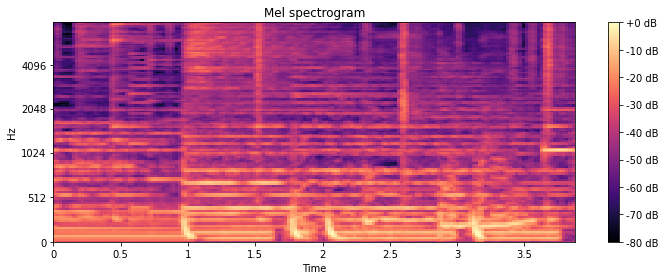

In [7]:
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

y, sr = librosa.load('/content/demo/annar_3_05_src1.wav',sr=16000)
# 方法一：使用时间序列求Mel频谱
print(librosa.feature.melspectrogram(y=y, sr=sr))
# array([[  2.891e-07,   2.548e-03, ...,   8.116e-09,   5.633e-09],
#        [  1.986e-07,   1.162e-02, ...,   9.332e-08,   6.716e-09],
#        ...,
#        [  3.668e-09,   2.029e-08, ...,   3.208e-09,   2.864e-09],
#        [  2.561e-10,   2.096e-09, ...,   7.543e-10,   6.101e-10]])

# 方法二：使用stft频谱求Mel频谱
D = np.abs(librosa.stft(y)) ** 2  # stft频谱
S = librosa.feature.melspectrogram(S=D)  # 使用stft频谱求Mel频谱

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

[[2.20096268e-02 9.76366651e-03 4.22880711e-03 ... 4.70722705e-07
  2.35145424e-05 9.01044531e-05]
 [1.35204259e-02 6.93805727e-03 5.38793168e-03 ... 3.03823937e-05
  2.41928850e-04 7.37039340e-04]
 [3.24914604e-02 2.67512432e-02 1.70533820e-02 ... 8.76149702e-05
  8.46169317e-04 2.49785839e-03]
 ...
 [1.93567481e-05 4.13278522e-05 1.42690895e-05 ... 6.94539957e-09
  2.38805780e-07 9.09035685e-07]
 [1.27290966e-05 2.23352834e-05 7.49029698e-06 ... 9.22289140e-09
  2.34771052e-07 9.08079642e-07]
 [1.21208405e-06 1.48827062e-06 4.08880649e-07 ... 7.51051167e-09
  2.40782215e-07 9.41518442e-07]]


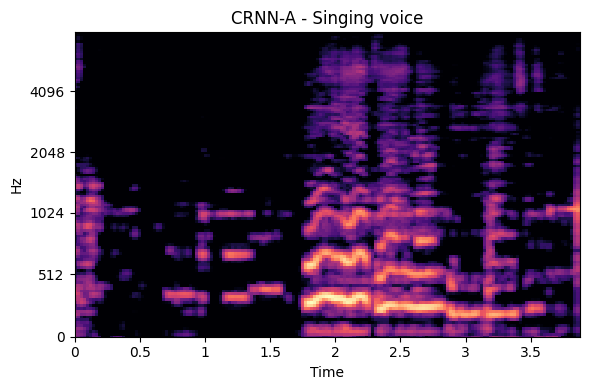

In [29]:
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

y, sr = librosa.load('/content/demo/annar_3_05_src2.wav',sr=16000)
# 方法一：使用时间序列求Mel频谱
print(librosa.feature.melspectrogram(y=y, sr=sr))
# array([[  2.891e-07,   2.548e-03, ...,   8.116e-09,   5.633e-09],
#        [  1.986e-07,   1.162e-02, ...,   9.332e-08,   6.716e-09],
#        ...,
#        [  3.668e-09,   2.029e-08, ...,   3.208e-09,   2.864e-09],
#        [  2.561e-10,   2.096e-09, ...,   7.543e-10,   6.101e-10]])

# 方法二：使用stft频谱求Mel频谱
D = np.abs(librosa.stft(y)) ** 2  # stft频谱
S = librosa.feature.melspectrogram(S=D)  # 使用stft频谱求Mel频谱

plt.figure(dpi=100)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
# plt.colorbar(format='%+2.0f dB')
plt.title('CRNN-A - Singing voice')
plt.tight_layout()
plt.show()

Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

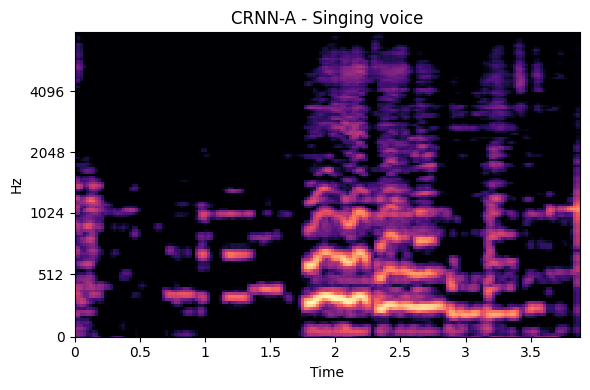

In [2]:
import librosa
import os
import numpy as np
import tensorflow as tf
from mir_eval.separation import bss_eval_sources
import librosa.display
import matplotlib.pyplot as plt
from preprocess import load_wavs, prepare_data_full, wavs_to_specs, sperate_magnitude_phase, combine_magnitdue_phase
from gamma_5_hop2r16 import SVSRNN


mir1k_sr = 16000
n_fft = 1024
hop_length = n_fft // 4
num_rnn_layer = 3
num_hidden_units = [1024, 1024, 1024]
tensorboard_directory = 'graphs/svsrnn'
clear_tensorboard = False
# model_directory = '/content/drive/My Drive/model-attention-aaa'
model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_5_hop2r16'
model_filename = 'svsrnn.ckpt'
model_filepath = os.path.join(model_directory, model_filename)

mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
test_path = '/content/test-825-colab.txt'

with open(test_path, 'r') as text_file:
    content = text_file.readlines()
wav_filenames = [file.strip() for file in content]

# wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
output_directory = 'demo'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames=wav_filenames, sr=mir1k_sr)

stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
    wavs_mono=wavs_mono, wavs_src1=wavs_src1, wavs_src2=wavs_src2, n_fft=n_fft, hop_length=hop_length)

stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono=stfts_mono, stfts_src1=stfts_src1,
                                                                      stfts_src2=stfts_src2)

model = SVSRNN(num_features=n_fft // 2 + 1, num_rnn_layer=num_rnn_layer, num_hidden_units=num_hidden_units,
               tensorboard_directory=tensorboard_directory, clear_tensorboard=clear_tensorboard)
model.load(filepath=model_filepath)

for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):
    if wav_filename == '/content/drive/My Drive/MIR-1K/Wavfile/annar_3_05.wav':
        wav_filename_dir = os.path.dirname(wav_filename)
        wav_filename_base = os.path.basename(wav_filename)
        wav_mono_filename = wav_filename_base.split('.')[0] + '_mono.wav'
        wav_src1_hat_filename = wav_filename_base.split('.')[0] + '_src1.wav'
        wav_src2_hat_filename = wav_filename_base.split('.')[0] + '_src2.wav'
        wav_mono_filepath = os.path.join(output_directory, wav_mono_filename)
        wav_src1_hat_filepath = os.path.join(output_directory, wav_src1_hat_filename)
        wav_src2_hat_filepath = os.path.join(output_directory, wav_src2_hat_filename)

        print('Processing %s ...' % wav_filename_base)

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(
            data=stft_mono_full)  # stft_mono_magnitude:(1,4681,513)  #stft_mono_phase:(4681,513)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x=stft_mono_magnitude)  # y1_pred:(1,10,513)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes=y1_pred[0], phases=stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes=y2_pred[0], phases=stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length=hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length=hop_length)

        D = np.abs(librosa.stft(y2_hat)) ** 2  # stft频谱
        S = librosa.feature.melspectrogram(S=D)  # 使用stft频谱求Mel频谱

        plt.figure(dpi=100)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                                 y_axis='mel', fmax=8000, x_axis='time')
        # plt.colorbar(format='%+2.0f dB')
        plt.title('CRNN-A - Singing voice')
        plt.tight_layout()
        plt.show()



Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

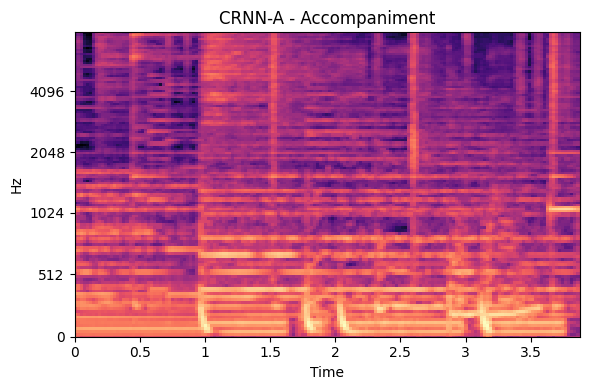

In [2]:
import librosa
import os
import numpy as np
import tensorflow as tf
from mir_eval.separation import bss_eval_sources
import librosa.display
import matplotlib.pyplot as plt
from preprocess import load_wavs, prepare_data_full, wavs_to_specs, sperate_magnitude_phase, combine_magnitdue_phase
from gamma_5_hop2r16 import SVSRNN


mir1k_sr = 16000
n_fft = 1024
hop_length = n_fft // 4
num_rnn_layer = 3
num_hidden_units = [1024, 1024, 1024]
tensorboard_directory = 'graphs/svsrnn'
clear_tensorboard = False
# model_directory = '/content/drive/My Drive/model-attention-aaa'
model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_5_hop2r16'
model_filename = 'svsrnn.ckpt'
model_filepath = os.path.join(model_directory, model_filename)

mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
test_path = '/content/test-825-colab.txt'

with open(test_path, 'r') as text_file:
    content = text_file.readlines()
wav_filenames = [file.strip() for file in content]

# wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
output_directory = 'demo'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames=wav_filenames, sr=mir1k_sr)

stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
    wavs_mono=wavs_mono, wavs_src1=wavs_src1, wavs_src2=wavs_src2, n_fft=n_fft, hop_length=hop_length)

stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono=stfts_mono, stfts_src1=stfts_src1,
                                                                      stfts_src2=stfts_src2)

model = SVSRNN(num_features=n_fft // 2 + 1, num_rnn_layer=num_rnn_layer, num_hidden_units=num_hidden_units,
               tensorboard_directory=tensorboard_directory, clear_tensorboard=clear_tensorboard)
model.load(filepath=model_filepath)

for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):
    if wav_filename == '/content/drive/My Drive/MIR-1K/Wavfile/annar_3_05.wav':
        wav_filename_dir = os.path.dirname(wav_filename)
        wav_filename_base = os.path.basename(wav_filename)
        wav_mono_filename = wav_filename_base.split('.')[0] + '_mono.wav'
        wav_src1_hat_filename = wav_filename_base.split('.')[0] + '_src1.wav'
        wav_src2_hat_filename = wav_filename_base.split('.')[0] + '_src2.wav'
        wav_mono_filepath = os.path.join(output_directory, wav_mono_filename)
        wav_src1_hat_filepath = os.path.join(output_directory, wav_src1_hat_filename)
        wav_src2_hat_filepath = os.path.join(output_directory, wav_src2_hat_filename)

        print('Processing %s ...' % wav_filename_base)

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(
            data=stft_mono_full)  # stft_mono_magnitude:(1,4681,513)  #stft_mono_phase:(4681,513)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x=stft_mono_magnitude)  # y1_pred:(1,10,513)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes=y1_pred[0], phases=stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes=y2_pred[0], phases=stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length=hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length=hop_length)

        D = np.abs(librosa.stft(y1_hat)) ** 2  # stft频谱
        S = librosa.feature.melspectrogram(S=D)  # 使用stft频谱求Mel频谱

        plt.figure(dpi=100)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                                 y_axis='mel', fmax=8000, x_axis='time')
        # plt.colorbar(format='%+2.0f dB')
        plt.title('CRNN-A - Accompaniment')
        plt.tight_layout()
        plt.show()



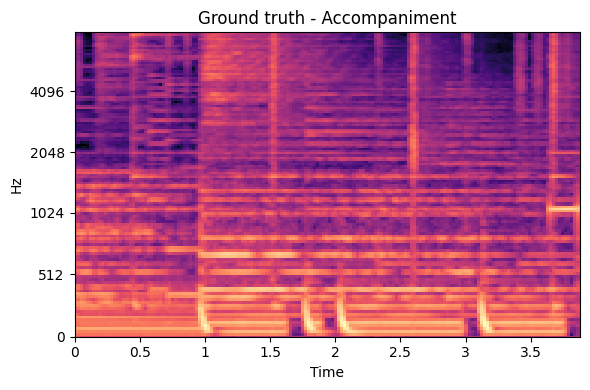

In [28]:
import librosa.display
import numpy as np
import matplotlib.pyplot as plt


wav, _ = librosa.load('/content/drive/My Drive/MIR-1K/Wavfile/annar_3_05.wav', sr = 16000, mono = False)
assert (wav.ndim == 2) and (wav.shape[0] == 2), 'Require wav to have two channels'
wav_mono = librosa.to_mono(wav) * 2 # Cancelling average
wav_src1 = wav[0, :]
wav_src2 = wav[1, :]

# y, sr = librosa.load(wav_src1,sr=16000)
# # 方法一：使用时间序列求Mel频谱
# print(librosa.feature.melspectrogram(y=y, sr=sr))
# array([[  2.891e-07,   2.548e-03, ...,   8.116e-09,   5.633e-09],
#        [  1.986e-07,   1.162e-02, ...,   9.332e-08,   6.716e-09],
#        ...,
#        [  3.668e-09,   2.029e-08, ...,   3.208e-09,   2.864e-09],
#        [  2.561e-10,   2.096e-09, ...,   7.543e-10,   6.101e-10]])

# 方法二：使用stft频谱求Mel频谱
D = np.abs(librosa.stft(wav_src1)) ** 2  # stft频谱
S = librosa.feature.melspectrogram(S=D)  # 使用stft频谱求Mel频谱

plt.figure(dpi=100)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
# plt.colorbar(format='%+2.0f dB')
plt.title('Ground truth - Accompaniment')
plt.tight_layout()
plt.show()


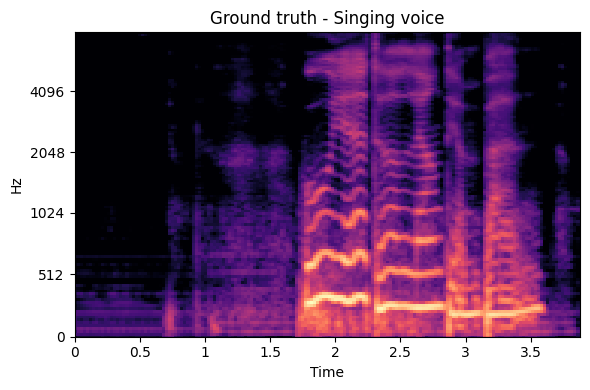

In [27]:
import librosa.display
import numpy as np
import matplotlib.pyplot as plt


wav, _ = librosa.load('/content/drive/My Drive/MIR-1K/Wavfile/annar_3_05.wav', sr = 16000, mono = False)
assert (wav.ndim == 2) and (wav.shape[0] == 2), 'Require wav to have two channels'
wav_mono = librosa.to_mono(wav) * 2 # Cancelling average
wav_src1 = wav[0, :]
wav_src2 = wav[1, :]

# y, sr = librosa.load(wav_src1,sr=16000)
# # 方法一：使用时间序列求Mel频谱
# print(librosa.feature.melspectrogram(y=y, sr=sr))
# array([[  2.891e-07,   2.548e-03, ...,   8.116e-09,   5.633e-09],
#        [  1.986e-07,   1.162e-02, ...,   9.332e-08,   6.716e-09],
#        ...,
#        [  3.668e-09,   2.029e-08, ...,   3.208e-09,   2.864e-09],
#        [  2.561e-10,   2.096e-09, ...,   7.543e-10,   6.101e-10]])

# 方法二：使用stft频谱求Mel频谱
D = np.abs(librosa.stft(wav_src2)) ** 2  # stft频谱
S = librosa.feature.melspectrogram(S=D)  # 使用stft频谱求Mel频谱

plt.figure(dpi=100)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
# plt.colorbar(format='%+2.0f dB')
plt.title('Ground truth - Singing voice')
plt.tight_layout()
# plt.savefig('Groundtruth-Singingvoice.png',dpi=400)
plt.show()


In [2]:
from preprocess import get_random_wav_batch, load_wavs, wavs_to_specs, sample_data_batch, sperate_magnitude_phase
from gamma_5_hop2r32 import SVSRNN
import tqdm

import os
import librosa
import numpy as np


def train(random_seed = 0):

    np.random.seed(random_seed)

    # Download MIR1K dataset
    # download_dir = 'download'
    # data_dir = 'data'
    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'

    train_path = '/content/train-175.txt'
    # valid_path = os.path.join(mir1k_dir, 'valid.txt')
    #mir1k_dir = download_mir1k(download_dir = download_dir, data_dir = data_dir)
    #wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/UndividedWavfile')
    #wavs_dir = os.path.join(mir1k_dir, 'MIR-1K/Wavfile')

    with open(train_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames_train = [file.strip() for file in content] 

    # with open(valid_path, 'r') as text_file:
    #     content = text_file.readlines()
    # wav_filenames_valid = [file.strip() for file in content]

    # Preprocess parameters
    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    # Model parameters
    learning_rate = 0.0001
    num_rnn_layer = 3
    num_hidden_units = [1024, 1024, 1024]
    batch_size = 64
    sample_frames = 10   #?????????????
    iterations = 20000 #50000
    tensorboard_directory = './graphs/svsrnn'
    log_directory = './log'
    train_log_filename = 'train_log.csv'   #用来画iteration-LOSS曲线
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_5_hop2r32'
    model_filename = 'svsrnn.ckpt'

    if not os.path.exists(log_directory):
        os.makedirs(log_directory)
    open(os.path.join(log_directory, train_log_filename), 'w').close()
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)
    # Load train wavs
    wavs_mono_train, wavs_src1_train, wavs_src2_train = load_wavs(filenames = wav_filenames_train, sr = mir1k_sr)

    # Turn waves to spectrums !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    stfts_mono_train, stfts_src1_train, stfts_src2_train = wavs_to_specs(   #stfts_mono_train: len:88 shape:(513,3537)  (513,5765) ...
        wavs_mono = wavs_mono_train, wavs_src1 = wavs_src1_train, wavs_src2 = wavs_src2_train, n_fft = n_fft, hop_length = hop_length)


    # wavs_mono_valid, wavs_src1_valid, wavs_src2_valid = load_wavs(filenames = wav_filenames_valid, sr = mir1k_sr)
    # stfts_mono_valid, stfts_src1_valid, stfts_src2_valid = wavs_to_specs(
    #     wavs_mono = wavs_mono_valid, wavs_src1 = wavs_src1_valid, wavs_src2 = wavs_src2_valid, n_fft = n_fft, hop_length = hop_length)


    # Initialize model
    model =  SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)

    # Start training
    for i in tqdm.tqdm(range(iterations)):
        
        data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
            stfts_mono = stfts_mono_train, stfts_src1 = stfts_src1_train, stfts_src2 = stfts_src2_train, batch_size = batch_size, sample_frames = sample_frames)
        x_mixed, _ = sperate_magnitude_phase(data = data_mono_batch)   #<class 'tuple'>: (64, 10, 513)
        y1, _ = sperate_magnitude_phase(data = data_src1_batch)
        y2, _ = sperate_magnitude_phase(data = data_src2_batch)

        train_loss = model.train(x = x_mixed, y1 = y1, y2 = y2, learning_rate = learning_rate)

        if i % 100 == 0:
            print('Step: %d Train Loss: %f' %(i, train_loss))

        # if i % 200 == 0:
        #     print('==============================================')
        #     # data_mono_batch, data_src1_batch, data_src2_batch = sample_data_batch(
        #     #     stfts_mono = stfts_mono_valid, stfts_src1 = stfts_src1_valid, stfts_src2 = stfts_src2_valid, batch_size = batch_size, sample_frames = sample_frames)
        #     x_mixed, _ = sperate_magnitude_phase(data = data_mono_batch)   #(64,10,513)
        #     y1, _ = sperate_magnitude_phase(data = data_src1_batch)
        #     y2, _ = sperate_magnitude_phase(data = data_src2_batch)
        #
        #     y1_pred, y2_pred, validation_loss = model.validate(x = x_mixed, y1 = y1, y2 = y2)
        #     print('Step: %d Validation Loss: %f' %(i, validation_loss))
        #     print('==============================================')
        #
        #     with open(os.path.join(log_directory, train_log_filename), 'a') as log_file:
        #         log_file.write('{},{},{}\n'.format(i, train_loss, validation_loss))
        

        if i % 1000 == 0:
            model.save(directory = model_directory, filename = model_filename)



if __name__ == '__main__':
    
    train()


Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst

  0%|          | 0/20000 [00:00<?, ?it/s]

Step: 0 Train Loss: 10.054590


  1%|          | 101/20000 [00:48<2:02:09,  2.71it/s]

Step: 100 Train Loss: 2.129336


  1%|          | 201/20000 [01:25<2:01:30,  2.72it/s]

Step: 200 Train Loss: 1.668820


  2%|▏         | 301/20000 [02:02<2:01:03,  2.71it/s]

Step: 300 Train Loss: 1.231038


  2%|▏         | 401/20000 [02:39<2:00:43,  2.71it/s]

Step: 400 Train Loss: 1.479292


  3%|▎         | 501/20000 [03:15<1:59:39,  2.72it/s]

Step: 500 Train Loss: 1.279012


  3%|▎         | 601/20000 [03:52<1:59:06,  2.71it/s]

Step: 600 Train Loss: 1.020647


  4%|▎         | 701/20000 [04:29<1:58:43,  2.71it/s]

Step: 700 Train Loss: 0.832652


  4%|▍         | 801/20000 [05:06<1:58:06,  2.71it/s]

Step: 800 Train Loss: 1.096386


  5%|▍         | 901/20000 [05:43<1:57:09,  2.72it/s]

Step: 900 Train Loss: 0.617569


  5%|▌         | 1000/20000 [06:19<1:56:11,  2.73it/s]

Step: 1000 Train Loss: 0.935805


  6%|▌         | 1101/20000 [07:03<1:59:03,  2.65it/s]

Step: 1100 Train Loss: 0.871031


  6%|▌         | 1201/20000 [07:40<1:55:43,  2.71it/s]

Step: 1200 Train Loss: 0.871854


  7%|▋         | 1301/20000 [08:17<1:54:41,  2.72it/s]

Step: 1300 Train Loss: 1.096316


  7%|▋         | 1401/20000 [08:54<1:54:34,  2.71it/s]

Step: 1400 Train Loss: 0.546911


  8%|▊         | 1501/20000 [09:31<1:53:19,  2.72it/s]

Step: 1500 Train Loss: 0.536707


  8%|▊         | 1601/20000 [10:08<1:53:09,  2.71it/s]

Step: 1600 Train Loss: 0.872413


  9%|▊         | 1701/20000 [10:45<1:52:59,  2.70it/s]

Step: 1700 Train Loss: 0.498032


  9%|▉         | 1801/20000 [11:22<1:51:30,  2.72it/s]

Step: 1800 Train Loss: 0.462279


 10%|▉         | 1901/20000 [11:59<1:52:36,  2.68it/s]

Step: 1900 Train Loss: 0.514527


 10%|█         | 2000/20000 [12:35<1:50:08,  2.72it/s]

Step: 2000 Train Loss: 0.394468


 11%|█         | 2101/20000 [13:18<1:49:46,  2.72it/s]

Step: 2100 Train Loss: 0.387517


 11%|█         | 2201/20000 [13:55<1:49:27,  2.71it/s]

Step: 2200 Train Loss: 0.442928


 12%|█▏        | 2301/20000 [14:32<1:49:03,  2.70it/s]

Step: 2300 Train Loss: 0.397628


 12%|█▏        | 2401/20000 [15:08<1:48:47,  2.70it/s]

Step: 2400 Train Loss: 0.471324


 13%|█▎        | 2501/20000 [15:45<1:47:01,  2.73it/s]

Step: 2500 Train Loss: 0.346216


 13%|█▎        | 2601/20000 [16:22<1:46:52,  2.71it/s]

Step: 2600 Train Loss: 0.410187


 14%|█▎        | 2701/20000 [16:59<1:45:57,  2.72it/s]

Step: 2700 Train Loss: 0.308326


 14%|█▍        | 2801/20000 [17:36<1:47:37,  2.66it/s]

Step: 2800 Train Loss: 0.367059


 15%|█▍        | 2901/20000 [18:13<1:45:15,  2.71it/s]

Step: 2900 Train Loss: 0.324215


 15%|█▌        | 3000/20000 [18:49<1:44:02,  2.72it/s]

Step: 3000 Train Loss: 0.481114


 16%|█▌        | 3101/20000 [19:32<1:43:52,  2.71it/s]

Step: 3100 Train Loss: 0.351240


 16%|█▌        | 3201/20000 [20:08<1:43:00,  2.72it/s]

Step: 3200 Train Loss: 0.349260


 17%|█▋        | 3301/20000 [20:45<1:42:41,  2.71it/s]

Step: 3300 Train Loss: 0.402059


 17%|█▋        | 3401/20000 [21:22<1:41:38,  2.72it/s]

Step: 3400 Train Loss: 0.289766


 18%|█▊        | 3501/20000 [21:59<1:41:15,  2.72it/s]

Step: 3500 Train Loss: 0.506888


 18%|█▊        | 3601/20000 [22:36<1:40:45,  2.71it/s]

Step: 3600 Train Loss: 0.298792


 19%|█▊        | 3701/20000 [23:13<1:40:16,  2.71it/s]

Step: 3700 Train Loss: 0.358900


 19%|█▉        | 3801/20000 [23:49<1:39:10,  2.72it/s]

Step: 3800 Train Loss: 0.472910


 20%|█▉        | 3901/20000 [24:26<1:38:42,  2.72it/s]

Step: 3900 Train Loss: 0.391840


 20%|██        | 4000/20000 [25:03<1:38:07,  2.72it/s]

Step: 4000 Train Loss: 0.360682


 21%|██        | 4101/20000 [25:45<1:37:52,  2.71it/s]

Step: 4100 Train Loss: 0.328821


 21%|██        | 4201/20000 [26:22<1:37:19,  2.71it/s]

Step: 4200 Train Loss: 0.350795


 22%|██▏       | 4301/20000 [26:59<1:37:15,  2.69it/s]

Step: 4300 Train Loss: 0.355599


 22%|██▏       | 4401/20000 [27:36<1:36:07,  2.70it/s]

Step: 4400 Train Loss: 0.430249


 23%|██▎       | 4501/20000 [28:13<1:34:49,  2.72it/s]

Step: 4500 Train Loss: 0.337162


 23%|██▎       | 4601/20000 [28:49<1:34:07,  2.73it/s]

Step: 4600 Train Loss: 0.421830


 24%|██▎       | 4701/20000 [29:26<1:34:10,  2.71it/s]

Step: 4700 Train Loss: 0.359702


 24%|██▍       | 4801/20000 [30:03<1:33:24,  2.71it/s]

Step: 4800 Train Loss: 0.306971


 25%|██▍       | 4901/20000 [30:40<1:32:43,  2.71it/s]

Step: 4900 Train Loss: 0.280393


 25%|██▌       | 5000/20000 [31:16<1:31:54,  2.72it/s]

Step: 5000 Train Loss: 0.281905


 26%|██▌       | 5101/20000 [32:01<1:32:46,  2.68it/s]

Step: 5100 Train Loss: 0.351558


 26%|██▌       | 5201/20000 [32:38<1:31:07,  2.71it/s]

Step: 5200 Train Loss: 0.307306


 27%|██▋       | 5301/20000 [33:14<1:30:12,  2.72it/s]

Step: 5300 Train Loss: 0.233622


 27%|██▋       | 5401/20000 [33:51<1:29:30,  2.72it/s]

Step: 5400 Train Loss: 0.245352


 28%|██▊       | 5501/20000 [34:28<1:28:56,  2.72it/s]

Step: 5500 Train Loss: 0.323353


 28%|██▊       | 5601/20000 [35:05<1:28:12,  2.72it/s]

Step: 5600 Train Loss: 0.228412


 29%|██▊       | 5701/20000 [35:42<1:27:36,  2.72it/s]

Step: 5700 Train Loss: 0.293388


 29%|██▉       | 5801/20000 [36:18<1:27:30,  2.70it/s]

Step: 5800 Train Loss: 0.259096


 30%|██▉       | 5901/20000 [36:55<1:26:27,  2.72it/s]

Step: 5900 Train Loss: 0.285165


 30%|███       | 6000/20000 [37:32<1:25:36,  2.73it/s]

Step: 6000 Train Loss: 0.337566


 31%|███       | 6101/20000 [38:15<1:27:02,  2.66it/s]

Step: 6100 Train Loss: 0.267697


 31%|███       | 6201/20000 [38:52<1:24:21,  2.73it/s]

Step: 6200 Train Loss: 0.220101


 32%|███▏      | 6301/20000 [39:29<1:23:50,  2.72it/s]

Step: 6300 Train Loss: 0.284115


 32%|███▏      | 6401/20000 [40:06<1:23:19,  2.72it/s]

Step: 6400 Train Loss: 0.225692


 33%|███▎      | 6501/20000 [40:42<1:22:33,  2.73it/s]

Step: 6500 Train Loss: 0.231493


 33%|███▎      | 6601/20000 [41:19<1:21:59,  2.72it/s]

Step: 6600 Train Loss: 0.284518


 34%|███▎      | 6701/20000 [41:56<1:21:30,  2.72it/s]

Step: 6700 Train Loss: 0.253131


 34%|███▍      | 6801/20000 [42:33<1:20:39,  2.73it/s]

Step: 6800 Train Loss: 0.215123


 35%|███▍      | 6901/20000 [43:10<1:20:11,  2.72it/s]

Step: 6900 Train Loss: 0.303407


 35%|███▌      | 7000/20000 [43:46<1:19:46,  2.72it/s]

Step: 7000 Train Loss: 0.271048


 36%|███▌      | 7101/20000 [44:30<1:19:13,  2.71it/s]

Step: 7100 Train Loss: 0.273932


 36%|███▌      | 7201/20000 [45:07<1:18:33,  2.72it/s]

Step: 7200 Train Loss: 0.280578


 37%|███▋      | 7301/20000 [45:43<1:17:54,  2.72it/s]

Step: 7300 Train Loss: 0.267386


 37%|███▋      | 7401/20000 [46:20<1:16:58,  2.73it/s]

Step: 7400 Train Loss: 0.269568


 38%|███▊      | 7501/20000 [46:57<1:16:28,  2.72it/s]

Step: 7500 Train Loss: 0.440849


 38%|███▊      | 7601/20000 [47:34<1:15:53,  2.72it/s]

Step: 7600 Train Loss: 0.257065


 39%|███▊      | 7701/20000 [48:11<1:15:15,  2.72it/s]

Step: 7700 Train Loss: 0.346340


 39%|███▉      | 7801/20000 [48:47<1:15:05,  2.71it/s]

Step: 7800 Train Loss: 0.240666


 40%|███▉      | 7901/20000 [49:24<1:14:11,  2.72it/s]

Step: 7900 Train Loss: 0.214367


 40%|████      | 8000/20000 [50:01<1:13:42,  2.71it/s]

Step: 8000 Train Loss: 0.332659


 41%|████      | 8101/20000 [50:43<1:12:48,  2.72it/s]

Step: 8100 Train Loss: 0.228944


 41%|████      | 8201/20000 [51:20<1:12:26,  2.71it/s]

Step: 8200 Train Loss: 0.312952


 42%|████▏     | 8301/20000 [51:57<1:11:36,  2.72it/s]

Step: 8300 Train Loss: 0.226448


 42%|████▏     | 8401/20000 [52:33<1:10:55,  2.73it/s]

Step: 8400 Train Loss: 0.230577


 43%|████▎     | 8501/20000 [53:10<1:10:25,  2.72it/s]

Step: 8500 Train Loss: 0.276180


 43%|████▎     | 8601/20000 [53:47<1:09:48,  2.72it/s]

Step: 8600 Train Loss: 0.298501


 44%|████▎     | 8701/20000 [54:24<1:09:08,  2.72it/s]

Step: 8700 Train Loss: 0.254729


 44%|████▍     | 8801/20000 [55:00<1:08:32,  2.72it/s]

Step: 8800 Train Loss: 0.226789


 45%|████▍     | 8901/20000 [55:37<1:07:50,  2.73it/s]

Step: 8900 Train Loss: 0.315457


 45%|████▌     | 9000/20000 [56:14<1:07:21,  2.72it/s]

Step: 9000 Train Loss: 0.261829


 46%|████▌     | 9101/20000 [56:56<1:07:09,  2.70it/s]

Step: 9100 Train Loss: 0.222811


 46%|████▌     | 9201/20000 [57:33<1:06:43,  2.70it/s]

Step: 9200 Train Loss: 0.197976


 47%|████▋     | 9301/20000 [58:10<1:05:47,  2.71it/s]

Step: 9300 Train Loss: 0.161393


 47%|████▋     | 9401/20000 [58:47<1:04:58,  2.72it/s]

Step: 9400 Train Loss: 0.240225


 48%|████▊     | 9501/20000 [59:23<1:04:32,  2.71it/s]

Step: 9500 Train Loss: 0.281526


 48%|████▊     | 9601/20000 [1:00:00<1:03:32,  2.73it/s]

Step: 9600 Train Loss: 0.260726


 49%|████▊     | 9701/20000 [1:00:37<1:03:20,  2.71it/s]

Step: 9700 Train Loss: 0.154092


 49%|████▉     | 9801/20000 [1:01:14<1:02:31,  2.72it/s]

Step: 9800 Train Loss: 0.288999


 50%|████▉     | 9901/20000 [1:01:50<1:01:50,  2.72it/s]

Step: 9900 Train Loss: 0.253366


 50%|█████     | 10000/20000 [1:02:27<1:01:14,  2.72it/s]

Step: 10000 Train Loss: 0.242188


 51%|█████     | 10101/20000 [1:03:09<1:00:39,  2.72it/s]

Step: 10100 Train Loss: 0.247648


 51%|█████     | 10201/20000 [1:03:46<1:00:06,  2.72it/s]

Step: 10200 Train Loss: 0.305800


 52%|█████▏    | 10301/20000 [1:04:23<59:20,  2.72it/s]

Step: 10300 Train Loss: 0.201515


 52%|█████▏    | 10401/20000 [1:05:00<58:41,  2.73it/s]

Step: 10400 Train Loss: 0.178926


 53%|█████▎    | 10501/20000 [1:05:36<58:10,  2.72it/s]

Step: 10500 Train Loss: 0.323063


 53%|█████▎    | 10601/20000 [1:06:13<57:49,  2.71it/s]

Step: 10600 Train Loss: 0.209822


 54%|█████▎    | 10701/20000 [1:06:50<56:52,  2.72it/s]

Step: 10700 Train Loss: 0.240180


 54%|█████▍    | 10801/20000 [1:07:27<56:54,  2.69it/s]

Step: 10800 Train Loss: 0.306596


 55%|█████▍    | 10901/20000 [1:08:04<55:48,  2.72it/s]

Step: 10900 Train Loss: 0.254817


 55%|█████▌    | 11000/20000 [1:08:40<55:13,  2.72it/s]

Step: 11000 Train Loss: 0.328290


 56%|█████▌    | 11101/20000 [1:09:23<54:25,  2.73it/s]

Step: 11100 Train Loss: 0.374978


 56%|█████▌    | 11201/20000 [1:09:59<53:48,  2.73it/s]

Step: 11200 Train Loss: 0.222683


 57%|█████▋    | 11301/20000 [1:10:36<53:08,  2.73it/s]

Step: 11300 Train Loss: 0.267189


 57%|█████▋    | 11401/20000 [1:11:13<52:45,  2.72it/s]

Step: 11400 Train Loss: 0.245881


 58%|█████▊    | 11501/20000 [1:11:50<51:58,  2.73it/s]

Step: 11500 Train Loss: 0.199941


 58%|█████▊    | 11601/20000 [1:12:27<51:36,  2.71it/s]

Step: 11600 Train Loss: 0.236592


 59%|█████▊    | 11701/20000 [1:13:03<50:50,  2.72it/s]

Step: 11700 Train Loss: 0.258085


 59%|█████▉    | 11801/20000 [1:13:40<50:38,  2.70it/s]

Step: 11800 Train Loss: 0.194669


 60%|█████▉    | 11901/20000 [1:14:18<49:40,  2.72it/s]

Step: 11900 Train Loss: 0.340665


 60%|██████    | 12000/20000 [1:14:54<49:09,  2.71it/s]

Step: 12000 Train Loss: 0.247802


 61%|██████    | 12101/20000 [1:15:36<48:20,  2.72it/s]

Step: 12100 Train Loss: 0.279845


 61%|██████    | 12201/20000 [1:16:13<47:53,  2.71it/s]

Step: 12200 Train Loss: 0.171506


 62%|██████▏   | 12301/20000 [1:16:50<47:18,  2.71it/s]

Step: 12300 Train Loss: 0.215175


 62%|██████▏   | 12401/20000 [1:17:27<46:34,  2.72it/s]

Step: 12400 Train Loss: 0.187215


 63%|██████▎   | 12501/20000 [1:18:04<46:29,  2.69it/s]

Step: 12500 Train Loss: 0.216227


 63%|██████▎   | 12601/20000 [1:18:41<45:31,  2.71it/s]

Step: 12600 Train Loss: 0.258628


 64%|██████▎   | 12701/20000 [1:19:17<44:49,  2.71it/s]

Step: 12700 Train Loss: 0.211479


 64%|██████▍   | 12801/20000 [1:19:54<44:03,  2.72it/s]

Step: 12800 Train Loss: 0.209000


 65%|██████▍   | 12901/20000 [1:20:31<43:40,  2.71it/s]

Step: 12900 Train Loss: 0.243015


 65%|██████▌   | 13000/20000 [1:21:07<43:07,  2.71it/s]

Step: 13000 Train Loss: 0.263884


 66%|██████▌   | 13101/20000 [1:21:50<42:32,  2.70it/s]

Step: 13100 Train Loss: 0.237833


 66%|██████▌   | 13201/20000 [1:22:27<41:38,  2.72it/s]

Step: 13200 Train Loss: 0.181549


 67%|██████▋   | 13301/20000 [1:23:03<41:03,  2.72it/s]

Step: 13300 Train Loss: 0.227292


 67%|██████▋   | 13401/20000 [1:23:40<40:31,  2.71it/s]

Step: 13400 Train Loss: 0.215849


 68%|██████▊   | 13501/20000 [1:24:17<39:52,  2.72it/s]

Step: 13500 Train Loss: 0.248118


 68%|██████▊   | 13601/20000 [1:24:54<39:21,  2.71it/s]

Step: 13600 Train Loss: 0.243590


 69%|██████▊   | 13701/20000 [1:25:31<38:41,  2.71it/s]

Step: 13700 Train Loss: 0.250379


 69%|██████▉   | 13801/20000 [1:26:08<38:19,  2.70it/s]

Step: 13800 Train Loss: 0.257767


 70%|██████▉   | 13901/20000 [1:26:45<37:24,  2.72it/s]

Step: 13900 Train Loss: 0.292869


 70%|███████   | 14000/20000 [1:27:21<36:42,  2.72it/s]

Step: 14000 Train Loss: 0.273820


 71%|███████   | 14101/20000 [1:28:03<36:25,  2.70it/s]

Step: 14100 Train Loss: 0.286134


 71%|███████   | 14201/20000 [1:28:40<35:37,  2.71it/s]

Step: 14200 Train Loss: 0.159205


 72%|███████▏  | 14301/20000 [1:29:17<34:53,  2.72it/s]

Step: 14300 Train Loss: 0.180893


 72%|███████▏  | 14401/20000 [1:29:54<34:20,  2.72it/s]

Step: 14400 Train Loss: 0.169354


 73%|███████▎  | 14501/20000 [1:30:31<33:36,  2.73it/s]

Step: 14500 Train Loss: 0.218884


 73%|███████▎  | 14601/20000 [1:31:07<33:01,  2.72it/s]

Step: 14600 Train Loss: 0.228177


 74%|███████▎  | 14701/20000 [1:31:44<32:24,  2.73it/s]

Step: 14700 Train Loss: 0.192119


 74%|███████▍  | 14801/20000 [1:32:21<32:00,  2.71it/s]

Step: 14800 Train Loss: 0.310438


 75%|███████▍  | 14901/20000 [1:32:58<31:15,  2.72it/s]

Step: 14900 Train Loss: 0.195092


 75%|███████▌  | 15000/20000 [1:33:34<30:37,  2.72it/s]

Step: 15000 Train Loss: 0.249586


 76%|███████▌  | 15101/20000 [1:34:17<30:01,  2.72it/s]

Step: 15100 Train Loss: 0.179914


 76%|███████▌  | 15201/20000 [1:34:53<29:21,  2.72it/s]

Step: 15200 Train Loss: 0.211460


 77%|███████▋  | 15301/20000 [1:35:30<28:46,  2.72it/s]

Step: 15300 Train Loss: 0.205256


 77%|███████▋  | 15401/20000 [1:36:07<28:14,  2.71it/s]

Step: 15400 Train Loss: 0.189406


 78%|███████▊  | 15501/20000 [1:36:44<27:32,  2.72it/s]

Step: 15500 Train Loss: 0.251056


 78%|███████▊  | 15601/20000 [1:37:20<26:59,  2.72it/s]

Step: 15600 Train Loss: 0.256229


 79%|███████▊  | 15701/20000 [1:37:57<26:21,  2.72it/s]

Step: 15700 Train Loss: 0.214638


 79%|███████▉  | 15801/20000 [1:38:34<25:39,  2.73it/s]

Step: 15800 Train Loss: 0.314723


 80%|███████▉  | 15901/20000 [1:39:11<25:07,  2.72it/s]

Step: 15900 Train Loss: 0.284147


 80%|████████  | 16000/20000 [1:39:47<24:28,  2.72it/s]

Step: 16000 Train Loss: 0.202956


 81%|████████  | 16101/20000 [1:40:29<23:53,  2.72it/s]

Step: 16100 Train Loss: 0.195504


 81%|████████  | 16201/20000 [1:41:06<23:17,  2.72it/s]

Step: 16200 Train Loss: 0.173721


 82%|████████▏ | 16301/20000 [1:41:43<22:44,  2.71it/s]

Step: 16300 Train Loss: 0.256129


 82%|████████▏ | 16401/20000 [1:42:20<22:07,  2.71it/s]

Step: 16400 Train Loss: 0.208902


 83%|████████▎ | 16501/20000 [1:42:57<21:23,  2.73it/s]

Step: 16500 Train Loss: 0.257804


 83%|████████▎ | 16601/20000 [1:43:33<20:53,  2.71it/s]

Step: 16600 Train Loss: 0.225021


 84%|████████▎ | 16701/20000 [1:44:10<20:10,  2.73it/s]

Step: 16700 Train Loss: 0.261698


 84%|████████▍ | 16801/20000 [1:44:47<19:33,  2.73it/s]

Step: 16800 Train Loss: 0.219886


 85%|████████▍ | 16901/20000 [1:45:24<18:57,  2.72it/s]

Step: 16900 Train Loss: 0.351849


 85%|████████▌ | 17000/20000 [1:46:00<18:22,  2.72it/s]

Step: 17000 Train Loss: 0.246575


 86%|████████▌ | 17101/20000 [1:46:42<17:44,  2.72it/s]

Step: 17100 Train Loss: 0.199990


 86%|████████▌ | 17201/20000 [1:47:19<17:08,  2.72it/s]

Step: 17200 Train Loss: 0.255011


 87%|████████▋ | 17301/20000 [1:47:56<16:30,  2.72it/s]

Step: 17300 Train Loss: 0.209210


 87%|████████▋ | 17401/20000 [1:48:33<15:54,  2.72it/s]

Step: 17400 Train Loss: 0.226690


 88%|████████▊ | 17501/20000 [1:49:10<15:17,  2.72it/s]

Step: 17500 Train Loss: 0.212435


 88%|████████▊ | 17601/20000 [1:49:46<14:41,  2.72it/s]

Step: 17600 Train Loss: 0.158096


 89%|████████▊ | 17701/20000 [1:50:23<14:07,  2.71it/s]

Step: 17700 Train Loss: 0.224957


 89%|████████▉ | 17801/20000 [1:51:00<13:28,  2.72it/s]

Step: 17800 Train Loss: 0.219534


 90%|████████▉ | 17901/20000 [1:51:37<12:51,  2.72it/s]

Step: 17900 Train Loss: 0.224726


 90%|█████████ | 18000/20000 [1:52:13<12:13,  2.73it/s]

Step: 18000 Train Loss: 0.232185


 91%|█████████ | 18101/20000 [1:52:55<11:38,  2.72it/s]

Step: 18100 Train Loss: 0.302379


 91%|█████████ | 18201/20000 [1:53:32<11:00,  2.72it/s]

Step: 18200 Train Loss: 0.213705


 92%|█████████▏| 18301/20000 [1:54:09<10:23,  2.72it/s]

Step: 18300 Train Loss: 0.162460


 92%|█████████▏| 18401/20000 [1:54:46<09:49,  2.71it/s]

Step: 18400 Train Loss: 0.185806


 93%|█████████▎| 18501/20000 [1:55:22<09:10,  2.73it/s]

Step: 18500 Train Loss: 0.307193


 93%|█████████▎| 18601/20000 [1:55:59<08:32,  2.73it/s]

Step: 18600 Train Loss: 0.234349


 94%|█████████▎| 18701/20000 [1:56:36<07:57,  2.72it/s]

Step: 18700 Train Loss: 0.225341


 94%|█████████▍| 18801/20000 [1:57:13<07:20,  2.72it/s]

Step: 18800 Train Loss: 0.214335


 95%|█████████▍| 18901/20000 [1:57:50<06:44,  2.72it/s]

Step: 18900 Train Loss: 0.180414


 95%|█████████▌| 19000/20000 [1:58:26<06:10,  2.70it/s]

Step: 19000 Train Loss: 0.180954


 96%|█████████▌| 19101/20000 [1:59:08<05:33,  2.69it/s]

Step: 19100 Train Loss: 0.272356


 96%|█████████▌| 19201/20000 [1:59:45<04:54,  2.71it/s]

Step: 19200 Train Loss: 0.236601


 97%|█████████▋| 19301/20000 [2:00:22<04:19,  2.69it/s]

Step: 19300 Train Loss: 0.196855


 97%|█████████▋| 19401/20000 [2:00:59<03:40,  2.71it/s]

Step: 19400 Train Loss: 0.188598


 98%|█████████▊| 19501/20000 [2:01:35<03:04,  2.71it/s]

Step: 19500 Train Loss: 0.219198


 98%|█████████▊| 19601/20000 [2:02:12<02:27,  2.70it/s]

Step: 19600 Train Loss: 0.227824


 99%|█████████▊| 19701/20000 [2:02:49<01:49,  2.72it/s]

Step: 19700 Train Loss: 0.257669


 99%|█████████▉| 19801/20000 [2:03:26<01:13,  2.72it/s]

Step: 19800 Train Loss: 0.177579


100%|█████████▉| 19901/20000 [2:04:03<00:36,  2.72it/s]

Step: 19900 Train Loss: 0.273192


100%|██████████| 20000/20000 [2:04:39<00:00,  2.67it/s]


In [2]:
import librosa
import os
import numpy as np
import tensorflow as tf
from mir_eval.separation import bss_eval_sources

from preprocess import load_wavs, prepare_data_full, wavs_to_specs, sperate_magnitude_phase, combine_magnitdue_phase
from gamma_5_hop2r32 import SVSRNN

def generate_demo():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    # model_directory = '/content/drive/My Drive/model-attention-aaa'
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_5_hop2r32'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        wav_filename_dir = os.path.dirname(wav_filename)
        wav_filename_base = os.path.basename(wav_filename)
        wav_mono_filename = wav_filename_base.split('.')[0] + '_mono.wav'
        wav_src1_hat_filename = wav_filename_base.split('.')[0] + '_src1.wav'
        wav_src2_hat_filename = wav_filename_base.split('.')[0] + '_src2.wav'
        wav_mono_filepath = os.path.join(output_directory, wav_mono_filename)
        wav_src1_hat_filepath = os.path.join(output_directory, wav_src1_hat_filename)
        wav_src2_hat_filepath = os.path.join(output_directory, wav_src2_hat_filename)

        print('Processing %s ...' % wav_filename_base)

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)   #stft_mono_magnitude:(1,4681,513)  #stft_mono_phase:(4681,513)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)  #y1_pred:(1,10,513)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        librosa.output.write_wav(wav_mono_filepath, wav_mono, mir1k_sr)
        librosa.output.write_wav(wav_src1_hat_filepath, y1_hat, mir1k_sr)
        librosa.output.write_wav(wav_src2_hat_filepath, y2_hat, mir1k_sr)


def bss_eval_global(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):

    assert len(wavs_mono) == len(wavs_src1) == len(wavs_src2) == len(wavs_src1_pred) == len(wavs_src2_pred)

    num_samples = len(wavs_mono)

    gnsdr = np.zeros(2)
    gsir = np.zeros(2)
    gsar = np.zeros(2)
    frames_total = 0

    for wav_mono, wav_src1, wav_src2, wav_src1_pred, wav_src2_pred in zip(wavs_mono, wavs_src1, wavs_src2, wavs_src1_pred, wavs_src2_pred):
        len_cropped = wav_src1_pred.shape[-1]
        wav_mono_cropped = wav_mono[:len_cropped]
        wav_src1_cropped = wav_src1[:len_cropped]
        wav_src2_cropped = wav_src2[:len_cropped]

        sdr, sir, sar, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_src1_pred, wav_src2_pred]), compute_permutation = False)
        sdr_mono, _, _, _ = bss_eval_sources(reference_sources = np.asarray([wav_src1_cropped, wav_src2_cropped]), estimated_sources = np.asarray([wav_mono_cropped, wav_mono_cropped]), compute_permutation = False)

        nsdr = sdr - sdr_mono
        gnsdr += len_cropped * nsdr
        gsir += len_cropped * sir
        gsar += len_cropped * sar
        frames_total += len_cropped

    gnsdr = gnsdr / frames_total
    gsir = gsir / frames_total
    gsar = gsar / frames_total

    return gnsdr, gsir, gsar


def evaluate():

    mir1k_sr = 16000
    n_fft = 1024
    hop_length = n_fft // 4
    num_rnn_layer = 3
    num_hidden_units = [1024,1024,1024]
    tensorboard_directory = 'graphs/svsrnn'
    clear_tensorboard = False
    model_directory = '/content/drive/Shared drives/sun/crnn_model/model_jie_gamma_5_hop2r32'
    model_filename = 'svsrnn.ckpt'
    model_filepath = os.path.join(model_directory, model_filename)

    mir1k_dir = '/content/drive/My Drive/MIR-1K/Wavfile'
    test_path = '/content/test-825-colab.txt'

    with open(test_path, 'r') as text_file:
        content = text_file.readlines()
    wav_filenames = [file.strip() for file in content]

    #wav_filenames = ['small_test_data/yifen_4_10.wav', 'small_test_data/yifen_5_10.wav']
    output_directory = 'demo'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    wavs_mono, wavs_src1, wavs_src2 = load_wavs(filenames = wav_filenames, sr = mir1k_sr)

    stfts_mono, stfts_src1, stfts_src2 = wavs_to_specs(
        wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, n_fft = n_fft, hop_length = hop_length)

    stfts_mono_full, stfts_src1_full, stfts_src2_full = prepare_data_full(stfts_mono = stfts_mono, stfts_src1 = stfts_src1, stfts_src2 = stfts_src2)

    model = SVSRNN(num_features = n_fft // 2 + 1, num_rnn_layer = num_rnn_layer, num_hidden_units = num_hidden_units, tensorboard_directory = tensorboard_directory, clear_tensorboard = clear_tensorboard)
    model.load(filepath = model_filepath)

    wavs_src1_pred = list()
    wavs_src2_pred = list()

    for wav_filename, wav_mono, stft_mono_full in zip(wav_filenames, wavs_mono, stfts_mono_full):

        # stft_mono_10 = stft_mono_full[:200,:]
        stft_mono_magnitude, stft_mono_phase = sperate_magnitude_phase(data = stft_mono_full)
        stft_mono_magnitude = np.array([stft_mono_magnitude])

        y1_pred, y2_pred = model.test(x = stft_mono_magnitude)

        # ISTFT with the phase from mono
        y1_stft_hat = combine_magnitdue_phase(magnitudes = y1_pred[0], phases = stft_mono_phase)
        y2_stft_hat = combine_magnitdue_phase(magnitudes = y2_pred[0], phases = stft_mono_phase)

        y1_stft_hat = y1_stft_hat.transpose()
        y2_stft_hat = y2_stft_hat.transpose()

        y1_hat = librosa.istft(y1_stft_hat, hop_length = hop_length)
        y2_hat = librosa.istft(y2_stft_hat, hop_length = hop_length)

        wavs_src1_pred.append(y1_hat)
        wavs_src2_pred.append(y2_hat)

    gnsdr, gsir, gsar = bss_eval_global(wavs_mono = wavs_mono, wavs_src1 = wavs_src1, wavs_src2 = wavs_src2, wavs_src1_pred = wavs_src1_pred, wavs_src2_pred = wavs_src2_pred)

    print('GNSDR:', gnsdr)
    print('GSIR:', gsir)
    print('GSAR:', gsar)



if __name__ == '__main__':

    # generate_demo()
    tf.reset_default_graph()
    evaluate()

Using TensorFlow backend.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Inst